# Motion Packing & Serialization

In [1]:
%cd ..

/Users/jason/repos/diffusion-motion-inbetweening


In [2]:
import io
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import scipy
from IPython.display import display
from numpy import nan

In [3]:
results_path = Path(
    "save/results/condmdi_random_joints/MoLab000750000__benchmark_clip_pos_rot_T=30_CI=0_CRG=0_KGP=1.0_seed10/results.npy"
)
results = np.load(results_path, allow_pickle=True).item()
test_motion = results["motion"][0, 0, :, :, :10]  # 10 frames of first motion
test_frame = test_motion[0]

print(f"Test Motion Shape: {test_motion.shape} using `{test_motion.dtype}`")

Test Motion Shape: (196, 22, 3) using `float32`


In [4]:
print("Using `np.save`:")

file_buffer = io.BytesIO()
np.save(file_buffer, test_frame)
print("Single Frame:\t", file_buffer.__sizeof__())

file_buffer = io.BytesIO()
np.save(file_buffer, test_motion)
print(f"{len(test_motion)} Frames:\t", file_buffer.__sizeof__())

Using `np.save`:
Single Frame:	 490
196 Frames:	 51970


In [5]:
print("Using `pickle.dumps`:")

test_pickle = pickle.dumps(test_frame)
print("Single Frame:\t", test_pickle.__sizeof__())

test_pickle = pickle.dumps(test_motion)
print(f"{len(test_motion)} Frames:\t", test_pickle.__sizeof__())

Using `pickle.dumps`:
Single Frame:	 449
196 Frames:	 51931


## Pack/Unpack motion

In [6]:
masked_motion = test_motion.copy()
masked_motion[:, 16:, :] = np.nan

In [7]:
keyframes = {
    0: masked_motion[0].tolist(),
    # 1: masked_motion[1].tolist(),
    # 2: masked_motion[2].tolist(),
    3: masked_motion[3].tolist(),
    # 4: masked_motion[4].tolist(),
    # 5: masked_motion[5].tolist(),
    # 6: masked_motion[6].tolist(),
}


In [8]:
input_frames = np.max(list(keyframes.keys()))
rot_motion = np.zeros((input_frames + 1, 22, 3))
joint_mask = np.ones((input_frames + 1, 22, 1), dtype=bool)
for frame, pose in keyframes.items():
    _pose = np.array(pose)
    _pose_mask = ~np.isnan(_pose)
    rot_motion[frame, _pose_mask] = _pose[_pose_mask]
    joint_mask[frame] = _pose_mask.all(axis=-1).reshape(-1, 1)

# Extract root position and mask
root_pos = rot_motion[:, 0].copy()
root_mask = joint_mask[:, 0].copy()
rot_motion = rot_motion[:, 1:]
joint_mask = joint_mask[:, 1:]


In [9]:
root_pos

array([[-5.82689699e-03,  9.52964783e-01, -6.15206361e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.47824733e-04,  9.53835428e-01,  4.46250141e-02]])

# Unpack Keyframes from Maya

In [10]:
# `packed_keyframes` from `mybenchsparse``
packed_keyframes = {0: [[0.0, 0.966035, 0.0], [-2.461784, 1.602837, 3.0283720000000005], [-1.15376, -0.314741, -3.40727], [1.123194, -0.57072, 9.668465000000001], [5.430555, 12.008284, 3.450807], [0.0, 0.0, 0.0], [0.699208, 0.478575, -4.624878], [-0.736858, 0.472722, 8.868751], [1.046311, 0.36474, 4.513838], [0.0, 0.0, 0.0], [-2.097379, 0.002352, 1.437366], [6.395149, -0.9133620000000001, -23.965065], [0.203726, -2.443971, 29.728936], [0.572847, 0.573686, -19.469958], [0.0, 0.0, 0.0], [-13.751465, 5.598898, -3.18948], [-67.052628, -7.37833, -6.440387], [-23.210149, -25.247220000000002, 7.097196], [0.0, 0.0, 0.0], [7.634399, -1.9720050000000002, -1.282972], [69.428653, 6.069861, -6.181875], [10.862561, 27.296937, 3.8899319999999995], [0.0, 0.0, 0.0]], 12: [[-0.119401, 0.917187, 0.318859], [-5.425482, -1.238049, 5.939850000000001], [9.189222, -0.058918000000000005, 12.397297], [2.002992, -0.977331, 15.528498], [5.99359, 12.786257, 1.7727230000000003], [0.0, 0.0, 0.0], [-2.446611, 2.822112, -32.258854], [6.398257, -0.958791, 20.587168], [-9.575517, -22.859854, 11.459667], [0.0, 0.0, 0.0], [1.9177660000000003, -0.33860700000000005, 4.751444], [7.57813, -1.12842, -24.852459], [-2.235423, -10.7239, 30.631861999999998], [-5.182371, 2.678529, -22.580079], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 17: [[-0.217755, 0.959379, 0.597799], [-0.450367, -7.995578000000001, 2.347713], [5.048683, -0.744315, -26.901256], [-9.14895, 7.6766250000000005, 60.63936000000001], [16.392999, 28.421019000000005, 17.775607], [0.0, 0.0, 0.0], [-0.190385, 0.35109200000000007, -3.62225], [3.404839, -0.086967, 9.987216], [-5.433878, -13.964274, 3.020427], [0.0, 0.0, 0.0], [-2.580659, -0.043295999999999994, 5.884187], [5.992981, -1.134846, -21.828968], [3.088621, 2.00006, 30.475371], [-3.130548, 2.867087, -17.0662], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 23: [[-0.274172, 0.911555, 1.002946], [-1.4997590000000003, -20.787654, 2.924435], [3.501656, 0.131806, -30.533886], [-1.995907, 0.442438, 9.246119], [14.228914, 23.669025000000005, 17.521844], [0.0, 0.0, 0.0], [-5.325531, 0.46117499999999995, 16.080342], [-0.740508, 1.4220459999999997, 16.68838], [1.950583, 0.043629, 5.889249], [0.0, 0.0, 0.0], [-4.105636, 0.112984, 3.373345], [4.590086, -1.106876, -20.412235], [7.753196999999999, 13.674501, 31.051442000000005], [-1.607437, 2.468204, -15.993588000000003], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 28: [[-0.279947, 0.972422, 1.359492], [-2.304199, -12.444215, -2.053379], [-4.247443, -0.24278400000000003, -1.5607650000000002], [0.23948500000000003, -0.16767599999999996, 6.87889], [9.552236000000002, 19.407012, 8.324064], [0.0, 0.0, 0.0], [-4.291132, 1.794771, -19.933912], [12.713626000000001, -1.5360530000000001, 57.75634500000001], [-10.114561, -23.696447, 21.594711], [0.0, 0.0, 0.0], [-1.0499829999999999, -0.198528, 7.943816000000001], [5.54201, -0.9938000000000001, -23.414008], [0.081576, -1.0436989999999997, 31.941547000000003], [-6.4829300000000005, 4.643908, -13.443132], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 35: [[-0.339996, 0.919203, 1.872118], [-5.167902, 5.088662, 1.592079], [4.628169, 0.383818, 13.909378], [4.017908, -2.808513, 27.085772], [0.24439199999999994, 3.944095, 7.686866], [0.0, 0.0, 0.0], [-0.04122999999999986, 2.5150260000000006, -28.203432], [3.255215, -0.358163, 12.820993], [-5.951366, -15.659726000000001, 17.292582], [0.0, 0.0, 0.0], [2.3592430000000006, -0.11134, 1.2130150000000002], [7.787177000000001, -1.35852, -22.409848], [-4.490787, -14.401185000000002, 30.664972], [-11.265678, 7.311729, -17.227803], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 40: [[-0.353622, 0.972512, 2.223429], [-1.837817, 4.346092, -2.342979], [4.13547, -1.585286, -23.615138], [-15.65247, 6.60328, 55.10536], [17.584166, 30.237928000000004, 18.639044], [0.0, 0.0, 0.0], [0.295061, -0.12162899999999995, 1.1007429999999998], [2.824181, -0.247027, 10.928561], [-4.596891, -12.699374, 7.643081], [0.0, 0.0, 0.0], [-1.795955, -0.128658, 4.868199], [5.768358, -0.970624, -20.848531000000005], [3.154324, 2.528344, 31.488753], [-5.907371, 6.131324, -13.918347], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 46: [[-0.271413, 0.919526, 2.650464], [-1.730989, 4.468504, -1.098102], [-0.637093, -2.726406, -25.389429], [-5.772288, 0.692185, 14.510102], [19.056587, 31.461898, 22.501746], [0.0, 0.0, 0.0], [-8.096158, -0.15873100000000007, 6.224703], [4.200603, -1.245614, 41.180681], [2.528877, -3.213948, 21.925578], [0.0, 0.0, 0.0], [-4.399574, 0.008606, -0.709574], [4.522518, -0.611008, -20.877213], [8.189678, 14.568235, 31.657606], [-4.478604, 6.886616, -16.567937], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 56: [[-0.093075, 0.936071, 3.170006], [-8.548112, 68.348345, -6.889912000000001], [5.813231, -1.563373, 3.2647950000000003], [9.856734, -4.676909, 17.572511], [-3.289404, -18.956659, -7.027572], [0.0, 0.0, 0.0], [-9.945459, -4.698327, -15.711035999999998], [0.37894499999999987, -1.409368, 8.814785], [-2.380626, -2.464467, 12.374608], [0.0, 0.0, 0.0], [-3.571921, -0.16194, -0.13557399999999997], [3.8932619999999996, 1.188495, -20.311371], [2.529881, 6.471798, 31.724251000000002], [-13.511605, 12.695696, -18.346171], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [9.190044, 0.342059, 6.240366], [64.248058, 11.563566, 4.294494], [1.334858, 20.10369, 0.591241], [0.0, 0.0, 0.0]], 62: [[0.005827, 0.96818, 3.316969], [0.7383819999999939, 105.766015, 2.1494599999999955], [5.129788, -4.253856, -20.561165], [-26.856044, -12.489457, 41.770705], [38.41521000000001, 31.664586, 33.681685], [0.0, 0.0, 0.0], [-6.292244, -4.196897, 0.12313999999999997], [5.630777, -7.687983999999999, 9.305881], [-17.943452, -26.360391000000003, 20.538381], [0.0, 0.0, 0.0], [-3.1388570000000002, -0.209504, 3.545323], [2.763464, 1.964182, -21.442151], [4.841843, 11.036876, 33.072507], [-11.265139, 4.566391, -16.549183], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [4.88815, 0.699723, 13.106566], [55.541273, 15.930771, 10.18168], [-5.83257, 17.942174, -1.079684], [0.0, 0.0, 0.0]], 69: [[0.125355, 0.951036, 3.20787], [1.3139909999999744, 133.035208, 2.872466000000005], [-3.635426, -2.007422, -14.917430000000001], [-6.949251, -6.036792, 10.459114], [57.796373, -21.70868, 45.109404], [0.0, 0.0, 0.0], [-7.242583, -8.182549, 7.322355], [-1.9097729999999997, -20.904378, 23.964077], [-14.709299, -13.251996, 31.179812000000002], [0.0, 0.0, 0.0], [-4.249979, -0.8448110000000001, 0.11007200000000004], [4.262385000000001, 1.71513, -22.506543], [7.528151, 13.851903, 34.5588], [-7.169242, -8.629358, -18.251132], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [4.603934, -7.518517000000001, 32.65943], [56.409585, 45.920299, 35.285111], [-24.179335, 20.067526000000004, -3.85213], [0.0, 0.0, 0.0]], 80: [[0.28825, 0.940063, 2.885258], [3.4400859999999986, 172.279528, 3.6174719999999825], [-0.284037, -10.231229, 9.642663], [-1.372179, -5.060988, 9.610198], [74.629652, -29.034668, 9.417195000000001], [0.0, 0.0, 0.0], [6.772472, -19.535866, -28.460343], [-1.918288, -5.694147, 4.325853000000001], [30.083629, -8.626284, 2.131323], [0.0, 0.0, 0.0], [-1.778653, -0.451304, 6.097891], [6.573445, -0.22117, -22.344795], [-0.0665550000000001, -5.426625, 30.667578], [-10.553695, -24.420544, -22.0039], [0.0, 0.0, 0.0], [17.068645, -10.896666, -106.881435], [27.225876000000003, 81.572996, 16.490988], [-45.766243, 17.47387, -16.717703], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 88: [[0.465162, 0.95693, 2.515054], [-0.5276709999999945, 172.635898, -0.4474040000000379], [6.950623, -9.560316000000002, -21.53378], [-81.548708, -29.432296, 62.092285], [-8.493904, -37.871604, 139.192952], [0.0, 0.0, 0.0], [0.45156300000000005, -7.027444, 2.27386], [0.41798300000000005, -11.690016000000002, 5.287163], [57.52374700000001, -14.368577, -19.356837000000002], [0.0, 0.0, 0.0], [-4.277825, -1.031563, 3.663293], [4.423248, -1.170073, -20.508857], [5.384003, 9.024976, 31.228265], [-17.960554, -40.56501, -11.873156], [0.0, 0.0, 0.0], [22.570194, 20.604281, -187.689368], [100.272361, -18.721156, -13.364165], [18.571156, 28.590859, -1.848888], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 96: [[0.499665, 0.929694, 2.095717], [-1.3541800000000066, 164.335735, 1.251272999999994], [0.5906959999999999, -7.939653, -23.411849], [-8.365692, -10.491909, 13.304199], [81.812654, -65.927739, 30.218971], [0.0, 0.0, 0.0], [-8.164828, -13.30535, 6.713231], [-34.701983, -27.188868, 41.544208], [68.276781, -9.114594, 19.164002999999997], [0.0, 0.0, 0.0], [-6.225, -1.82457, 1.312724], [4.040482, -0.591333, -20.112181], [6.044025, 11.601434, 30.976573], [-15.709934000000002, -34.235299, -13.749368], [0.0, 0.0, 0.0], [24.557793, 4.283895, -143.604103], [104.614856, 25.263704, 34.522286], [-13.988145, 34.147936, -13.084646], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 108: [[0.58209, 0.925265, 1.42193], [3.235661999999999, 177.37992999999997, 2.824312999999983], [-0.569099, -13.662263, 12.902416], [-15.71643, -14.047054, 25.207492000000002], [59.32514400000001, -32.629663, 37.514048], [0.0, 0.0, 0.0], [13.052849, -18.013077, -31.437203], [-9.269155, -13.036437, 16.700681], [34.319874, -7.130503, 3.373132], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [14.766365, -7.924596000000001, -109.881895], [69.210258, 71.119148, 49.358983], [-37.494819, 18.55095, -14.83245], [0.0, 0.0, 0.0], [1.256786, -20.301146, 70.413436], [43.061331, 74.065172, 52.223742], [-18.445956, -2.736119, -0.390135], [0.0, 0.0, 0.0]], 119: [[0.685571, 0.905908, 0.636339], [-0.7443739999999974, 159.012238, -0.40179399999999504], [10.572969, -11.680659, -26.391143], [-10.7139, -9.63269, 9.309589], [57.95889300000001, -60.028635, 54.629957], [0.0, 0.0, 0.0], [-13.035449000000002, -16.865962, 11.500701], [-33.240036, -23.494017000000003, 37.984318], [73.775379, -9.21156, 22.461262], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [22.527472, 1.564408, -131.098947], [98.616933, 34.980321, 40.811032], [-17.706014, 36.616214, -14.670349], [0.0, 0.0, 0.0], [-9.259369, -16.456937, 96.64960800000001], [-80.441038, 66.025989, -34.407449], [-37.953132, -12.912006, 3.877499], [0.0, 0.0, 0.0]], 129: [[0.766873, 0.949474, 0.072023], [-1.154558000000038, 222.651007, -2.9365330000000265], [3.486408, 5.807677, -4.101934], [23.288273, 8.941484, 21.590997], [276.49202, 7.605034, 14.367623], [0.0, 0.0, 0.0], [-10.865949, 6.535119, -13.205977], [9.301218, 6.354804000000001, 12.916681], [-37.945505, 0.7022000000000002, 32.839831], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [-14.016787, 9.371564000000001, -343.005401], [123.12256300000001, -142.09613299999998, -157.62563], [-18.040814, -60.427846, 22.029499], [0.0, 0.0, 0.0], [2.438469, 16.86367, 337.70472099999995], [-126.33033700000001, -166.840847, 163.13258], [46.702299, 30.740837, -2.225053], [0.0, 0.0, 0.0]], 140: [[1.03017, 0.951052, -0.140564], [149.03118300000003, 262.02823900000004, -148.836402], [-1.86662, 1.711101, 8.098337], [-0.8341009999999999, 2.941433, 8.936134000000001], [364.558863, 16.798697, -0.352243], [0.0, 0.0, 0.0], [-3.53757, 4.799494, -23.640612], [23.030503, 5.653001, 11.904784], [-50.828608, -28.530311, 72.116024], [0.0, 0.0, 0.0], [-1.206307, -0.009485, 5.166246], [6.676043, -0.086715, -26.46593], [0.265566, -6.5359050000000005, 32.728818], [-2.119884, -5.585242, -26.50749], [0.0, 0.0, 0.0], [-13.566426, 6.315993, -353.26993999999996], [118.51082400000001, -160.717826, -172.547882], [-25.891256000000002, -55.555314, 25.078919], [0.0, 0.0, 0.0], [5.027719, 5.850522, 350.96399599999995], [-123.467507, -179.796361, 169.32704299999997], [30.726185, 62.4039, 1.689757], [0.0, 0.0, 0.0]], 154: [[1.210158, 0.951822, -0.243926], [4.618779999999978, 264.75185200000004, -3.842310999999968], [-0.694029, 1.051045, 1.87827], [-1.819934, 1.2319260000000003, -4.71803], [375.55741, 21.284395, 18.972754], [0.0, 0.0, 0.0], [-3.892817, 3.067195, 6.651221], [0.751927, 0.807903, 1.7049010000000002], [-19.297633000000005, -17.905045, 17.669874], [0.0, 0.0, 0.0], [-4.898397, 0.651019, -1.269718], [5.211386, -0.47563800000000006, -23.351369], [2.379534, 0.44378, 31.795532000000005], [-2.460244, -5.35084, -24.501413], [0.0, 0.0, 0.0], [-11.773767, 7.722671, -355.647018], [121.80538899999999, -158.90227199999998, -170.402222], [-107.30960299999997, -93.52315700000003, 140.23036299999998], [0.0, 0.0, 0.0], [4.764766, 8.094639, 351.28941199999997], [-116.49350100000001, -180.627385, 165.375302], [54.098384, 48.203417, 7.579948000000001], [0.0, 0.0, 0.0]], 167: [[1.288467, 0.954522, -0.362949], [-21.451394000000004, 264.588471, 21.924960999999982], [4.129034, 2.4728, -4.290459000000001], [-0.503009, 1.092182, -0.367363], [375.353387, 15.945201, 23.898863], [0.0, 0.0, 0.0], [0.77104, 2.416694, 9.481162], [1.399599, 2.425608, -10.187347000000003], [-18.39845, -19.143878, 19.81866], [0.0, 0.0, 0.0], [-2.990006, 0.362486, -1.131329], [5.061283, -0.579866, -22.946516], [2.253473, 0.737386, 32.956264], [-3.450295, -5.146143, -25.043684], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 168: [[1.292384, 0.95485, -0.367011], [-24.31390699999997, 264.74640999999997, 24.566218999999982], [4.184528, 2.536929, -4.945746], [-0.482037, 1.255607, 0.851209], [375.077273, 15.616716, 23.638177], [0.0, 0.0, 0.0], [0.8315470000000001, 2.394353, 9.505395], [1.498208, 2.424665, -10.143571], [-18.571017, -19.32287, 19.911322000000002], [0.0, 0.0, 0.0], [-2.874951, 0.319506, -0.840497], [5.05617, -0.59247, -22.963412], [2.228249, 0.732989, 32.967244], [-3.499793, -5.11628, -24.948497], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 169: [[1.296568, 0.955176, -0.370477], [-27.596661999999995, 264.833776, 27.654225], [4.171139, 2.603093, -5.774244], [-0.49428800000000006, 1.501746, 2.273273], [374.826425, 15.292817, 23.407141], [0.0, 0.0, 0.0], [0.847668, 2.354892, 9.413656], [1.521387, 2.386563, -10.002881], [-18.784518, -19.475839, 20.008913], [0.0, 0.0, 0.0], [-2.789099, 0.274388, -0.45531600000000005], [5.018209, -0.605299, -22.99811], [2.204244, 0.809697, 32.912317], [-3.517682, -5.109923, -24.952327], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 170: [[1.301007, 0.955858, -0.373693], [-31.838598999999984, 264.91316000000006, 31.891634], [4.140028, 2.736688, -7.099321], [-0.548334, 1.9143800000000002, 4.196438], [374.397787, 14.747423, 23.01285], [0.0, 0.0, 0.0], [0.814177, 2.240945, 9.009995], [1.49714, 2.319308, -9.751506], [-19.028203, -19.625063, 20.140025], [0.0, 0.0, 0.0], [-2.8793260000000003, 0.25578, -0.124403], [4.991056, -0.604984, -23.116792], [2.191942, 0.831263, 32.79826], [-3.559947, -5.107276, -25.107107], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 171: [[1.305872, 0.957277, -0.37595], [-35.59249599999997, 264.94081400000005, 35.82900200000001], [4.231688, 3.107429, -9.216983], [-0.582658, 2.793765, 7.492949], [373.153902, 13.792212, 21.085135], [0.0, 0.0, 0.0], [0.628255, 2.061319, 8.17831], [1.6821960000000002, 2.2502610000000005, -9.194258], [-19.284841, -19.724446, 20.164321], [0.0, 0.0, 0.0], [-2.992129, 0.252876, 0.08214199999999999], [4.965998, -0.611213, -23.146756], [2.186426, 0.902013, 32.588469], [-3.513469, -5.14287, -25.367416], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 172: [[1.309859, 0.958607, -0.377223], [-35.514996999999966, 264.694792, 35.59309700000001], [4.633392, 3.70838, -11.041838], [-0.402758, 4.782111, 13.020685], [369.32410200000004, 11.889722, 14.1143], [0.0, 0.0, 0.0], [0.407006, 2.057521, 7.880433000000001], [2.009579, 2.25803, -8.789294], [-19.338289, -19.645119, 19.979447], [0.0, 0.0, 0.0], [-3.1435170000000006, 0.24487800000000004, 0.517203], [5.011779, -0.595725, -23.244704], [2.39919, 1.297218, 32.718885], [-3.360768, -5.235307, -25.683137], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 173: [[1.311951, 0.95958, -0.37724], [-32.944036999999994, 264.020869, 32.774719000000005], [4.630031, 4.025985, -12.031383], [1.167343, 7.327457000000001, 19.404202], [365.728521, 9.232888, 8.880443], [0.0, 0.0, 0.0], [0.04760699999999999, 2.139846, 7.655336], [2.242106, 2.21256, -8.145868], [-19.147560000000002, -19.236852, 19.527048], [0.0, 0.0, 0.0], [-3.479812, 0.277789, 0.722799], [5.077582, -0.60769, -23.056969], [2.802987, 1.9786170000000003, 32.740262], [-3.251688, -5.254148, -25.581081], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 174: [[1.31208, 0.96042, -0.375703], [-28.652372999999994, 263.375966, 28.417413000000014], [4.52534, 3.9774540000000003, -11.756456], [3.158456, 9.066831, 23.670077], [364.029039, 7.074935, 7.951411], [0.0, 0.0, 0.0], [-0.135438, 2.164482, 7.3801190000000005], [2.388374, 2.181754, -7.605049], [-18.80842, -18.747025, 19.113874], [0.0, 0.0, 0.0], [-3.532898, 0.303411, 0.424293], [5.124699, -0.622931, -22.761504], [3.089522, 2.50021, 32.677862], [-3.277105, -5.1678180000000005, -24.983189], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 175: [[1.310691, 0.959966, -0.372363], [-24.00635899999996, 263.069072, 23.964877999999985], [4.497992, 3.632448, -10.218564], [4.055536, 9.007852, 23.964647], [363.58322100000004, 6.019092, 9.09809], [0.0, 0.0, 0.0], [-0.155848, 2.158926, 7.242439], [2.561701, 2.266633, -7.630539], [-18.574544, -18.45559, 18.827317], [0.0, 0.0, 0.0], [-3.225344, 0.302697, -0.085313], [5.203248, -0.5865, -22.764836], [3.082371, 2.470856, 32.619458], [-3.438917, -5.03262, -24.402616], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 176: [[1.308485, 0.958579, -0.367535], [-21.032555000000016, 263.15267, 21.189353999999994], [4.476491, 3.122404, -7.643768], [2.63659, 7.016632, 19.296301], [364.38282300000003, 7.951880000000001, 8.68156], [0.0, 0.0, 0.0], [-0.048511000000000006, 2.150922, 7.337214999999999], [2.4031360000000004, 2.281109, -7.877189000000001], [-18.363601, -18.363808, 18.872129], [0.0, 0.0, 0.0], [-2.860593, 0.299369, -0.5352280000000001], [5.323597, -0.545856, -22.861191], [2.74985, 1.855126, 32.631384], [-3.6644429999999995, -4.914465, -24.064947], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 177: [[1.306251, 0.957673, -0.36112], [-21.342761999999976, 263.776696, 21.717737999999983], [4.106948, 2.633294, -5.576731], [1.220362, 5.362628, 14.940881000000001], [365.814862, 10.311941, 9.11193], [0.0, 0.0, 0.0], [-0.177522, 2.130124, 7.267027], [2.265822, 2.213431, -7.877605], [-18.422383, -18.603022, 19.231390000000005], [0.0, 0.0, 0.0], [-2.589716, 0.312872, -1.014852], [5.433529, -0.535248, -22.907771], [2.198062, 0.8187450000000001, 32.606206], [-3.9284309999999993, -4.74505, -23.523469], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 178: [[1.30452, 0.958253, -0.354184], [-25.126879999999993, 264.430026, 25.586106999999988], [3.22648, 2.105757, -4.104237], [0.798589, 3.998421, 11.614485], [366.924286, 11.623229, 10.240759], [0.0, 0.0, 0.0], [-0.529801, 2.129261, 7.042951], [1.987794, 2.026078, -7.504911], [-18.580307, -18.873457, 19.63689], [0.0, 0.0, 0.0], [-2.624802, 0.336368, -1.283639], [5.485606, -0.544527, -22.94342], [1.7952000000000001, 0.07572, 32.517625], [-4.2598780000000005, -4.4545770000000005, -22.556216], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 179: [[1.302799, 0.958901, -0.347382], [-27.02435, 264.71321, 27.423441999999998], [2.69256, 1.8386730000000002, -2.928604], [0.5466720000000002, 3.215905, 9.358392], [367.465574, 12.12236, 11.095951], [0.0, 0.0, 0.0], [-0.89363, 2.180318, 6.911260000000001], [1.8254019999999997, 1.883247, -7.079503], [-18.634272, -18.952089, 19.82401], [0.0, 0.0, 0.0], [-2.54177, 0.346165, -1.489787], [5.506503, -0.570433, -22.822577], [1.676964, -0.021697999999999995, 32.39778200000001], [-4.443332, -4.13517, -21.308807], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 180: [[1.300784, 0.958692, -0.340973], [-27.57715999999998, 264.872812, 28.030194999999996], [2.333424, 1.692218, -2.270668], [0.328992, 2.829282, 8.002099], [367.753001, 12.502548, 11.391541], [0.0, 0.0, 0.0], [-1.238378, 2.272505, 6.922201], [1.748289, 1.8525079999999998, -7.079153], [-18.656495, -19.013813, 20.046351], [0.0, 0.0, 0.0], [-2.45062, 0.390225, -1.9742590000000002], [5.628713, -0.575399, -22.70906], [1.658856, 0.03969199999999999, 32.075205], [-4.411315, -3.783091, -19.698886], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 181: [[1.298921, 0.958281, -0.335325], [-27.098169000000006, 264.997495, 27.542147000000007], [2.109734, 1.61203, -1.724626], [0.17843, 2.5761920000000003, 7.027859], [367.911844, 12.752345, 11.541859], [0.0, 0.0, 0.0], [-1.491029, 2.371904, 7.047371], [1.717151, 1.844938, -7.137601], [-18.643369, -19.048677, 20.202139], [0.0, 0.0, 0.0], [-2.336612, 0.42812600000000006, -2.366698], [5.725528, -0.577134, -22.623438], [1.59574, -0.017204, 31.853844999999996], [-4.40517, -3.437317, -18.305151], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 182: [[1.297461, 0.958319, -0.330376], [-26.45593199999998, 265.02337600000004, 26.823120999999986], [1.8429209999999998, 1.5382810000000002, -1.005419], [0.109961, 2.257123, 5.843429], [368.17965, 13.004395, 11.989246], [0.0, 0.0, 0.0], [-1.681031, 2.448844, 7.127447], [1.607561, 1.7959310000000002, -7.042786], [-18.534006, -18.994419, 20.294615], [0.0, 0.0, 0.0], [-2.309601, 0.435174, -2.438546], [5.701209000000001, -0.57905, -22.620339], [1.567282, 0.005512000000000001, 32.105134], [-4.45566, -3.430397, -18.315418], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 183: [[1.297013, 0.95874, -0.326312], [-24.320716999999973, 264.956469, 24.780622], [1.782772, 1.537965, -0.560307], [-0.059941999999999995, 2.055464, 4.827705], [368.379418, 13.188946, 12.307106], [0.0, 0.0, 0.0], [-1.8279469999999998, 2.38044, 6.657259], [1.640478, 1.710698, -6.440402000000001], [-18.334805, -18.792552, 20.109821], [0.0, 0.0, 0.0], [-2.271966, 0.413393, -2.257979], [5.614894, -0.554069, -22.798008], [1.612466, 0.092032, 32.313372], [-4.512099, -3.7031499999999995, -19.507616], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 184: [[1.296856, 0.959065, -0.32242], [-22.63203400000002, 265.037071, 23.374433999999997], [1.690985, 1.5120470000000001, -0.367077], [-0.115464, 1.8222999999999998, 3.824618], [368.577973, 13.333658, 12.603626000000002], [0.0, 0.0, 0.0], [-1.973568, 2.26538, 6.016435], [1.776051, 1.666364, -5.913798], [-18.253252, -18.707804, 19.991066], [0.0, 0.0, 0.0], [-2.301848, 0.41079800000000005, -2.184454], [5.558041, -0.514281, -23.054766], [1.627074, -0.067029, 32.543657], [-4.597003, -4.00928, -21.044661], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 185: [[1.296719, 0.959238, -0.318798], [-21.35513399999999, 265.198452, 22.300101000000005], [1.558891, 1.481663, 0.012093999999999978], [-0.051795, 1.529505, 2.650518], [368.763147, 13.421001, 12.978397], [0.0, 0.0, 0.0], [-1.975532, 2.151369, 5.557702], [1.691627, 1.591866, -5.527235], [-18.175757, -18.665977, 19.97198], [0.0, 0.0, 0.0], [-2.391701, 0.414561, -2.134119], [5.544286, -0.495886, -23.175043000000002], [1.66279, -0.255359, 32.63785], [-4.710781, -4.198069, -22.268511], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 186: [[1.296594, 0.959063, -0.315155], [-20.826535000000042, 265.504569, 21.847047999999997], [1.494371, 1.468548, 0.35078], [-0.052583, 1.34648, 1.785124], [368.749645, 13.364601, 13.064653], [0.0, 0.0, 0.0], [-2.0200550000000006, 2.117026, 5.420443], [1.691451, 1.566097, -5.419317], [-18.248652, -18.791314, 20.11678], [0.0, 0.0, 0.0], [-2.446559, 0.418639, -2.128189], [5.581576, -0.487339, -23.241435], [1.646499, -0.462667, 32.495371], [-4.694466, -4.262082, -22.662325], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 187: [[1.296707, 0.958712, -0.311414], [-21.251423000000006, 265.864962, 22.29717400000001], [1.432027, 1.452171, 0.619676], [-0.132015, 1.236445, 1.095725], [368.66001900000003, 13.25362, 13.019237], [0.0, 0.0, 0.0], [-2.142244, 2.126749, 5.391298], [1.734548, 1.558933, -5.413613], [-18.381583, -18.98758, 20.348337], [0.0, 0.0, 0.0], [-2.528656, 0.441473, -2.274777], [5.666049, -0.48229200000000005, -23.270207], [1.559333, -0.669726, 32.275635], [-4.629714, -4.137345, -21.923888], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 188: [[1.296418, 0.958196, -0.307514], [-20.812139999999992, 266.135841, 21.742678], [1.338682, 1.456189, 1.145546], [-0.117038, 1.095622, 0.28350200000000003], [368.599442, 13.165695, 13.086048], [0.0, 0.0, 0.0], [-2.214241, 2.156162, 5.494834], [1.704775, 1.5252810000000003, -5.333978], [-18.427066, -19.094371, 20.481987], [0.0, 0.0, 0.0], [-2.546276, 0.47448900000000005, -2.544199], [5.725301, -0.500423, -23.15745], [1.529593, -0.667021, 32.205118], [-4.540269, -3.878625, -20.497612], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 189: [[1.296071, 0.957621, -0.30348], [-20.697977, 266.411027, 21.420078999999973], [1.27417, 1.488368, 1.800945], [-0.160857, 0.982599, -0.588778], [368.487806, 13.009387, 13.141742], [0.0, 0.0, 0.0], [-2.302711, 2.2035140000000006, 5.657791], [1.673333, 1.471537, -5.13876], [-18.512503, -19.217745, 20.635307], [0.0, 0.0, 0.0], [-2.582546, 0.500426, -2.746456], [5.763926, -0.530113, -23.001537], [1.503854, -0.636733, 32.328319], [-4.449579, -3.671485, -19.364664], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 190: [[1.295932, 0.957183, -0.299378], [-20.612782, 266.788716, 21.184640000000005], [1.206858, 1.501662, 2.231869], [-0.145952, 0.893595, -1.202101], [368.340366, 12.793255, 13.135987], [0.0, 0.0, 0.0], [-2.379758, 2.215482, 5.703823], [1.703306, 1.420813, -4.868815], [-18.637771, -19.392580000000002, 20.808087], [0.0, 0.0, 0.0], [-2.567207, 0.503326, -2.798294], [5.756617, -0.548801, -22.956676], [1.437131, -0.6815620000000001, 32.510211], [-4.438641, -3.6002119999999995, -18.997324], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 191: [[1.29606, 0.957196, -0.295279], [-21.075851000000018, 267.176488, 21.55465799999998], [1.132503, 1.491073, 2.437035], [-0.19190300000000002, 0.861004, -1.544061], [368.191477, 12.589303, 13.061455], [0.0, 0.0, 0.0], [-2.460332, 2.208566, 5.663898], [1.696684, 1.364772, -4.587806], [-18.750018, -19.562115, 20.98217], [0.0, 0.0, 0.0], [-2.578959, 0.49701799999999996, -2.762492], [5.710605000000001, -0.56061, -22.978992], [1.377762, -0.731035, 32.690553], [-4.451887, -3.6518100000000002, -19.195408], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 192: [[1.296263, 0.957346, -0.291394], [-20.508158999999967, 267.487437, 20.906079999999992], [1.081791, 1.485042, 2.591298], [-0.23544400000000001, 0.842213, -1.783281], [368.047597, 12.43318, 12.926134], [0.0, 0.0, 0.0], [-2.4920480000000005, 2.184625, 5.592208], [1.647563, 1.307668, -4.308207], [-18.833498, -19.681892, 21.113168], [0.0, 0.0, 0.0], [-2.633866, 0.496573, -2.73718], [5.680384, -0.579946, -22.92838], [1.404506, -0.668011, 32.79289800000001], [-4.423848, -3.738548, -19.50222], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 193: [[1.296685, 0.957293, -0.28775], [-20.01024899999997, 267.688822, 20.348608], [0.946884, 1.450265, 2.642126], [-0.221986, 0.823941, -1.882419], [368.00356100000005, 12.4065, 12.850829], [0.0, 0.0, 0.0], [-2.57735, 2.19376, 5.5677710000000005], [1.612093, 1.278264, -4.192032], [-18.915397, -19.774222, 21.245001], [0.0, 0.0, 0.0], [-2.737632, 0.500094, -2.707861], [5.646244, -0.593841, -22.895081000000005], [1.444114, -0.535421, 32.819664], [-4.354777, -3.8089220000000004, -19.666466], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 194: [[1.297513, 0.95721, -0.284793], [-18.531321000000023, 267.838377, 18.862080999999982], [0.910481, 1.43902, 2.666255], [-0.26295, 0.815753, -2.073349], [367.953664, 12.338981, 12.811669000000002], [0.0, 0.0, 0.0], [-2.614191, 2.185013, 5.514119000000001], [1.561983, 1.263337, -4.180876], [-18.917269, -19.822392, 21.369727], [0.0, 0.0, 0.0], [-2.890924, 0.509021, -2.677114], [5.635415, -0.601382, -22.874279], [1.511616, -0.403186, 32.796792], [-4.22857, -3.8971160000000005, -19.818644], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 195: [[1.298714, 0.95719, -0.282019], [-15.133359, 267.92737400000004, 15.53077999999998], [0.916793, 1.430759, 2.61321], [-0.284386, 0.802538, -2.275313], [367.934863, 12.289601, 12.810698], [0.0, 0.0, 0.0], [-2.6605280000000002, 2.140007, 5.262742], [1.6111510000000002, 1.258361, -4.031225], [-18.850054, -19.819105000000004, 21.429365], [0.0, 0.0, 0.0], [-2.951479, 0.514121, -2.660385], [5.629011, -0.599259, -22.887771], [1.562305, -0.288048, 32.771895], [-4.135775, -3.960336, -19.935654], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]], 196: [[1.300083, 0.957362, -0.279505], [-11.609780999999964, 267.957183, 12.066044999999997], [0.873711, 1.417909, 2.608688], [-0.250638, 0.767582, -2.561568], [367.97009, 12.303149, 12.86804], [0.0, 0.0, 0.0], [-2.688936, 2.098926, 5.03628], [1.614657, 1.252821, -3.935974], [-18.737582000000003, -19.773374, 21.427483], [0.0, 0.0, 0.0], [-3.015244, 0.511971, -2.578742], [5.627178, -0.599316, -22.883569], [1.603354, -0.22335300000000002, 32.792281], [-4.148135, -3.9988729999999997, -20.154817], [0.0, 0.0, 0.0], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]]}

In [11]:
# `packed_keyframes` from `mybenchclip` maybe?
# packed_keyframes = {0: [[0.0, 0.966035, 0.0], [-2.461784, 1.602837, 3.0283720000000005], [-1.15376, -0.314741, -3.40727], [1.123194, -0.57072, 9.668465000000001], [5.430555, 12.008284, 3.450807], [0.0, 0.0, 0.0], [0.699208, 0.478575, -4.624878], [-0.736858, 0.472722, 8.868751], [1.046311, 0.36474, 4.513838], [0.0, 0.0, 0.0], [-2.097379, 0.002352, 1.437366], [6.395149, -0.9133620000000001, -23.965065], [0.203726, -2.443971, 29.728936], [0.572847, 0.573686, -19.469958], [0.0, 0.0, 0.0], [-13.751465, 5.598898, -3.18948], [-67.052628, -7.37833, -6.440387], [-23.210149, -25.247220000000002, 7.097196], [0.0, 0.0, 0.0], [7.634399, -1.9720050000000002, -1.282972], [69.428653, 6.069861, -6.181875], [10.862561, 27.296937, 3.8899319999999995], [0.0, 0.0, 0.0]], 1: [[0.00128, 0.96562, 0.003331], [-2.622616, 0.5251870000000001, 3.875798], [-0.959187, -0.304033, -3.304753], [0.831831, -0.45522299999999993, 8.640673], [5.722994, 12.475830000000002, 3.022704], [0.0, 0.0, 0.0], [1.275336, 0.836585, -7.810293], [-1.699382, 0.90633, 13.350372], [0.850392, 0.427219, 3.300226], [0.0, 0.0, 0.0], [-2.42951, 0.019184, 1.446363], [6.321513, -0.9027680000000001, -23.949147], [0.469441, -2.567339, 29.316181000000004], [0.49386300000000005, 0.506921, -19.540756], [0.0, 0.0, 0.0], [-13.18597, 5.431782, -2.929465], [-65.054381, -7.601669000000001, -6.081654], [-35.827936, -26.680148, 11.232403], [0.0, 0.0, 0.0], [6.516254, -1.646325, -1.130432], [65.87451200000001, 6.474234, -5.834753], [14.010485, 29.399695, 4.9304], [0.0, 0.0, 0.0]], 2: [[0.000902, 0.964501, 0.007886], [-2.5593170000000005, -0.466031, 3.8617439999999994], [-0.949541, -0.18959, -2.11296], [0.573735, -0.354382, 7.543368], [6.08105, 13.022277, 2.168337], [0.0, 0.0, 0.0], [1.606836, 1.300367, -11.718707000000002], [-1.499261, 1.283083, 20.351124], [-0.975603, -3.608375, 2.514278], [0.0, 0.0, 0.0], [-2.825008, 0.008778, 2.861307], [6.174123, -0.848726, -24.339076], [0.269932, -3.050231, 29.311479], [0.196127, 0.54639, -19.94626], [0.0, 0.0, 0.0], [-12.536882, 5.115152, -2.545437], [-62.65522800000001, -8.593652, -5.346027], [-43.727612, -27.992785, 14.564646], [0.0, 0.0, 0.0], [5.876619, -1.292806, -1.016283], [63.012451, 7.877184000000001, -5.062454], [14.373723000000002, 30.809357, 5.163609], [0.0, 0.0, 0.0]], 3: [[-0.001103, 0.963723, 0.016153], [-2.628655, -1.215427, 3.545635], [-0.640056, -0.062096000000000005, -0.759801], [0.21784600000000004, -0.2695, 7.090905], [6.365458, 13.503773000000002, 1.587315], [0.0, 0.0, 0.0], [1.4611680000000002, 1.728999, -15.426216], [0.3041810000000002, 1.055227, 25.902619], [-4.595046, -12.131491, 2.676817], [0.0, 0.0, 0.0], [-2.7047510000000003, -0.024247000000000005, 4.304298], [5.959604, -0.787528, -24.596981], [-0.20108300000000004, -3.835704, 29.595129], [-0.486392, 0.797558, -20.20771], [0.0, 0.0, 0.0], [-12.308846, 4.418937, -1.986966], [-60.472815000000004, -10.243755, -4.393875], [-45.55055, -29.177391, 16.021356], [0.0, 0.0, 0.0], [5.55071, -0.881112, -0.909983], [61.945853, 9.384636, -4.411297], [10.772592, 31.632687, 4.218552], [0.0, 0.0, 0.0]], 4: [[-0.003893, 0.963408, 0.027658], [-3.015692, -1.760711, 3.598006], [-0.07396999999999998, 0.027184, 0.288288], [0.08060400000000001, -0.23054900000000003, 6.773509], [6.608994, 13.953539, 1.247184], [0.0, 0.0, 0.0], [0.684914, 2.08264, -19.164699], [2.5359870000000004, 0.39634299999999995, 27.931767], [-7.102393, -17.971181, 5.298493], [0.0, 0.0, 0.0], [-2.039826, -0.086089, 5.319609], [5.949616, -0.769524, -24.894055], [-0.593587, -4.602488, 29.800295999999996], [-1.298401, 1.150327, -20.278842], [0.0, 0.0, 0.0], [-12.57916, 3.7248300000000003, -1.475462], [-59.202343, -12.216602, -3.367012], [-41.489944, -28.963316, 14.538364], [0.0, 0.0, 0.0], [5.555776, -0.9544650000000001, -1.027902], [61.455372000000004, 10.109046, -4.159927], [6.497394, 31.947130000000005, 3.006307], [0.0, 0.0, 0.0]], 5: [[-0.008841, 0.96262, 0.043732], [-3.754762, -2.755341, 3.8234000000000004], [0.770029, 0.165781, 2.089967], [0.221048, -0.204344, 5.428571], [6.919572, 14.590432, 1.061088], [0.0, 0.0, 0.0], [0.12478300000000002, 2.447901, -22.751096], [3.572874, 0.097486, 27.102822], [-7.3008049999999995, -18.577212, 7.110596], [0.0, 0.0, 0.0], [-1.162545, -0.16929, 6.157489000000001], [6.128611, -0.7992, -25.135064], [-0.665746, -5.11329, 29.960856], [-2.14911, 1.530689, -20.486638], [0.0, 0.0, 0.0], [-12.898732, 3.259115, -1.060119], [-59.334224, -13.603188, -2.622581], [-33.08624, -27.547924, 11.120955], [0.0, 0.0, 0.0], [5.742777, -0.854069, -1.107256], [60.795111000000006, 10.408326, -4.111526], [3.385047, 31.526428000000003, 2.030245], [0.0, 0.0, 0.0]], 6: [[-0.015776, 0.960619, 0.064366], [-4.574189, -3.3142550000000006, 4.141428], [1.91732, 0.267553, 3.891165], [0.254054, -0.174306, 4.406525], [7.127535, 15.015053, 0.797154], [0.0, 0.0, 0.0], [-0.526598, 2.708437, -25.736264000000002], [3.83633, -0.024880000000000003, 23.848146], [-6.207792, -16.583939, 8.022049], [0.0, 0.0, 0.0], [-0.2319020000000001, -0.272343, 7.011056], [6.370688, -0.8249570000000002, -25.549912], [-0.8992330000000001, -6.193447, 30.242968], [-2.89618, 1.784329, -20.766411], [0.0, 0.0, 0.0], [-13.219594, 2.998338, -0.689037], [-59.933971, -14.100514, -2.289135], [-23.45684, -25.614935, 7.599228999999999], [0.0, 0.0, 0.0], [6.10634, -0.7057410000000001, -1.2308620000000001], [59.88849200000001, 10.346999, -4.234389], [1.8834790000000001, 30.650684, 1.449312], [0.0, 0.0, 0.0]], 7: [[-0.024563, 0.956397, 0.090288], [-5.126394, -3.314598, 4.432188], [2.872837, 0.348057, 5.731532], [0.445793, -0.181415, 3.7516789999999998], [7.194901000000001, 15.12461, 0.41788], [0.0, 0.0, 0.0], [-1.5507699999999998, 2.747256, -27.875708], [3.7122380000000006, -0.099942, 18.694682], [-5.399854, -15.441873999999999, 11.039237], [0.0, 0.0, 0.0], [0.529623, -0.37125, 7.766616999999999], [6.626746, -0.85281, -25.830078], [-1.3664220000000002, -7.528815999999999, 30.520992999999997], [-3.482562, 1.9362010000000003, -21.391357], [0.0, 0.0, 0.0], [-13.407552, 2.966676, -0.444889], [-59.75880899999999, -14.10515, -2.257137], [-16.006271, -23.441018, 5.103466], [0.0, 0.0, 0.0], [6.60952, -0.812518, -1.4952670000000001], [59.56654700000001, 9.736185, -4.622811], [0.59386, 29.356628, 0.959627], [0.0, 0.0, 0.0]], 8: [[-0.035867, 0.9493, 0.122419], [-5.367594, -3.393133, 4.706848], [3.678535, 0.43867, 7.946048], [0.606909, -0.186657, 3.2361470000000003], [7.249583000000001, 15.199074999999999, -0.254953], [0.0, 0.0, 0.0], [-2.524799, 2.700397, -29.350983], [3.372083, -0.119473, 13.476204], [-5.649563, -15.892177000000002, 10.652086000000002], [0.0, 0.0, 0.0], [0.965772, -0.435545, 8.257767], [6.747858, -0.871604, -25.902226], [-1.51198, -8.274874, 30.758199000000005], [-3.9043790000000005, 2.064141, -22.239257], [0.0, 0.0, 0.0], [-13.385355, 3.334822, -0.502988], [-58.517266, -13.892843, -2.42135], [-12.20016, -21.267926, 3.7711920000000005], [0.0, 0.0, 0.0], [7.339413, -1.097494, -1.843331], [59.47951200000001, 8.219633, -5.395077], [-0.46947500000000003, 27.829624000000003, 0.607308], [0.0, 0.0, 0.0]], 9: [[-0.050072, 0.940075, 0.160555], [-5.547012, -3.481962, 5.210317], [4.400758, 0.488325, 9.812056], [0.929765, -0.247099, 3.627171], [7.509835, 15.713835000000001, -0.816888], [0.0, 0.0, 0.0], [-3.109213, 2.715022, -30.710319], [3.051546, -0.129955, 9.665017], [-6.330188, -17.206219, 10.730158], [0.0, 0.0, 0.0], [1.370452, -0.47519400000000006, 8.224012], [6.943398, -0.9228739999999999, -25.772599], [-1.422481, -8.46766, 30.786993], [-4.27108, 2.246055, -23.08267], [0.0, 0.0, 0.0], [-13.468146, 4.131214, -0.871529], [-56.672474, -13.230806, -2.8476830000000004], [-11.071906, -19.965849, 3.283581], [0.0, 0.0, 0.0], [8.262403, -1.64945, -2.304966], [59.34811700000001, 6.287683, -6.274031], [-1.858407, 25.722865, 0.256125], [0.0, 0.0, 0.0]], 10: [[-0.068285, 0.929887, 0.205474], [-5.723468, -3.30128, 5.623793], [5.387492, 0.503875, 12.156093], [1.586775, -0.36707, 4.192563], [7.54293, 15.7566, -1.062635], [0.0, 0.0, 0.0], [-3.294452, 2.819214, -32.364734], [3.571217, -0.211907, 10.751531], [-7.51647, -19.377693, 10.319232], [0.0, 0.0, 0.0], [1.713347, -0.487989, 7.771668000000001], [7.177084, -0.993097, -25.547136], [-1.308015, -8.766953, 30.810676], [-4.529765, 2.366645, -23.724264], [0.0, 0.0, 0.0], [-13.342107, 5.092651, -1.352252], [-55.22597, -12.084152, -3.422529], [-10.911863, -19.385377, 3.145891], [0.0, 0.0, 0.0], [9.15213, -2.16031, -2.750565], [58.984864, 4.801544, -6.887564], [-3.401447, 21.962298, -0.04462700000000002], [0.0, 0.0, 0.0]], 11: [[-0.091291, 0.920536, 0.258078], [-5.578832, -2.016426, 5.924278], [7.141765, 0.264236, 13.073578], [1.791173, -0.567865, 7.882576000000001], [7.06348, 14.651562, -0.881731], [0.0, 0.0, 0.0], [-3.4942780000000004, 2.734269, -33.382729], [5.390455, -0.614485, 16.217309], [-8.943153, -21.865184, 10.306697], [0.0, 0.0, 0.0], [1.7946809999999997, -0.440196, 6.67339], [7.463049, -1.057454, -25.39542], [-1.71813, -10.128402, 30.705194000000002], [-4.774317, 2.418522, -23.533159], [0.0, 0.0, 0.0], [-13.473792, 5.829253, -1.661289], [-53.929921, -10.252856, -4.252536], [-10.720268, -19.340961, 3.113141], [0.0, 0.0, 0.0], [10.043609000000002, -2.609887, -3.243984], [58.281828000000004, 3.268989, -7.4340090000000005], [-4.617363, 17.637464, -0.200153], [0.0, 0.0, 0.0]], 12: [[-0.119401, 0.917187, 0.318859], [-5.425482, -1.238049, 5.939850000000001], [9.189222, -0.058918000000000005, 12.397297], [2.002992, -0.977331, 15.528498], [5.99359, 12.786257, 1.7727230000000003], [0.0, 0.0, 0.0], [-2.446611, 2.822112, -32.258854], [6.398257, -0.958791, 20.587168], [-9.575517, -22.859854, 11.459667], [0.0, 0.0, 0.0], [1.9177660000000003, -0.33860700000000005, 4.751444], [7.57813, -1.12842, -24.852459], [-2.235423, -10.7239, 30.631861999999998], [-5.182371, 2.678529, -22.580079], [0.0, 0.0, 0.0], [-14.760255, 6.500432, -1.970838], [-51.909931, -8.344674, -5.169291], [-10.288175, -19.697302, 3.104315], [0.0, 0.0, 0.0], [10.680898000000001, -3.138777, -3.656293], [57.993843, 1.9326089999999998, -7.946207], [-5.219282, 13.044527, -0.171165], [0.0, 0.0, 0.0]], 13: [[-0.148049, 0.922164, 0.381826], [-4.975335, -2.072078, 5.154285], [9.908146, -0.129411, 7.98302], [1.9058089999999999, -1.535876, 29.825254], [5.034079, 12.171179, 9.277267], [0.0, 0.0, 0.0], [-0.941416, 2.883139, -28.706023000000002], [6.966643, -1.102939, 23.192396], [-9.160364, -22.204314, 9.668446], [0.0, 0.0, 0.0], [1.73069, -0.24176200000000003, 3.410507], [7.151275, -1.12094, -24.040762], [-2.2648990000000007, -9.837547, 30.895531999999996], [-5.414267, 2.933395, -21.413128], [0.0, 0.0, 0.0], [-14.880461, 7.428177, -2.525274], [-52.036539, -6.85606, -5.820401], [-9.619367000000002, -20.393652, 3.130497], [0.0, 0.0, 0.0], [10.164757, -3.239512, -3.506456], [59.039221000000005, 1.213162, -8.549735], [-4.897762, 10.403329, -0.07239700000000002], [0.0, 0.0, 0.0]], 14: [[-0.170559, 0.931948, 0.438214], [-4.211228, -3.157313, 4.349696], [8.490115, -0.137726, -1.3340390000000006], [1.772681, -1.94232, 47.776769], [5.775342, 14.507101, 19.519155], [0.0, 0.0, 0.0], [-0.033783999999999946, 2.498041, -23.245962], [7.177933999999999, -1.063419, 22.363168000000005], [-8.776197, -21.514599000000004, 6.082194], [0.0, 0.0, 0.0], [1.534317, -0.222142, 3.357356], [6.74851, -1.127694, -23.126785], [-1.387203, -7.329121, 30.447863999999996], [-5.301289000000001, 3.224532, -20.168721], [0.0, 0.0, 0.0], [-15.165379999999999, 7.360297000000001, -2.804754], [-52.775853, -6.166444, -6.156476], [-10.490238, -22.348359, 3.6373790000000006], [0.0, 0.0, 0.0], [9.214805, -3.455817, -3.11116], [59.742784, 0.310467, -9.082529], [-3.30569, 11.584034, 0.07669300000000001], [0.0, 0.0, 0.0]], 15: [[-0.18838, 0.944168, 0.492106], [-3.197593, -4.863352, 3.359274], [6.858839, -0.328759, -10.096827], [-1.239776, 0.526152, 60.124289], [10.571247, 20.963871, 17.05898], [0.0, 0.0, 0.0], [0.955753, 1.840687, -16.349679], [5.445793, -0.45577199999999995, 18.908065], [-7.654516, -19.083598, 4.116926], [0.0, 0.0, 0.0], [0.4276800000000001, -0.196188, 4.143594], [6.762236000000001, -1.231188, -22.354369], [0.4350629999999998, -3.8095439999999994, 30.481363], [-4.814445, 3.357455, -18.921517], [0.0, 0.0, 0.0], [-15.462299, 7.086831, -3.089192], [-54.56587100000001, -5.785065, -6.489546], [-12.701138000000002, -26.002283, 4.830361], [0.0, 0.0, 0.0], [9.226254, -2.83941, -2.503681], [59.457891, -0.524396, -9.333165], [-2.458144, 16.785534, 0.255002], [0.0, 0.0, 0.0]], 16: [[-0.203761, 0.954694, 0.545534], [-1.665191, -6.676881, 2.553811], [5.593238, -0.602645, -18.575501], [-5.527551, 4.785482999999999, 63.64353], [14.763122, 26.525382, 17.164003], [0.0, 0.0, 0.0], [0.716181, 0.9920240000000001, -9.407762], [3.810654, -0.08113299999999997, 14.079182], [-6.384851, -16.218708, 3.547096], [0.0, 0.0, 0.0], [-1.310757, -0.122363, 5.142592], [6.477824, -1.251822, -21.685321], [1.920761, -0.5922950000000002, 30.273140000000005], [-3.862241, 3.078229, -17.747265], [0.0, 0.0, 0.0], [-14.34599, 7.679424000000001, -3.710666], [-57.392196, -4.848466, -7.0389420000000005], [-16.323469, -29.776030000000002, 6.629488], [0.0, 0.0, 0.0], [7.756925, -1.550706, -1.474491], [58.45875300000001, 1.247929, -8.229142], [2.26864, 19.267232, 1.041763], [0.0, 0.0, 0.0]], 17: [[-0.217755, 0.959379, 0.597799], [-0.450367, -7.995578000000001, 2.347713], [5.048683, -0.744315, -26.901256], [-9.14895, 7.6766250000000005, 60.63936000000001], [16.392999, 28.421019000000005, 17.775607], [0.0, 0.0, 0.0], [-0.190385, 0.35109200000000007, -3.62225], [3.404839, -0.086967, 9.987216], [-5.433878, -13.964274, 3.020427], [0.0, 0.0, 0.0], [-2.580659, -0.043295999999999994, 5.884187], [5.992981, -1.134846, -21.828968], [3.088621, 2.00006, 30.475371], [-3.130548, 2.867087, -17.0662], [0.0, 0.0, 0.0], [-13.624881, 7.74896, -3.9759400000000005], [-58.85727899999999, -3.771854, -7.706855], [-20.549763, -32.578563, 8.585726], [0.0, 0.0, 0.0], [6.685714, -0.712482, -0.83032], [58.32922000000001, 4.117367, -6.753661], [4.112338, 22.414908, 1.636105], [0.0, 0.0, 0.0]], 18: [[-0.23113, 0.956802, 0.651988], [0.383063, -10.1143, 1.74874], [5.146722, -0.4952369999999999, -31.676888000000005], [-11.621556, 8.221889, 50.133747], [16.648811, 28.467249000000002, 17.659942], [0.0, 0.0, 0.0], [-0.818156, -0.10653399999999995, 1.7367189999999995], [2.621927, -0.009583, 7.539448000000001], [-4.536357, -11.398739, 1.497238], [0.0, 0.0, 0.0], [-3.5773250000000005, 0.037689, 7.203374999999999], [5.389093, -1.010898, -21.944075], [4.349135, 5.022406, 30.913606], [-2.620914, 2.810062, -16.863505], [0.0, 0.0, 0.0], [-12.853596000000001, 7.599281, -4.082106], [-59.461514, -3.280072, -8.088261], [-23.678817000000002, -33.678246, 9.811174], [0.0, 0.0, 0.0], [5.668685, 0.6148340000000001, -0.07238300000000002], [58.224334000000006, 8.002837, -4.779159], [4.327334, 25.504681, 2.036492], [0.0, 0.0, 0.0]], 19: [[-0.243453, 0.948951, 0.709425], [0.587854, -12.324613, 1.36643], [5.311367, -0.16188399999999997, -32.75511800000001], [-11.328127, 5.570827, 33.472254], [16.755001, 27.988301, 18.715388], [0.0, 0.0, 0.0], [-1.082009, -0.434857, 6.971115], [1.633691, 0.067769, 5.597327], [-3.7266049999999997, -8.837531, 0.11133100000000007], [0.0, 0.0, 0.0], [-3.972328, 0.09152600000000001, 8.06262], [4.871998, -0.939155, -21.733001], [5.235365, 7.446249000000001, 31.302947], [-2.386231, 2.853422, -17.307734], [0.0, 0.0, 0.0], [-12.493639, 7.369762, -4.082022], [-59.43596599999999, -2.7135430000000005, -8.429452], [-25.172979, -33.893516, 10.279703], [0.0, 0.0, 0.0], [4.857199, 2.371598, 0.728858], [57.217125, 12.503877, -2.50349], [4.317555, 28.108224, 2.333194], [0.0, 0.0, 0.0]], 20: [[-0.254014, 0.938227, 0.771015], [-0.314167, -14.371703, 1.7142830000000002], [5.051258, -0.090001, -30.501196], [-5.821418, 1.3829970000000003, 12.647626], [15.030104000000001, 25.442174, 18.093157], [0.0, 0.0, 0.0], [-0.756397, -0.6698780000000001, 11.292816], [0.86511, 0.136606, 4.840877], [-2.886121, -6.469875, -0.44972100000000004], [0.0, 0.0, 0.0], [-3.251504, 0.035981, 8.138529], [4.590019, -0.893074, -21.852791], [5.777298, 9.066223, 31.785039], [-2.45293, 2.991088, -17.647456], [0.0, 0.0, 0.0], [-11.781915, 7.292051000000001, -4.003364], [-60.14903399999999, -1.885427, -8.945021], [-24.849065, -32.516015, 9.701799], [0.0, 0.0, 0.0], [3.527238, 4.097873, 1.424993], [56.65576, 17.423583, -0.10239499999999988], [3.52155, 28.980553000000004, 2.231361], [0.0, 0.0, 0.0]], 21: [[-0.263612, 0.926597, 0.840062], [-1.795279, -16.74713, 2.2203780000000006], [5.160631000000001, 0.066713, -27.787399], [-0.20765099999999972, 0.08429700000000002, -2.034026000000001], [13.654275, 23.969401, 14.31316], [0.0, 0.0, 0.0], [-0.667102, -0.752494, 15.381994], [0.11748499999999998, 0.244749, 5.109881], [-1.403281, -3.429636, 0.34237], [0.0, 0.0, 0.0], [-2.307749, -0.045472000000000005, 7.397137], [4.61247, -0.9441609999999999, -21.764185], [6.460323, 10.745967, 32.20672100000001], [-2.462668, 3.0535000000000005, -17.331741], [0.0, 0.0, 0.0], [-11.146866, 7.002786, -3.80693], [-61.078838000000005, -0.8286210000000002, -9.592239], [-23.086576, -30.146526000000005, 8.399207], [0.0, 0.0, 0.0], [2.249084, 5.775599, 2.029977], [56.758672, 21.083136, 1.7563670000000002], [2.14778, 29.639872000000004, 1.9509919999999998], [0.0, 0.0, 0.0]], 22: [[-0.271002, 0.916372, 0.917868], [-2.242399, -18.884569, 2.534863], [5.386026, 0.38118, -28.5349], [-1.577399, 0.22530900000000004, 1.018223], [14.868248000000001, 25.611172, 14.010279], [0.0, 0.0, 0.0], [-2.40022, -0.29359599999999997, 17.847334000000004], [-0.24446400000000001, 0.504855, 8.262493], [0.24833399999999992, -0.8374859999999998, 2.021249], [0.0, 0.0, 0.0], [-2.609069, -0.009804000000000002, 5.769013], [4.651989, -1.02886, -21.251555], [7.081884, 12.372249, 32.052976], [-1.975166, 2.753137, -16.847076], [0.0, 0.0, 0.0], [-10.71466, 6.878015, -3.7445430000000006], [-61.35518799999999, 0.08088800000000002, -10.026523], [-20.812434, -26.90716, 6.779207], [0.0, 0.0, 0.0], [2.294066, 6.342087, 2.236257], [57.698297, 22.450303, 2.642968], [0.6546829999999999, 30.966741000000003, 1.702567], [0.0, 0.0, 0.0]], 23: [[-0.274172, 0.911555, 1.002946], [-1.4997590000000003, -20.787654, 2.924435], [3.501656, 0.131806, -30.533886], [-1.995907, 0.442438, 9.246119], [14.228914, 23.669025000000005, 17.521844], [0.0, 0.0, 0.0], [-5.325531, 0.46117499999999995, 16.080342], [-0.740508, 1.4220459999999997, 16.68838], [1.950583, 0.043629, 5.889249], [0.0, 0.0, 0.0], [-4.105636, 0.112984, 3.373345], [4.590086, -1.106876, -20.412235], [7.753196999999999, 13.674501, 31.051442000000005], [-1.607437, 2.468204, -15.993588000000003], [0.0, 0.0, 0.0], [-11.261132, 6.927392, -3.8942270000000003], [-61.083431, 1.436925, -10.493946], [-17.883638, -24.199653, 5.307485], [0.0, 0.0, 0.0], [3.7240640000000003, 5.805489, 2.0696720000000006], [58.357826, 20.888802, 2.036041], [0.889543, 33.915138, 2.001834], [0.0, 0.0, 0.0]], 24: [[-0.275325, 0.914988, 1.088369], [0.19862600000000008, -20.654019, 2.155043], [1.1062190000000003, -0.6326029999999999, -30.314688000000004], [-3.215494, 1.218421, 17.13267], [14.141906000000002, 23.472013, 18.519082], [0.0, 0.0, 0.0], [-8.220927000000001, 0.841021, 10.124004], [0.7368869999999998, 3.128449, 31.556451000000003], [2.759619, -4.01934, 15.891984000000003], [0.0, 0.0, 0.0], [-6.082098, 0.231817, 2.2441170000000006], [4.721010000000001, -1.136812, -20.348114], [7.014818, 12.786703, 30.374178], [-1.332136, 2.106446, -15.449801], [0.0, 0.0, 0.0], [-11.446054, 6.693766, -3.70776], [-61.424548, 1.300553, -10.359266], [-13.400566, -21.094751, 3.705781], [0.0, 0.0, 0.0], [5.7156, 5.095488, 1.757999], [58.661104, 18.282066, 0.639375], [2.961211, 36.72696, 2.823496], [0.0, 0.0, 0.0]], 25: [[-0.274308, 0.925429, 1.16335], [1.6080670000000001, -18.873253000000002, 0.662986], [-2.094613, -1.714197, -25.873565], [-3.900664, 1.578857, 19.421821], [13.883404, 24.295086, 14.374319000000002], [0.0, 0.0, 0.0], [-9.080668, 0.708412, 1.3068760000000006], [3.756666, 4.438184, 47.47216], [0.09941700000000006, -11.852141, 30.393921], [0.0, 0.0, 0.0], [-6.771918, 0.267571, 3.342555], [4.821393, -1.049308, -21.39267], [4.894185, 10.139439, 30.555304], [-1.520024, 1.985611, -15.673061], [0.0, 0.0, 0.0], [-11.734247, 5.367882, -2.819226], [-61.589427, -1.220832, -9.122544], [-8.966759, -18.337062, 2.478504], [0.0, 0.0, 0.0], [6.865078, 4.682439, 1.445601], [59.333234, 16.716507000000004, -0.38390300000000005], [5.439025, 37.419661, 3.578174], [0.0, 0.0, 0.0]], 26: [[-0.275179, 0.943097, 1.232476], [1.408541, -17.646517, -0.9671300000000002], [-4.564808, -1.9176780000000002, -17.583104], [-2.408272, 0.8442640000000001, 16.192852], [13.235409, 24.209637, 11.953809], [0.0, 0.0, 0.0], [-7.858258, 0.723064, -6.7390810000000005], [7.468397, 4.017701000000001, 59.280464], [-4.599516, -16.513628, 24.976731], [0.0, 0.0, 0.0], [-5.531065, 0.179156, 5.19901], [4.619642000000001, -0.9621439999999999, -21.896643], [3.043778, 7.049858, 30.729336], [-3.135122, 2.786356, -14.920762000000002], [0.0, 0.0, 0.0], [-12.626092, 4.355984, -1.967937], [-60.872108999999995, -4.728909, -7.271366], [-6.654752, -16.606006, 1.914066], [0.0, 0.0, 0.0], [7.200518000000001, 4.694393, 1.205363], [59.391307, 15.511603999999998, -1.287296], [8.547323, 36.388212, 4.205812], [0.0, 0.0, 0.0]], 27: [[-0.277128, 0.961734, 1.297268], [-0.5019160000000001, -15.624436000000001, -1.8314120000000003], [-4.985289, -1.180725, -8.796569], [-0.5776130000000002, 0.08306400000000003, 11.067753], [11.684352, 22.40137, 10.501117], [0.0, 0.0, 0.0], [-5.323031, 1.176433, -13.828798], [10.539529, 1.537088, 62.335447], [-8.030124, -20.783753, 21.136541], [0.0, 0.0, 0.0], [-2.952266, -0.025765999999999994, 6.856869], [4.941606, -0.9575589999999999, -22.65388], [1.524117, 3.364407, 31.348535], [-4.896671, 3.7684700000000007, -13.914441], [0.0, 0.0, 0.0], [-12.97123, 3.300187, -1.026739], [-60.332433, -8.151513, -5.544147], [-6.645548, -17.790506, 2.113381], [0.0, 0.0, 0.0], [6.519142, 4.132235, 0.813937], [59.242062000000004, 13.175433, -2.808551], [12.142633, 35.36463, 4.93974], [0.0, 0.0, 0.0]], 28: [[-0.279947, 0.972422, 1.359492], [-2.304199, -12.444215, -2.053379], [-4.247443, -0.24278400000000003, -1.5607650000000002], [0.23948500000000003, -0.16767599999999996, 6.87889], [9.552236000000002, 19.407012, 8.324064], [0.0, 0.0, 0.0], [-4.291132, 1.794771, -19.933912], [12.713626000000001, -1.5360530000000001, 57.75634500000001], [-10.114561, -23.696447, 21.594711], [0.0, 0.0, 0.0], [-1.0499829999999999, -0.198528, 7.943816000000001], [5.54201, -0.9938000000000001, -23.414008], [0.081576, -1.0436989999999997, 31.941547000000003], [-6.4829300000000005, 4.643908, -13.443132], [0.0, 0.0, 0.0], [-11.936017, 2.830788, -0.46929100000000007], [-59.77810800000001, -11.448512, -3.734986], [-9.267989, -21.367396, 3.197121], [0.0, 0.0, 0.0], [5.774721, 3.249678, 0.358263], [58.954889, 10.0287, -4.663895], [15.389902000000001, 34.547924, 5.535306], [0.0, 0.0, 0.0]], 29: [[-0.284185, 0.970961, 1.421313], [-3.335277, -9.409723, -2.183487], [-3.294117, 0.537086, 4.263132], [0.366815, -0.169464, 4.34013], [7.692192, 16.393117, 5.778299], [0.0, 0.0, 0.0], [-4.381505, 2.115686, -24.223596000000004], [12.500604, -2.538383, 47.91924600000001], [-9.864334, -23.414062000000005, 18.800622], [0.0, 0.0, 0.0], [-0.28815299999999994, -0.297549, 8.941125], [6.130178, -1.073038, -23.641775000000003], [-1.023613, -4.800433, 32.029952], [-7.703683, 5.228254, -14.209325], [0.0, 0.0, 0.0], [-10.734199, 2.798673, -0.311225], [-57.907608, -14.694667000000003, -1.975919], [-13.342056, -26.599516, 5.274871], [0.0, 0.0, 0.0], [5.825651, 2.214714, -0.20445999999999995], [58.360386, 7.036993, -6.188669], [17.278989, 33.239328, 5.625175], [0.0, 0.0, 0.0]], 30: [[-0.289245, 0.960598, 1.485471], [-3.492047, -6.562446, -2.18315], [-2.821716, 1.162005, 9.221911], [0.471869, -0.155363, 2.918489], [6.260298, 13.670561000000001, 3.3918270000000006], [0.0, 0.0, 0.0], [-4.715923, 2.030055, -25.589017], [9.393187, -1.577485, 32.193919], [-8.850694, -21.816964, 16.727177], [0.0, 0.0, 0.0], [-0.331084, -0.32253100000000007, 9.320161], [6.545844, -1.18022, -23.194398], [-1.8324949999999998, -7.5397609999999995, 31.960842], [-8.543939, 5.541041, -15.791955999999999], [0.0, 0.0, 0.0], [-10.21242, 2.546751, -0.14208200000000004], [-55.153056, -18.853983, -0.05562700000000007], [-15.620122, -31.364087999999995, 7.164366], [0.0, 0.0, 0.0], [6.63475, 1.032785, -0.9053890000000001], [58.259136, 4.202007, -7.507234999999999], [16.269244, 31.490983, 4.935277], [0.0, 0.0, 0.0]], 31: [[-0.29545, 0.946023, 1.552524], [-2.958573, -4.417454, -1.045653], [-2.88657, 1.549944, 12.276662], [0.65504, -0.186175, 2.954416], [5.303919, 11.49494, 1.1986900000000003], [0.0, 0.0, 0.0], [-4.242436, 1.93431, -24.819951], [3.332851, -0.14570100000000002, 10.729207], [-7.435131, -19.422786, 15.932857], [0.0, 0.0, 0.0], [-0.8786770000000002, -0.247299, 7.925521000000001], [6.691178, -1.229671, -22.566207], [-2.274428, -9.168859, 31.736147], [-9.255357000000002, 5.875026000000001, -16.894967], [0.0, 0.0, 0.0], [-9.762253, 2.280305, -0.03192300000000001], [-53.725025, -23.436722000000003, 2.116051], [-14.406826999999998, -33.536855, 7.342949], [0.0, 0.0, 0.0], [6.865612, -0.20495599999999994, -1.499744], [59.90491800000001, 2.058884, -8.78761], [12.020681, 27.646926, 3.324414], [0.0, 0.0, 0.0]], 32: [[-0.302997, 0.931057, 1.62386], [-2.453961, -1.9766460000000001, 0.580361], [-2.682283, 1.704526, 14.049131], [1.28949, -0.356143, 4.792637], [4.478902, 9.350759, -0.5202490000000001], [0.0, 0.0, 0.0], [-4.111862, 1.748471, -23.732793], [0.07636999999999981, -0.299544, -7.656752999999998], [-6.231754, -16.889689, 12.773469], [0.0, 0.0, 0.0], [-1.071181, -0.177316, 5.937134], [6.684453, -1.171184, -22.589253], [-2.730152, -10.634498, 31.48731], [-9.92066, 6.261532, -17.547039], [0.0, 0.0, 0.0], [-9.447671, 1.896457, 0.10668700000000002], [-53.970927, -27.067923, 4.074957], [-11.650417, -33.71885, 6.452728], [0.0, 0.0, 0.0], [6.666666, -1.497166, -1.9968810000000001], [61.97115000000001, -0.18623299999999993, -10.285973], [7.01662, 23.292227, 1.866696], [0.0, 0.0, 0.0]], 33: [[-0.313688, 0.919931, 1.701507], [-2.7339730000000007, 0.39322200000000007, 0.838898], [-0.7099910000000001, 1.649539, 17.022554], [1.877824, -0.604691, 7.767695], [3.179308, 6.537501, -0.429714], [0.0, 0.0, 0.0], [-3.540618, 1.8047049999999998, -24.812493], [1.161302, -0.341382, -7.325997000000001], [-6.487229, -16.89728, 10.485687], [0.0, 0.0, 0.0], [-0.63898, -0.176402, 5.041112], [6.836283, -1.1765550000000002, -22.513577], [-3.115956, -11.942027, 31.534433999999997], [-10.466062, 6.5799330000000005, -18.314209], [0.0, 0.0, 0.0], [-9.986845, 1.486064, 0.321558], [-54.759446000000004, -29.19359, 5.279012], [-9.005125, -33.106722, 5.453388], [0.0, 0.0, 0.0], [7.066071, -1.49965, -2.063712], [62.43825600000001, -1.495622, -10.991513], [2.8462179999999995, 18.311893, 0.880517], [0.0, 0.0, 0.0]], 34: [[-0.327011, 0.915747, 1.785035], [-3.5793720000000007, 2.819927, 1.483399], [1.807959, 1.146984, 17.705182], [2.937461, -1.230404, 13.998324], [1.949411, 4.614661, 1.396746], [0.0, 0.0, 0.0], [-1.893216, 2.207474, -27.697159000000003], [2.583042, -0.23784200000000003, 3.4994660000000004], [-5.359109, -14.703612, 12.934268], [0.0, 0.0, 0.0], [0.398854, -0.148567, 3.129829], [7.358046, -1.285939, -22.330457], [-3.9141929999999996, -13.501734, 30.767474], [-10.975997, 6.989994, -17.642775], [0.0, 0.0, 0.0], [-11.674254, 1.300759, 0.531995], [-55.269309, -27.310343, 4.29892], [-9.000097, -33.188954, 5.47019], [0.0, 0.0, 0.0], [7.426337, -1.8405460000000002, -2.295437], [62.05913700000001, -2.835887, -11.431787], [0.138261, 14.337057, 0.3945949999999999], [0.0, 0.0, 0.0]], 35: [[-0.339996, 0.919203, 1.872118], [-5.167902, 5.088662, 1.592079], [4.628169, 0.383818, 13.909378], [4.017908, -2.808513, 27.085772], [0.24439199999999994, 3.944095, 7.686866], [0.0, 0.0, 0.0], [-0.04122999999999986, 2.5150260000000006, -28.203432], [3.255215, -0.358163, 12.820993], [-5.951366, -15.659726000000001, 17.292582], [0.0, 0.0, 0.0], [2.3592430000000006, -0.11134, 1.2130150000000002], [7.787177000000001, -1.35852, -22.409848], [-4.490787, -14.401185000000002, 30.664972], [-11.265678, 7.311729, -17.227803], [0.0, 0.0, 0.0], [-13.987099, 1.262435, 0.639601], [-55.785114, -23.791381, 2.294582], [-10.954984, -33.159563, 6.063416000000001], [0.0, 0.0, 0.0], [7.398712999999999, -2.557796, -2.525155], [61.205602, -3.749182, -11.606399], [-0.7513, 12.577561, 0.27847], [0.0, 0.0, 0.0]], 36: [[-0.350842, 0.926405, 1.953333], [-6.026101, 5.728275, 0.3202070000000001], [6.002171, 0.00622200000000002, 6.419046], [2.194509, -4.260262, 45.279532], [0.620088, 7.969041, 18.350598], [0.0, 0.0, 0.0], [0.9978579999999999, 2.479036, -25.350177], [5.954042, -1.292423, 19.889181], [-6.842380000000001, -16.997554, 12.765581], [0.0, 0.0, 0.0], [3.033478, -0.140896, 1.540771], [7.815789999999999, -1.389367, -22.158721], [-3.580865, -13.142978, 30.652757], [-10.866638, 7.32661, -16.82641], [0.0, 0.0, 0.0], [-14.050632, 0.996153, 0.49309700000000006], [-57.70698, -20.014217000000002, 0.4884790000000001], [-13.845047, -32.337115, 6.69857], [0.0, 0.0, 0.0], [7.230208999999999, -2.431362, -2.229698], [60.67625300000001, -3.315032, -11.173347], [-0.713067, 13.221645000000002, 0.332079], [0.0, 0.0, 0.0]], 37: [[-0.35745, 0.936372, 2.025581], [-5.933431, 6.239731, -0.27982], [6.185955, -0.283857, -3.244646], [-2.9093589999999994, -2.905056, 60.27660900000001], [7.134993, 17.041164, 20.904793], [0.0, 0.0, 0.0], [2.171052, 2.143544, -19.512453], [6.063109, -1.376896, 19.906081], [-7.176410999999999, -17.624674, 9.241001], [0.0, 0.0, 0.0], [2.352292, -0.11839599999999999, 1.550829], [8.007414, -1.519052, -21.208781], [-1.764501, -10.006335, 30.489561], [-9.758682, 7.106573, -16.110476], [0.0, 0.0, 0.0], [-14.728401, 0.677604, 0.077883], [-58.217558999999994, -17.70954, -0.8944919999999998], [-17.211713, -30.318248000000004, 6.9857], [0.0, 0.0, 0.0], [7.709977, -2.164959, -1.809702], [59.97354500000001, -2.746699, -10.478032], [-0.47754900000000006, 17.173186, 0.557283], [0.0, 0.0, 0.0]], 38: [[-0.359502, 0.951385, 2.095372], [-4.385589, 6.236755, -1.584664], [5.005629, -0.659939, -10.887206], [-9.051161, 1.4447809999999999, 65.983933], [15.34581, 27.317798, 19.424772], [0.0, 0.0, 0.0], [2.389293, 1.387107, -11.959713], [4.184139, -0.746427, 17.732544], [-6.589257, -16.537714, 7.737855], [0.0, 0.0, 0.0], [0.30553300000000005, -0.119873, 2.690545], [7.585887, -1.498664, -20.198083], [-0.1104309999999999, -6.136219, 30.288635000000003], [-8.099921, 6.542651, -15.089277000000001], [0.0, 0.0, 0.0], [-14.485804, 0.708058, -0.631327], [-58.389046, -14.712874000000001, -2.551398], [-20.311359, -28.307068, 7.071617], [0.0, 0.0, 0.0], [7.110216, -0.19334199999999999, -0.509859], [59.024558, 0.6556599999999998, -8.40061], [1.7260270000000002, 18.223103, 0.9914530000000001], [0.0, 0.0, 0.0]], 39: [[-0.357777, 0.964755, 2.160637], [-2.74161, 5.412375, -2.060024], [3.9778130000000003, -1.242988, -18.278238], [-13.483675, 5.292992, 63.766827], [18.440691, 30.836592, 21.003034], [0.0, 0.0, 0.0], [1.571053, 0.559316, -4.988028], [2.971255, -0.321891, 13.981991], [-5.761151, -14.957305, 7.31594], [0.0, 0.0, 0.0], [-1.17868, -0.12044700000000001, 3.847768], [6.587729, -1.201488, -20.551589], [1.513008, -1.840694, 30.744609999999998], [-6.811732, 6.211789, -14.184626], [0.0, 0.0, 0.0], [-13.433973, 1.356532, -1.529529], [-59.040038, -10.895749, -4.651591], [-22.607863, -26.275345000000005, 6.872066], [0.0, 0.0, 0.0], [5.661921, 1.130339, 0.40098], [58.387009, 4.776017, -6.078306], [3.157024, 20.880615000000002, 1.498882], [0.0, 0.0, 0.0]], 40: [[-0.353622, 0.972512, 2.223429], [-1.837817, 4.346092, -2.342979], [4.13547, -1.585286, -23.615138], [-15.65247, 6.60328, 55.10536], [17.584166, 30.237928000000004, 18.639044], [0.0, 0.0, 0.0], [0.295061, -0.12162899999999995, 1.1007429999999998], [2.824181, -0.247027, 10.928561], [-4.596891, -12.699374, 7.643081], [0.0, 0.0, 0.0], [-1.795955, -0.128658, 4.868199], [5.768358, -0.970624, -20.848531000000005], [3.154324, 2.528344, 31.488753], [-5.907371, 6.131324, -13.918347], [0.0, 0.0, 0.0], [-13.168341, 1.9142310000000002, -2.400316], [-58.84445999999999, -7.478527, -6.525003000000001], [-23.688091, -24.736119, 6.433186], [0.0, 0.0, 0.0], [4.332285, 2.684679, 1.206517], [56.039829, 8.85424, -3.7436639999999994], [4.152382, 24.752871, 2.157506], [0.0, 0.0, 0.0]], 41: [[-0.347405, 0.972838, 2.285677], [-1.605743, 2.953814, -2.19157], [4.369475, -1.644678, -26.142312], [-14.474513000000002, 4.972757, 40.198269], [17.521022, 30.256026, 17.95604], [0.0, 0.0, 0.0], [-0.449506, -0.591045, 5.906444], [2.354668, -0.130943, 9.162775], [-3.351448, -10.242455, 7.668427999999999], [0.0, 0.0, 0.0], [-1.87281, -0.137249, 5.42104], [5.112352, -0.795222, -21.122494], [4.764878, 6.456135, 32.202813], [-5.248365, 6.146976, -14.545192], [0.0, 0.0, 0.0], [-12.960776, 2.663837, -3.272882], [-59.055119000000005, -4.386384, -8.202029], [-23.068963000000004, -23.188033, 5.654643], [0.0, 0.0, 0.0], [3.003494, 4.293605, 1.839327], [52.64927, 13.082299, -1.580863], [3.808815, 28.212305000000004, 2.554129], [0.0, 0.0, 0.0]], 42: [[-0.339078, 0.965653, 2.350223], [-2.312009, 2.433177, -1.8244550000000002], [3.73811, -1.674805, -25.165169], [-8.567456, 1.5998720000000002, 19.844779], [17.532981, 30.058868000000004, 19.256021000000004], [0.0, 0.0, 0.0], [-0.17251499999999997, -1.10521, 10.58829], [1.696808, -0.023274, 7.59669], [-2.601748, -8.717805, 7.6131720000000005], [0.0, 0.0, 0.0], [-1.0728680000000002, -0.173289, 5.375921], [4.720364, -0.666077, -21.613376], [5.729873, 8.757588, 32.877729], [-4.825603, 6.19364, -15.489852], [0.0, 0.0, 0.0], [-12.313785, 3.5126230000000005, -3.9104239999999995], [-60.028995, -1.354013, -10.010531], [-21.320532, -21.962499, 4.864524], [0.0, 0.0, 0.0], [1.25623, 5.556887, 2.128571], [49.840547, 17.558537, 0.47294899999999984], [1.8338339999999997, 29.847326999999996, 2.299576], [0.0, 0.0, 0.0]], 43: [[-0.327932, 0.951639, 2.42006], [-3.65746, 2.788639, -1.171117], [2.726677, -1.721683, -22.997113], [-2.401005, 0.23739500000000002, 0.7689930000000001], [17.822078, 30.713534000000003, 17.553061], [0.0, 0.0, 0.0], [0.526181, -1.707765, 14.916697], [1.15195, 0.054161999999999995, 6.878026], [-1.9266700000000003, -7.278556, 7.601384999999999], [0.0, 0.0, 0.0], [0.12921300000000005, -0.179151, 4.116568], [4.716775, -0.619559, -22.175605], [6.330423, 10.103048, 33.449033], [-4.432693, 6.193786, -16.079764], [0.0, 0.0, 0.0], [-11.508398, 4.135116, -4.309082], [-60.85051500000001, 1.2783000000000002, -11.674289000000002], [-19.545065, -20.256276, 4.057645], [0.0, 0.0, 0.0], [-0.41740399999999994, 6.214407, 2.104275], [48.324562, 21.420416, 2.275064], [-0.9966660000000002, 29.677694000000002, 1.622129], [0.0, 0.0, 0.0]], 44: [[-0.313773, 0.934515, 2.495587], [-4.684854, 2.525488, -0.858852], [2.259495, -1.806254, -23.146944], [-0.36892699999999984, 0.10885400000000002, -2.275644], [19.377088, 32.705175, 17.068907000000003], [0.0, 0.0, 0.0], [0.129657, -1.887291, 16.965442], [1.037922, 0.183482, 11.060708], [-1.074696, -5.520780000000001, 7.683161], [0.0, 0.0, 0.0], [0.358029, -0.119709, 2.5980650000000005], [4.863065, -0.656765, -22.265332], [7.282694000000001, 11.978269, 33.348641], [-3.9731860000000006, 6.148349, -16.621087], [0.0, 0.0, 0.0], [-10.94886, 5.318934, -5.013938], [-61.07318299999999, 3.351426, -12.863664], [-17.823588, -18.711308, 3.351925], [0.0, 0.0, 0.0], [-0.806764, 6.504058, 2.130869], [47.817703, 23.932967, 3.585013], [-4.320993, 29.303152999999995, 0.868122], [0.0, 0.0, 0.0]], 45: [[-0.294987, 0.921219, 2.576975], [-4.306971, 2.116167, -1.128921], [1.716634, -1.970821, -24.027583], [-2.101446, 0.134393, 4.846743], [20.156369, 32.478797, 22.737481], [0.0, 0.0, 0.0], [-2.930204, -1.183344, 15.006721], [2.248895, 0.076225, 22.544489], [0.4241889999999999, -3.381364, 10.43248], [0.0, 0.0, 0.0], [-1.2889819999999999, -0.008736999999999998, 0.484708], [4.830386, -0.7232060000000001, -21.242659], [8.568748, 14.04013, 32.777225], [-3.830813, 6.279041, -16.600735], [0.0, 0.0, 0.0], [-10.457013, 6.025529, -5.484669], [-61.257127, 4.38067, -13.467123], [-15.200047, -17.406152, 2.628121], [0.0, 0.0, 0.0], [0.503124, 6.642577, 2.461275], [48.147564, 24.2905, 3.951612], [-7.281211000000001, 30.031689999999998, 0.308313], [0.0, 0.0, 0.0]], 46: [[-0.271413, 0.919526, 2.650464], [-1.730989, 4.468504, -1.098102], [-0.637093, -2.726406, -25.389429], [-5.772288, 0.692185, 14.510102], [19.056587, 31.461898, 22.501746], [0.0, 0.0, 0.0], [-8.096158, -0.15873100000000007, 6.224703], [4.200603, -1.245614, 41.180681], [2.528877, -3.213948, 21.925578], [0.0, 0.0, 0.0], [-4.399574, 0.008606, -0.709574], [4.522518, -0.611008, -20.877213], [8.189678, 14.568235, 31.657606], [-4.478604, 6.886616, -16.567937], [0.0, 0.0, 0.0], [-10.757787, 5.47114, -5.642174], [-60.57729599999999, 3.284516, -12.637278000000002], [-11.629214, -16.54925, 1.916101], [0.0, 0.0, 0.0], [3.526123, 6.156122, 3.024206], [49.859928, 23.776901, 3.956266], [-9.512225, 30.709713, -0.05766400000000002], [0.0, 0.0, 0.0]], 47: [[-0.247426, 0.928585, 2.712821], [-0.974111, 8.82876, -2.753211], [-4.56105, -3.00884, -20.911197], [-4.859313, 0.24210900000000005, 17.664675], [17.386214, 30.408004999999996, 17.206303], [0.0, 0.0, 0.0], [-8.28315, -0.0036780000000000116, -2.178014999999999], [2.674169, -2.396735, 56.154444000000005], [1.425522, -7.110482999999999, 31.613037], [0.0, 0.0, 0.0], [-4.062878, -0.026794999999999996, 1.092982], [4.176542, -0.38583, -21.584197], [6.718454, 14.186867, 31.793793999999995], [-6.328688, 8.385991, -16.437739], [0.0, 0.0, 0.0], [-11.346711, 4.617239, -5.875915], [-60.653683, 0.3745879999999999, -11.242683], [-9.507628, -17.988327, 1.6559550000000003], [0.0, 0.0, 0.0], [4.384947, 5.567436, 3.113301], [53.357514, 22.665369, 4.244995], [-9.433808, 30.841544000000003, 0.093787], [0.0, 0.0, 0.0]], 48: [[-0.226247, 0.946353, 2.769484], [-1.927432, 14.918314, -4.680438], [-6.839521, -2.124122, -13.628218], [-1.876717, -0.618937, 15.920254000000002], [13.36704, 25.546258, 12.942788], [0.0, 0.0, 0.0], [-6.181712, 0.17541000000000004, -8.842927], [-0.21497299999999994, -3.874518, 65.768097], [1.12377, -4.549535, 20.208634000000004], [0.0, 0.0, 0.0], [-2.591338, -0.06799, 2.335852], [4.105924, -0.238652, -21.291798], [5.282983, 11.660847000000002, 31.591586], [-8.88552, 10.101961, -15.369772], [0.0, 0.0, 0.0], [-11.884208, 4.457419, -6.274821], [-61.220754, -1.6584940000000001, -10.378404], [-11.492816, -21.75043, 2.226549], [0.0, 0.0, 0.0], [5.038381, 5.246289000000001, 3.2566], [55.537708, 21.030785, 3.9106180000000004], [-6.167179, 29.923748999999997, 0.794239], [0.0, 0.0, 0.0]], 49: [[-0.20756, 0.964683, 2.822009], [-4.123676, 23.016056, -6.426542], [-6.348525, -0.783978, -6.368626000000001], [0.6135040000000002, -0.9605770000000001, 12.159624], [8.291983, 18.101609, 9.232645], [0.0, 0.0, 0.0], [-4.356519, 0.280749, -14.353457], [-2.140675, -6.616666000000001, 66.489197], [0.4914609999999999, -3.8660370000000004, 15.454267000000002], [0.0, 0.0, 0.0], [-1.301142, -0.095987, 2.884122], [4.811396, -0.22753299999999999, -21.493203], [4.12376, 8.029241, 31.638676000000004], [-10.487705, 11.206036, -14.234936], [0.0, 0.0, 0.0], [-11.237488, 4.657234, -6.458572], [-62.498059000000005, -2.977982, -10.314215], [-18.159607, -27.504627000000003, 4.084005], [0.0, 0.0, 0.0], [5.396421, 3.9788720000000004, 2.953131], [57.860294, 17.639779, 2.750779], [-2.739469, 29.688658000000004, 1.613261], [0.0, 0.0, 0.0]], 50: [[-0.189973, 0.974948, 2.870993], [-6.213178, 31.437508000000005, -7.6721379999999995], [-4.904084, 0.03918099999999997, -0.7678600000000001], [2.59467, -0.9266479999999999, 8.558488], [3.744473, 10.431274000000002, 6.485600000000001], [0.0, 0.0, 0.0], [-4.519145, -0.27744399999999997, -18.777586], [-2.244214, -8.954881, 60.416811], [-1.7511320000000001, -6.337268, 12.268287], [0.0, 0.0, 0.0], [-0.764074, -0.089559, 2.726425], [5.46067, -0.1986, -21.248353], [3.239437, 4.852364, 31.507976], [-11.537267, 11.949079, -14.020999000000002], [0.0, 0.0, 0.0], [-10.454809, 4.986315, -6.764964], [-62.35290400000001, -3.9106759999999996, -10.097836], [-30.02603, -33.457489, 7.763267000000001], [0.0, 0.0, 0.0], [5.540337, 2.392431, 2.4801990000000003], [60.385248, 14.312639, 1.836418], [-0.549983, 28.629392, 2.043696], [0.0, 0.0, 0.0]], 51: [[-0.173832, 0.974951, 2.918266], [-7.475934, 39.356764, -8.460314], [-3.281034, 0.243536, 2.785909], [3.594767, -0.85244, 6.88556], [0.260245, 3.592464, 4.234141], [0.0, 0.0, 0.0], [-6.067637, -1.466883, -20.819322], [-0.8931060000000001, -8.510188, 47.649284], [-3.397144, -7.891649999999999, 10.249735000000001], [0.0, 0.0, 0.0], [-1.268207, -0.087934, 2.78966], [5.76812, -0.080158, -20.830461], [2.827445, 3.030823, 31.077442], [-11.907167, 12.311455, -15.273668], [0.0, 0.0, 0.0], [-10.608405, 5.036101000000001, -7.591938], [-60.72700900000001, -4.628982, -9.318072], [-42.670628, -37.983704, 11.995006], [0.0, 0.0, 0.0], [7.120224, 0.9757349999999999, 2.616428], [61.39785599999999, 12.143306, 1.045984], [-0.07856800000000004, 26.716104000000005, 1.914829], [0.0, 0.0, 0.0]], 52: [[-0.158042, 0.968761, 2.965462], [-7.581671999999999, 46.126307, -8.186519], [-2.257602, 0.153107, 4.444401000000001], [4.552436, -1.005661, 7.263490000000001], [-1.917705, -2.0724910000000003, 1.9966360000000003], [0.0, 0.0, 0.0], [-7.923213, -2.467717, -19.500691], [0.17469900000000002, -4.205163, 28.137117000000003], [-3.702357, -6.744453, 12.007252], [0.0, 0.0, 0.0], [-2.44063, -0.090754, 2.636054], [5.764195, 0.096289, -20.282473], [2.785446, 2.7513300000000003, 30.694215], [-12.098650000000001, 12.580536, -16.985412], [0.0, 0.0, 0.0], [-10.912145, 5.378797, -8.865524], [-59.950589, -5.181447, -8.746294], [-51.560442, -39.963416, 14.575367999999997], [0.0, 0.0, 0.0], [8.834129, -0.1568779999999999, 3.103272], [62.040451, 11.461237, 0.9908790000000001], [-0.537837, 23.796924, 1.419502], [0.0, 0.0, 0.0]], 53: [[-0.141955, 0.959679, 3.014016], [-6.376762, 52.194138, -6.307932], [-1.5167490000000001, 0.012105000000000013, 4.515199], [5.273167, -1.368631, 9.014881], [-3.5201670000000003, -7.270451999999999, 0.09073699999999989], [0.0, 0.0, 0.0], [-9.71719, -3.008128, -15.900038999999998], [-1.6930309999999997, -0.047412999999999726, 6.722080000000001], [-1.8370420000000003, -2.903629, 9.051925], [0.0, 0.0, 0.0], [-4.051236, -0.124032, 1.516446], [5.336353, 0.36712200000000006, -19.667744], [3.063652, 3.472621, 30.423411000000005], [-12.353086, 12.793347, -17.807624], [0.0, 0.0, 0.0], [-10.92655, 5.588457, -10.166709], [-59.96845799999999, -4.811824, -8.874586], [-55.395851, -40.039728, 14.682030999999998], [0.0, 0.0, 0.0], [9.815323000000001, -0.9747220000000001, 3.6634580000000003], [63.332254, 11.389371, 1.653876], [-1.173523, 20.42212, 0.861368], [0.0, 0.0, 0.0]], 54: [[-0.125373, 0.949746, 3.065825], [-5.508493, 58.37077200000001, -4.50096], [0.606352, -0.361285, 4.440556000000001], [5.626683, -1.686906, 10.451494], [-4.864508, -12.679339, -1.698584], [0.0, 0.0, 0.0], [-11.268381, -3.710803, -13.473621], [-1.896642, 0.135848, -4.497514], [-1.262435, -2.328085, 6.622724], [0.0, 0.0, 0.0], [-5.051167000000001, -0.214484, 0.23855700000000007], [4.720072, 0.703643, -19.661752000000003], [3.1013380000000006, 4.200547, 30.461088000000004], [-12.446675, 12.796517, -17.797952], [0.0, 0.0, 0.0], [-11.249205, 5.422798, -11.75222], [-59.451417, -3.155741, -9.343876], [-54.871866, -39.10633, 12.93629], [0.0, 0.0, 0.0], [10.101966, -0.9652610000000001, 4.511824], [64.556337, 10.884029, 2.287531], [-1.230089, 18.954044, 0.5672], [0.0, 0.0, 0.0]], 55: [[-0.107863, 0.941236, 3.120129], [-6.135377, 63.877460000000006, -5.207024], [3.503337, -1.155631, 5.703364], [6.968034, -2.185302, 11.756856], [-5.175572, -17.105507, -3.9416890000000007], [0.0, 0.0, 0.0], [-10.615864, -3.9966220000000003, -13.473403000000001], [-1.518947, 0.070816, 0.7969159999999996], [-1.085169, -2.119203, 6.488941], [0.0, 0.0, 0.0], [-4.881376, -0.22880699999999998, 0.24334699999999998], [4.249036, 0.984723, -19.860513], [2.842292, 5.142105000000001, 30.851781000000003], [-13.10345, 12.85864, -17.620851], [0.0, 0.0, 0.0], [-11.667984, 5.263381, -13.532826], [-58.995387, -0.7334700000000002, -10.176837], [-49.240943, -37.503989, 9.859144], [0.0, 0.0, 0.0], [9.690185, -0.269335, 5.427221], [65.245811, 10.875314, 3.280771], [-0.31133600000000006, 18.797469, 0.459838], [0.0, 0.0, 0.0]], 56: [[-0.093075, 0.936071, 3.170006], [-8.548112, 68.348345, -6.889912000000001], [5.813231, -1.563373, 3.2647950000000003], [9.856734, -4.676909, 17.572511], [-3.289404, -18.956659, -7.027572], [0.0, 0.0, 0.0], [-9.945459, -4.698327, -15.711035999999998], [0.37894499999999987, -1.409368, 8.814785], [-2.380626, -2.464467, 12.374608], [0.0, 0.0, 0.0], [-3.571921, -0.16194, -0.13557399999999997], [3.8932619999999996, 1.188495, -20.311371], [2.529881, 6.471798, 31.724251000000002], [-13.511605, 12.695696, -18.346171], [0.0, 0.0, 0.0], [-13.014887, 4.902916, -16.197576], [-58.34814900000001, 2.9954040000000006, -11.256239], [-40.65515, -35.76037, 6.682857], [0.0, 0.0, 0.0], [9.190044, 0.342059, 6.240366], [64.248058, 11.563566, 4.294494], [1.334858, 20.10369, 0.591241], [0.0, 0.0, 0.0]], 57: [[-0.07755, 0.938034, 3.213491], [-15.016615, 73.43548, -13.496761], [7.378273000000001, -1.658119, -1.6883750000000002], [10.685862, -10.717306, 28.667789000000003], [-1.2894129999999997, -13.775786, -6.105271], [0.0, 0.0, 0.0], [-9.06409, -4.708127, -14.911448000000002], [3.335471, -4.642241, 15.052907999999999], [-3.476828, -5.305652, 9.421562], [0.0, 0.0, 0.0], [-2.048443, -0.072318, 0.813257], [3.8933789999999995, 1.329496, -20.812397], [2.874143, 7.2500860000000005, 32.482059], [-13.668039, 12.298562, -18.347231], [0.0, 0.0, 0.0], [-13.867601, 4.328612, -18.727067], [-59.28407200000001, 6.71865, -13.112882], [-30.887132, -32.746649, 3.470161], [0.0, 0.0, 0.0], [8.466964, 0.746145, 6.828693], [62.267199, 11.76182, 4.804007], [1.216852, 22.221000000000004, 0.611488], [0.0, 0.0, 0.0]], 58: [[-0.062026, 0.944684, 3.249174], [-23.850608, 79.874173, -22.617013], [7.383075, -1.750968, -8.434363], [3.202289999999999, -16.468571, 41.695679000000005], [2.4974369999999997, 0.8473559999999997, 0.08209599999999966], [0.0, 0.0, 0.0], [-7.632686, -3.9316510000000005, -11.477479], [3.963642, -5.801784, 14.964814], [-6.546645, -10.939777, 9.763135], [0.0, 0.0, 0.0], [-2.366109, -0.093227, 1.790154], [3.9875960000000004, 1.469004, -20.865822], [3.632997, 7.492771000000001, 32.848765], [-13.315983, 11.490152, -17.708995], [0.0, 0.0, 0.0], [-13.349081, 2.76281, -20.108942], [-59.842681, 9.420721, -14.670766], [-24.938645, -28.68591, 1.38519], [0.0, 0.0, 0.0], [7.62653, 1.038766, 7.5163649999999995], [59.14877100000001, 11.852687, 4.867698], [1.200665, 23.876143, 0.635633], [0.0, 0.0, 0.0]], 59: [[-0.04365, 0.952717, 3.276753], [-50.393724, 85.753205, -49.520808], [7.083845, -2.279123, -13.171404], [-8.97615, -16.247701, 49.131289], [17.003905, 22.290668, 9.589703], [0.0, 0.0, 0.0], [-6.75759, -3.3743620000000005, -7.117066000000001], [4.402931, -5.95391, 12.578942000000001], [-9.818374, -16.494254, 11.799550000000002], [0.0, 0.0, 0.0], [-2.765512, -0.126821, 2.373233], [3.7584410000000004, 1.641343, -20.610963000000005], [4.069873, 8.134555, 33.00644], [-12.812339, 10.250662, -16.961675], [0.0, 0.0, 0.0], [-12.434749, 1.830128, -21.656773], [-58.29510799999999, 11.79241, -15.293998999999998], [-23.755894, -24.321701, 0.547645], [0.0, 0.0, 0.0], [6.661356, 0.927807, 8.102295], [57.84717599999999, 12.461852, 5.940075], [-0.44005099999999997, 23.278274, 0.156852], [0.0, 0.0, 0.0]], 60: [[-0.025773, 0.960101, 3.296541], [28.62919400000002, 93.979512, 29.449879000000006], [6.341238000000001, -2.907155, -16.475787], [-19.076972, -13.936491, 49.608785], [30.697653, 32.588435, 23.543938], [0.0, 0.0, 0.0], [-6.561303, -3.467906, -4.07765], [4.685278000000001, -6.208916, 10.954956000000001], [-12.793154, -20.951945, 14.340026], [0.0, 0.0, 0.0], [-3.251247, -0.172913, 2.908997], [3.256795, 1.813587, -20.654116000000002], [4.261503, 9.220617, 32.621618], [-12.132139000000002, 8.589917, -16.401419], [0.0, 0.0, 0.0], [-11.536554, 1.2409, -23.623586], [-55.851648, 14.781569, -15.778372], [-23.920089000000004, -21.045331, 0.10768299999999997], [0.0, 0.0, 0.0], [5.813937, 0.630182, 8.962174], [57.73942999999999, 13.724902, 7.77925], [-3.600822, 20.239720000000002, -0.589245], [0.0, 0.0, 0.0]], 61: [[-0.009436, 0.964975, 3.309716], [5.125394999999997, 99.598783, 6.146276999999985], [5.711552, -3.587298, -18.837843], [-25.047776000000002, -12.759195, 46.63349], [35.76473, 33.404094, 31.311997], [0.0, 0.0, 0.0], [-6.478438, -3.780047, -1.534389], [5.127896, -6.606483, 9.520344], [-15.573429, -24.196083, 17.517476], [0.0, 0.0, 0.0], [-3.4339760000000004, -0.207395, 3.400016], [2.947511, 1.919617, -21.176195], [4.65589, 10.203094, 32.847478], [-11.663006, 6.758126, -16.38549], [0.0, 0.0, 0.0], [-10.803572, 0.720401, -26.384993], [-53.966941, 18.662087, -16.902004], [-24.656645, -19.194521000000005, -0.194205], [0.0, 0.0, 0.0], [5.422301, 0.00783500000000002, 10.296101], [55.525744, 13.887892, 8.080527], [-2.968155, 20.782937, -0.565633], [0.0, 0.0, 0.0]], 62: [[0.005827, 0.96818, 3.316969], [0.7383819999999939, 105.766015, 2.1494599999999955], [5.129788, -4.253856, -20.561165], [-26.856044, -12.489457, 41.770705], [38.41521000000001, 31.664586, 33.681685], [0.0, 0.0, 0.0], [-6.292244, -4.196897, 0.12313999999999997], [5.630777, -7.687983999999999, 9.305881], [-17.943452, -26.360391000000003, 20.538381], [0.0, 0.0, 0.0], [-3.1388570000000002, -0.209504, 3.545323], [2.763464, 1.964182, -21.442151], [4.841843, 11.036876, 33.072507], [-11.265139, 4.566391, -16.549183], [0.0, 0.0, 0.0], [-10.033253, 0.031911999999999996, -29.67064], [-53.759158, 22.819003, -19.050247], [-23.365398, -18.100936, -0.6525179999999999], [0.0, 0.0, 0.0], [4.88815, 0.699723, 13.106566], [55.541273, 15.930771, 10.18168], [-5.83257, 17.942174, -1.079684], [0.0, 0.0, 0.0]], 63: [[0.019816, 0.969996, 3.3191], [-0.3700229999999916, 111.88926199999999, 1.4628969999999903], [4.023981, -4.786314, -21.761547000000004], [-23.626528, -12.110493, 35.552319], [41.129287, 26.618393, 37.372181], [0.0, 0.0, 0.0], [-5.628961, -4.462837, 1.862508], [5.979247, -8.413134, 8.410354], [-20.878046, -28.409168, 24.690617], [0.0, 0.0, 0.0], [-3.218667, -0.243122, 3.8790450000000005], [2.812502, 1.9697010000000001, -21.807135], [5.241576, 11.274802, 33.488291], [-11.436496, 2.238696, -17.075583], [0.0, 0.0, 0.0], [-8.825519, 0.216636, -33.459666], [-55.275798, 27.061263, -22.598609], [-21.932206, -17.241158, -1.1630920000000002], [0.0, 0.0, 0.0], [4.841023, -0.686527, 15.14612], [55.41797300000001, 20.823997, 13.822137], [-7.911568, 13.307855, -1.036648], [0.0, 0.0, 0.0]], 64: [[0.03335, 0.969921, 3.316716], [-0.35879800000000844, 117.68923699999999, 1.9013159999999965], [2.60468, -5.079666, -22.286501], [-17.847495, -10.592144, 28.054260000000003], [45.226065, 17.750276, 41.170948], [0.0, 0.0, 0.0], [-4.557792, -4.587935, 3.5136330000000005], [6.091646, -8.916017, 7.397268000000001], [-23.774429, -29.940302, 29.133289000000005], [0.0, 0.0, 0.0], [-3.293554, -0.277575, 4.076153], [3.104969, 1.949715, -22.207625], [5.69928, 11.404512, 33.846132], [-10.74697, 0.01061699999999991, -18.091373], [0.0, 0.0, 0.0], [-7.354101, -0.024286999999999996, -37.581901], [-56.447666, 32.309156, -26.737927], [-22.344285, -15.898923, -1.607341], [0.0, 0.0, 0.0], [4.911587, -2.169556, 17.787334], [54.842487, 25.555974, 17.195817], [-9.553894000000001, 11.246291, -0.9674329999999999], [0.0, 0.0, 0.0]], 65: [[0.04847, 0.968417, 3.308201], [-0.18052700000001157, 122.37309899999998, 2.254219000000003], [1.259746, -4.847406, -21.670921], [-13.121299, -8.27717, 19.594354], [49.130859, 5.142981999999999, 44.845833], [0.0, 0.0, 0.0], [-3.508338, -4.776069, 5.484759], [5.833645, -8.986697, 6.386249], [-25.945983, -30.826351000000003, 32.926742], [0.0, 0.0, 0.0], [-3.42622, -0.315359, 4.00906], [3.291827, 1.9155579999999999, -22.36178], [6.351523, 11.948328, 34.301915], [-10.328605, -2.265846, -18.986172], [0.0, 0.0, 0.0], [-5.672854, -0.394395, -41.986222], [-57.090284, 38.362219, -31.229507], [-24.107801, -14.148432, -2.084717], [0.0, 0.0, 0.0], [4.800361, -3.285012, 21.103598], [54.465309, 30.741684, 21.030463], [-10.907705, 11.16352, -1.119305], [0.0, 0.0, 0.0]], 66: [[0.065688, 0.964733, 3.293052], [0.4575780000000128, 126.14343099999999, 3.3035969999999972], [0.01050699999999991, -4.371464, -20.591646], [-9.469447, -6.299576, 11.588427], [53.625808, -9.08332, 47.486171], [0.0, 0.0, 0.0], [-2.341968, -4.986587, 7.444230999999999], [5.462673, -8.701201, 5.18393], [-27.572565, -31.076357000000005, 36.385787], [0.0, 0.0, 0.0], [-3.304974, -0.334558, 3.22272], [3.386682, 1.8916790000000003, -22.7527], [6.831826, 12.60661, 34.565889], [-9.687788, -4.528317, -19.163476], [0.0, 0.0, 0.0], [-3.428228, -0.45885400000000004, -46.274209], [-57.721522, 45.36275, -36.971975], [-25.895962, -12.329668, -2.781568], [0.0, 0.0, 0.0], [3.962456, -4.400625, 24.056604000000004], [55.640506, 35.108755, 26.023108], [-13.59147, 10.935133, -1.325458], [0.0, 0.0, 0.0]], 67: [[0.085826, 0.958201, 3.270017], [1.2620109999999853, 128.728297, 4.073251999999985], [-1.498468, -3.565818, -18.86257], [-6.133809, -4.965687, 7.02952], [55.847895, -22.432977, 50.358976], [0.0, 0.0, 0.0], [-1.915535, -5.690167, 9.773853], [4.915507, -8.744236, 5.158284], [-27.027748, -29.693702, 37.608033], [0.0, 0.0, 0.0], [-3.347281, -0.423631, 1.948364], [3.636375, 1.844015, -22.78845], [7.556698000000001, 13.534941, 34.689451], [-8.761909, -6.27352, -19.036272], [0.0, 0.0, 0.0], [-1.0141099999999998, -0.177695, -50.257777], [-58.205401, 52.495529, -43.147299], [-27.643728, -9.576155, -3.714529], [0.0, 0.0, 0.0], [3.212602, -5.775972, 26.342533], [56.881642, 38.9348, 30.968032], [-16.24176, 12.53231, -1.804627], [0.0, 0.0, 0.0]], 68: [[0.107397, 0.951692, 3.240378], [1.6021660000000173, 130.0756, 3.9484449999999924], [-2.185458, -2.913916, -17.312756000000004], [-6.297414, -5.282582, 8.802926], [55.27445, -21.238513, 48.505725000000005], [0.0, 0.0, 0.0], [-3.822671, -6.786088, 10.317752], [3.9430149999999995, -11.925415, 10.503522], [-22.915496, -24.055783, 35.54337900000001], [0.0, 0.0, 0.0], [-3.87281, -0.659846, 0.567615], [4.017006, 1.781608, -22.570826], [8.241974, 14.60171, 34.776827], [-7.526489, -7.258073000000001, -18.754449], [0.0, 0.0, 0.0], [0.637834, 0.04133400000000001, -53.513795], [-57.085726, 58.678884000000004, -46.970574000000006], [-28.717375000000004, -6.779853, -4.562145], [0.0, 0.0, 0.0], [3.331565, -6.458275, 29.192089], [56.665218, 42.016669, 33.34493400000001], [-19.455334000000004, 16.61113, -2.728433], [0.0, 0.0, 0.0]], 69: [[0.125355, 0.951036, 3.20787], [1.3139909999999744, 133.035208, 2.872466000000005], [-3.635426, -2.007422, -14.917430000000001], [-6.949251, -6.036792, 10.459114], [57.796373, -21.70868, 45.109404], [0.0, 0.0, 0.0], [-7.242583, -8.182549, 7.322355], [-1.9097729999999997, -20.904378, 23.964077], [-14.709299, -13.251996, 31.179812000000002], [0.0, 0.0, 0.0], [-4.249979, -0.8448110000000001, 0.11007200000000004], [4.262385000000001, 1.71513, -22.506543], [7.528151, 13.851903, 34.5588], [-7.169242, -8.629358, -18.251132], [0.0, 0.0, 0.0], [1.563895, -0.8349290000000001, -56.388463], [-55.736191000000005, 62.275532, -48.196052], [-27.191331, -4.924044, -4.824868], [0.0, 0.0, 0.0], [4.603934, -7.518517000000001, 32.65943], [56.409585, 45.920299, 35.285111], [-24.179335, 20.067526000000004, -3.85213], [0.0, 0.0, 0.0]], 70: [[0.138298, 0.9527, 3.179134], [2.016517999999999, 137.39766799999998, 2.711025999999995], [-4.238113, -1.182073, -11.828976], [-6.620377, -6.262646, 9.976915], [61.39288200000001, -24.625305, 40.404573000000006], [0.0, 0.0, 0.0], [-7.91216, -8.863519, 1.5959000000000005], [-19.131301000000004, -29.992942000000003, 43.741095], [-3.828223, -1.6335860000000004, 26.834339], [0.0, 0.0, 0.0], [-3.8658349999999997, -0.722388, 0.915033], [4.604634, 1.706129, -23.01325], [5.770348, 11.410861, 33.780642], [-6.279226, -9.374028, -18.489057], [0.0, 0.0, 0.0], [1.8517389999999998, -2.6612860000000005, -58.904247], [-54.818381, 64.110583, -48.002709], [-26.018713000000005, -4.544158, -4.778893], [0.0, 0.0, 0.0], [5.291185, -8.487764, 35.41738], [57.776005, 49.637333, 38.890396], [-28.43855, 22.110545, -4.901836], [0.0, 0.0, 0.0]], 71: [[0.150104, 0.958095, 3.154007], [3.2502140000000077, 142.78665, 2.691082999999993], [-4.310099, -0.798121, -8.973622], [-4.912109, -6.010679, 10.015907], [64.050167, -26.70402, 33.932668], [0.0, 0.0, 0.0], [-6.576616, -9.284003, -3.6389310000000004], [-43.579134, -32.800971, 64.87461], [16.024535, 13.138891000000001, 20.186598], [0.0, 0.0, 0.0], [-3.0753490000000006, -0.492549, 2.421878], [4.897782, 1.676246, -23.46862], [3.9803830000000002, 7.8916200000000005, 33.285328], [-6.372134, -10.424952, -19.223869], [0.0, 0.0, 0.0], [1.8640230000000002, -4.933472, -62.463171], [-53.142901, 64.707185, -45.676698], [-25.488436, -4.176994, -4.68773], [0.0, 0.0, 0.0], [5.914491, -9.463987, 38.891711], [58.245275, 53.871407, 42.202442], [-31.803923000000005, 22.817703000000005, -5.699382], [0.0, 0.0, 0.0]], 72: [[0.161295, 0.964227, 3.130522], [4.533294999999999, 148.619455, 2.4931849999999964], [-3.754971, -0.9091900000000002, -5.794133], [-3.101871, -5.541482, 9.309042], [66.201842, -28.563343, 27.360406], [0.0, 0.0, 0.0], [-4.458251, -9.854547, -8.510014], [-59.058858, -31.045465000000004, 75.223064], [31.229054000000005, 20.481019, 23.853023000000004], [0.0, 0.0, 0.0], [-2.087146, -0.330774, 4.168916], [5.209939, 1.600795, -23.793139], [2.47461, 4.309163, 33.092036], [-6.900622, -12.196742, -19.657937], [0.0, 0.0, 0.0], [2.632512, -7.754281, -66.113726], [-52.993804, 64.774435, -44.777692], [-26.9864, -4.005779, -4.915596], [0.0, 0.0, 0.0], [5.365482, -10.116387, 43.387235], [58.471467000000004, 58.084210000000006, 46.197353], [-34.490233, 21.974311, -6.097222], [0.0, 0.0, 0.0]], 73: [[0.172411, 0.968084, 3.107144], [5.248436000000003, 154.48551799999998, 2.1824190000000145], [-3.0356370000000004, -1.590443, -2.7726590000000004], [-1.8171150000000003, -5.117578000000001, 8.004513], [67.957475, -30.031345, 21.365116], [0.0, 0.0, 0.0], [-2.6069060000000004, -11.397305, -13.072386], [-60.985488, -30.781858, 74.157521], [34.976104, 19.697744, 23.45105], [0.0, 0.0, 0.0], [-1.4911660000000002, -0.337429, 5.765419], [5.508412, 1.495247, -24.128185], [1.3600020000000002, 1.059493, 32.950745], [-7.352989, -14.36539, -20.118253], [0.0, 0.0, 0.0], [4.571919, -10.152593, -70.84966], [-52.576263, 65.709799, -44.874187], [-30.873386, -2.9188810000000003, -5.747902000000001], [0.0, 0.0, 0.0], [4.011461, -11.152578, 48.764679], [57.84734399999999, 62.718983, 50.567667], [-35.772916, 19.820507, -5.905538], [0.0, 0.0, 0.0]], 74: [[0.183935, 0.9696, 3.082971], [5.670413999999987, 159.52783599999998, 2.1572229999999792], [-2.153416, -2.713319, -0.2507070000000001], [-1.147603, -4.836458, 6.651139], [69.751021, -31.127033, 16.719784], [0.0, 0.0, 0.0], [-0.895413, -13.30391, -16.943373], [-49.481189, -31.429707000000004, 62.546683], [31.546081000000004, 14.323043, 16.688676], [0.0, 0.0, 0.0], [-1.111436, -0.408665, 6.84534], [5.812023, 1.316713, -24.174838], [0.747873, -1.4513859999999998, 32.695675], [-7.907945, -16.576054, -20.622064], [0.0, 0.0, 0.0], [7.033402000000001, -11.672558, -76.607487], [-52.829969, 66.968163, -46.159833], [-34.425838, -0.9917519999999999, -6.835627000000001], [0.0, 0.0, 0.0], [2.521935, -12.370138, 54.780682], [54.946545, 67.850161, 53.405814], [-35.324354, 16.5873, -5.190108000000001], [0.0, 0.0, 0.0]], 75: [[0.196451, 0.96884, 3.057193], [5.803271000000003, 163.617119, 2.3700409999999894], [-1.567216, -3.9211960000000006, 1.7788669999999998], [-0.32476499999999997, -4.485263, 5.681031000000001], [70.652573, -31.567314, 12.998569], [0.0, 0.0, 0.0], [0.49676700000000007, -14.751303000000002, -19.45829], [-28.755606000000004, -27.404501, 42.65240500000001], [23.114346, 3.7974360000000007, 9.559062], [0.0, 0.0, 0.0], [-0.847249, -0.46290799999999993, 7.371832000000001], [6.091635, 1.042229, -23.92501], [0.47944599999999993, -2.95221, 32.210857], [-8.617667, -18.941246, -20.837322], [0.0, 0.0, 0.0], [9.626927000000002, -12.761652, -83.235834], [-50.067124, 70.002073, -45.878193], [-39.715483, 1.596379, -8.65325], [0.0, 0.0, 0.0], [0.695497, -13.734082, 60.92315], [51.866465, 73.132721, 56.747379], [-33.288537, 11.894277, -4.06109], [0.0, 0.0, 0.0]], 76: [[0.210454, 0.966112, 3.029317], [5.612229000000017, 166.34658100000001, 2.918847999999996], [-1.212891, -4.884994, 3.112962], [0.16089100000000003, -4.298152, 5.371562], [71.480925, -31.698382000000002, 10.56239], [0.0, 0.0, 0.0], [1.55195, -15.512952000000002, -20.936812], [-11.561035000000002, -16.608421, 22.889317], [17.15039, -6.736128999999999, 6.796605], [0.0, 0.0, 0.0], [-1.001758, -0.462957, 7.280378999999999], [6.308620000000001, 0.687279, -23.388071], [0.678491, -3.385833, 31.590103], [-9.104482, -20.778422, -21.238681], [0.0, 0.0, 0.0], [12.403866, -13.036713, -89.72538], [-47.95042, 73.374103, -46.913955], [-43.457616, 4.849003, -10.774802], [0.0, 0.0, 0.0], [-1.1060050000000001, -14.828528, 67.256593], [49.190545, 78.517716, 60.52608299999999], [-30.234535, 5.605185, -2.7039710000000006], [0.0, 0.0, 0.0]], 77: [[0.225973, 0.961045, 2.999273], [5.05474899999999, 168.062988, 3.816091999999984], [-0.94197, -5.405336, 3.570625], [-0.020984, -4.499571, 6.172027], [73.615211, -31.744111, 8.728855], [0.0, 0.0, 0.0], [1.9842039999999999, -16.190283, -21.775677], [-2.206452, -6.774778000000001, 6.284614], [14.49238, -12.0412, 8.253846], [0.0, 0.0, 0.0], [-1.516852, -0.440848, 6.681761000000001], [6.450324, 0.389728, -22.952095], [0.981251, -3.324941, 30.975115], [-9.350312, -22.033338, -21.630276000000002], [0.0, 0.0, 0.0], [14.638006000000003, -12.784757, -95.810283], [-40.826991, 77.106989, -43.279355], [-46.24431, 8.920926, -13.171959], [0.0, 0.0, 0.0], [-2.388356, -15.66669, 73.119696], [41.465558, 82.969996, 58.002447], [-26.701763, 0.6237709999999997, -1.739338], [0.0, 0.0, 0.0]], 78: [[0.244278, 0.954177, 2.966419], [4.476605000000012, 169.216131, 4.7282600000000015], [-0.454443, -6.041055, 4.058496000000001], [-0.65444, -4.895357, 7.426451], [75.734679, -31.261967999999996, 7.661350999999999], [0.0, 0.0, 0.0], [2.662594, -16.59336, -22.689878], [1.475678, -3.695519, -5.452792999999999], [18.295272, -11.691905, 7.808948], [0.0, 0.0, 0.0], [-1.9016349999999997, -0.429535, 5.849661], [6.520535, 0.13761300000000004, -22.565072], [1.118094, -3.309662, 30.478338], [-9.678644, -22.833899, -21.998372], [0.0, 0.0, 0.0], [16.016517, -12.290123, -100.478092], [-26.589074, 80.064016, -32.147091], [-47.975494, 12.574512000000002, -15.291633000000001], [0.0, 0.0, 0.0], [-3.056472, -16.293063, 77.103805], [31.258939999999996, 85.278336, 50.605507], [-24.225512, -2.385298, -1.212365], [0.0, 0.0, 0.0]], 79: [[0.26514, 0.946797, 2.928926], [4.007735999999984, 170.364101, 4.369018999999997], [-0.24614500000000003, -7.938142, 6.809798], [-1.05362, -4.883635, 7.939441000000001], [75.667826, -30.062732999999998, 8.308488], [0.0, 0.0, 0.0], [4.447857, -17.62948, -25.144713000000003], [1.497767, -3.824847, -4.84308], [24.658195, -10.324877, 3.3865669999999994], [0.0, 0.0, 0.0], [-1.9097689999999998, -0.450391, 6.095549], [6.461524, -0.03141900000000001, -22.403925], [0.859727, -3.843179, 30.55778], [-9.832779, -23.309099, -22.456186000000002], [0.0, 0.0, 0.0], [16.700277, -11.495966, -104.128464], [-3.1726500000000013, 81.530901, -11.113091], [-48.206011000000004, 15.460814, -16.57075], [0.0, 0.0, 0.0], [-3.015068, -16.947218, 79.384916], [14.297448, 86.028449, 34.408111], [-22.802585, -3.3475200000000003, -1.027392], [0.0, 0.0, 0.0]], 80: [[0.28825, 0.940063, 2.885258], [3.4400859999999986, 172.279528, 3.6174719999999825], [-0.284037, -10.231229, 9.642663], [-1.372179, -5.060988, 9.610198], [74.629652, -29.034668, 9.417195000000001], [0.0, 0.0, 0.0], [6.772472, -19.535866, -28.460343], [-1.918288, -5.694147, 4.325853000000001], [30.083629, -8.626284, 2.131323], [0.0, 0.0, 0.0], [-1.778653, -0.451304, 6.097891], [6.573445, -0.22117, -22.344795], [-0.0665550000000001, -5.426625, 30.667578], [-10.553695, -24.420544, -22.0039], [0.0, 0.0, 0.0], [17.068645, -10.896666, -106.881435], [27.225876000000003, 81.572996, 16.490988], [-45.766243, 17.47387, -16.717703], [0.0, 0.0, 0.0], [-2.571314, -17.925784, 80.032438], [12.105768, 85.56641, 31.523818999999996], [-22.350123, -3.267547, -0.9838950000000001], [0.0, 0.0, 0.0]], 81: [[0.315613, 0.934371, 2.834386], [2.866036, 175.225719, 3.105002999999997], [0.28771199999999997, -13.093126, 11.972224], [-2.244638, -5.736306, 12.265986], [71.15516900000001, -27.729834, 11.014644], [0.0, 0.0, 0.0], [7.240889, -19.808656, -28.622617], [-5.582728000000001, -9.0913, 11.226323], [33.632734, -8.507214, 0.5586759999999998], [0.0, 0.0, 0.0], [-1.633347, -0.43561, 4.976559], [6.72229, -0.316839, -22.614037000000003], [-1.401746, -7.860114, 30.760048], [-12.733207, -27.18367, -20.082827], [0.0, 0.0, 0.0], [17.744221, -9.888202, -112.104269], [67.022973, 77.165366, 50.373746], [-40.203167, 20.060313000000004, -16.163584], [0.0, 0.0, 0.0], [-2.393177, -19.584234, 80.959062], [18.150227, 85.094537, 37.589959], [-22.363643, -3.746493, -0.839139], [0.0, 0.0, 0.0]], 82: [[0.346124, 0.932515, 2.779049], [2.9444139999999934, 177.267158, 2.8391890000000006], [2.044619, -14.833397, 11.946951], [-5.23349, -8.496747, 18.611118], [64.756548, -25.835683, 16.034124], [0.0, 0.0, 0.0], [6.320283, -18.412208, -26.443898000000004], [-7.279751, -12.348575, 15.00267], [32.818423, -10.175083, 4.149407], [0.0, 0.0, 0.0], [-1.059271, -0.512049, 2.8689], [6.830866, -0.419092, -22.606282000000004], [-2.310912, -8.811114, 31.031322000000003], [-14.358620000000002, -29.111624, -18.440004], [0.0, 0.0, 0.0], [17.979368, -7.5779879999999995, -119.57736800000002], [85.720766, 66.667143, 60.31566500000001], [-34.285611, 22.352145, -15.321752000000002], [0.0, 0.0, 0.0], [-2.293288, -21.142984, 81.710334], [23.855217, 84.353867, 44.145693], [-21.776177, -4.616818, -0.639296], [0.0, 0.0, 0.0]], 124: [[0.699072, 0.965205, 0.327797], [-1.6475990000000473, 178.344087, -5.718870000000011], [-4.262178, -2.041109, -3.159601], [-1.382029, -8.970603, 14.110942], [86.22659, -47.292129, 4.891441], [0.0, 0.0, 0.0], [4.010136, -20.777534, -25.684263], [-69.08073, -28.722808000000004, 63.03390499999999], [81.362425, -16.546058, 35.322574], [0.0, 0.0, 0.0], [-3.255082, -0.811499, 5.779429], [4.308805, -1.61937, -20.810227], [3.260131, 6.307907, 32.745148], [-117.67890699999998, -59.687506, 55.976212], [0.0, 0.0, 0.0], [23.891017000000005, 18.297833, -193.287107], [103.635255, -10.515859, -7.376762000000004], [34.634947, 40.038888, 4.370701000000001], [0.0, 0.0, 0.0], [-28.357454, -10.787994, 153.952045], [-102.29004, 22.454917, 8.797698], [-25.933358, -45.229664, 8.175168], [0.0, 0.0, 0.0]], 125: [[0.708326, 0.964097, 0.280268], [-2.0833680000000077, 185.213153, -4.333739000000037], [-4.345411, 3.434109, -2.991581], [11.107853, 14.349021, 16.586085], [265.289675, 19.350261999999997, -19.908243], [0.0, 0.0, 0.0], [-10.229838, 12.020511, -21.762171], [18.453837000000004, 16.269147000000004, 23.166211], [-66.452801, 46.578171, 40.852234], [0.0, 0.0, 0.0], [-3.359608, 0.9066790000000001, 5.667659], [4.942447, 4.827687999999999, -20.790681], [-0.2285800000000002, -0.7222440000000003, 32.180157], [19.079519999999995, 42.656504, 13.500298999999998], [0.0, 0.0, 0.0], [0.7715129999999996, 27.791705, -273.218884], [82.437613, -75.289498, -45.181084], [56.351531, -7.379875000000001, -0.34674900000000025], [0.0, 0.0, 0.0], [-26.847573, 14.970676, 241.969951], [-97.869112, -66.678557, 57.21721], [47.103141, -44.237301, -36.24250099999999], [0.0, 0.0, 0.0]], 126: [[0.719129, 0.95833, 0.230654], [-2.340779999999987, 194.666898, -2.8887980000000035], [-3.5293190000000005, 3.409158, -3.336931], [13.26643, 13.481072000000001, 18.387542], [265.71468999999996, 18.018382, -11.482518], [0.0, 0.0, 0.0], [-11.176154, 10.393619, -18.06688], [0.7502369999999999, 4.4779539999999995, 5.182593999999998], [-51.314518, 26.261498, 18.135082], [0.0, 0.0, 0.0], [-3.479403, 0.816431, 4.389882], [4.986607, 3.949368, -20.402584], [0.6971359999999999, 0.7506189999999999, 31.724235], [2.140168, 30.134291000000005, 0.3934330000000007], [0.0, 0.0, 0.0], [-9.063077, 21.003359, -308.540913], [133.63016299999998, -106.41231000000002, -130.75475500000002], [52.46360800000001, -41.248048, -12.40588], [0.0, 0.0, 0.0], [-13.863342, 19.772014, 284.258374], [-129.80317399999998, -110.70312399999997, 126.55297999999999], [63.49937, -11.306544999999998, -25.161370000000005], [0.0, 0.0, 0.0]], 127: [[0.732108, 0.951057, 0.176671], [-1.6161289999999873, 206.07038, -2.5953199999999588], [-0.6947600000000002, 4.421412000000001, -3.369908], [16.217132, 11.84296, 20.03903], [265.90268000000003, 15.770266000000001, -0.9955160000000001], [0.0, 0.0, 0.0], [-12.394047, 9.23665, -13.7465], [0.328615, 3.656283, 0.7704769999999999], [-41.91827700000001, 15.122224000000001, 17.636118], [0.0, 0.0, 0.0], [-2.882505, 0.5345, 3.261001], [5.20169, 2.786196, -21.233234], [2.102238, 2.413839, 31.669710000000002], [-5.542952999999999, 18.327811, -6.360107], [0.0, 0.0, 0.0], [-12.057724, 14.467734, -327.94361100000003], [121.40982100000001, -123.54748900000001, -138.305097], [32.737961, -60.49399700000001, -8.057744], [0.0, 0.0, 0.0], [-4.522775000000001, 18.46872, 314.644226], [-122.69834600000003, -140.058232, 141.92489], [62.43841, 12.466774, -11.384538], [0.0, 0.0, 0.0]], 128: [[0.748864, 0.945765, 0.122454], [-1.1037240000000004, 215.428442, -2.5728310000000163], [1.9604029999999997, 5.441315, -3.8474499999999994], [19.926523, 9.886296, 20.747026], [266.458679, 13.992972, 7.74179], [0.0, 0.0, 0.0], [-12.339566, 8.09427, -13.308317], [4.796115, 4.583726000000001, 6.279724], [-34.82666700000001, 6.873978, 28.399326], [0.0, 0.0, 0.0], [-3.056049, 0.542196, 2.090314], [5.64543, 2.097298, -21.826142], [3.654467, 4.49119, 31.484383000000005], [-8.756244, 9.503005, -11.223686], [0.0, 0.0, 0.0], [-13.500696, 11.009308, -337.495864], [121.86769999999999, -134.085752, -149.557658], [0.664222999999997, -65.549826, 12.128008999999999], [0.0, 0.0, 0.0], [0.04370599999999982, 16.975078, 329.636551], [-124.50488099999998, -156.211547, 154.92384], [56.193567, 24.562089000000004, -4.856033], [0.0, 0.0, 0.0]], 129: [[0.766873, 0.949474, 0.072023], [-1.154558000000038, 222.651007, -2.9365330000000265], [3.486408, 5.807677, -4.101934], [23.288273, 8.941484, 21.590997], [276.49202, 7.605034, 14.367623], [0.0, 0.0, 0.0], [-10.865949, 6.535119, -13.205977], [9.301218, 6.354804000000001, 12.916681], [-37.945505, 0.7022000000000002, 32.839831], [0.0, 0.0, 0.0], [-3.446556, 0.594137, 1.446259], [5.636467000000001, 1.516458, -21.671122], [4.996474, 6.490329, 31.343359000000003], [-9.519149, 4.627983, -13.917664], [0.0, 0.0, 0.0], [-14.016787, 9.371564000000001, -343.005401], [123.12256300000001, -142.09613299999998, -157.62563], [-18.040814, -60.427846, 22.029499], [0.0, 0.0, 0.0], [2.438469, 16.86367, 337.70472099999995], [-126.33033700000001, -166.840847, 163.13258], [46.702299, 30.740837, -2.225053], [0.0, 0.0, 0.0]], 130: [[0.782602, 0.953968, 0.026724], [-1.191064000000011, 229.405996, -3.2854539999999877], [4.108626, 5.773459, -5.421708], [24.542458, 10.933725, 26.854847], [307.335006, -9.182206999999998, 11.54591], [0.0, 0.0, 0.0], [-8.93288, 4.873638, -10.205743], [11.356711000000002, 6.616273, 13.405472], [-41.254132, -3.6019430000000003, 35.810559], [0.0, 0.0, 0.0], [-3.400943, 0.538351, 1.014656], [5.490574, 0.9932419999999998, -21.91784], [5.631596, 7.6509860000000005, 31.605539], [-8.961569, 1.94949, -15.142103], [0.0, 0.0, 0.0], [-13.590297, 8.622754, -347.000582], [123.962773, -149.179998, -163.371611], [-24.800301, -54.855183, 23.288167], [0.0, 0.0, 0.0], [2.821054, 15.774892000000001, 343.305483], [-127.04375799999998, -174.332215, 167.17942399999998], [39.851828, 35.009219, -1.601306], [0.0, 0.0, 0.0]], 131: [[0.796624, 0.959118, -0.011115], [-0.8080390000000073, 236.266865, -3.2821000000000082], [4.042944, 5.46482, -7.451061000000001], [23.855967, 14.148107, 33.856907], [338.496894, -9.522804, 2.1694470000000003], [0.0, 0.0, 0.0], [-6.327811, 3.285937, -7.195085], [11.016887000000002, 5.749502, 11.031922], [-43.141822, -6.586588, 38.546174], [0.0, 0.0, 0.0], [-3.080533, 0.499006, 0.025851000000000065], [5.540781, 0.601438, -22.144101000000003], [5.715996, 7.748222, 31.619919000000003], [-7.746373, 0.16014899999999993, -15.675433], [0.0, 0.0, 0.0], [-13.793625, 8.75414, -349.795024], [125.41443400000001, -154.350156, -168.02350800000002], [-28.178137, -50.381746, 22.884724], [0.0, 0.0, 0.0], [2.884769, 13.409328, 346.629057], [-127.700743, -178.667777, 169.30765200000002], [35.189058, 39.387686, -1.450539], [0.0, 0.0, 0.0]], 132: [[0.810214, 0.963749, -0.042306], [-0.9439069999999959, 242.05694300000002, -3.072304999999992], [3.4413, 4.550252, -7.6608860000000005], [23.308409, 18.296033, 41.241709], [348.449961, -6.867331, 0.9018319999999999], [0.0, 0.0, 0.0], [-4.172565, 2.260836, -5.209829], [10.46074, 4.987098, 9.02672], [-44.499937, -8.82789, 41.58494000000001], [0.0, 0.0, 0.0], [-3.118796, 0.47161, -0.23524], [5.593105, 0.349329, -22.782394], [5.623887, 7.24864, 31.993897000000004], [-6.711711, -1.099614, -16.383015], [0.0, 0.0, 0.0], [-13.362972, 9.038338, -352.062546], [125.26239300000002, -159.473036, -171.051054], [-27.983829, -48.544734, 21.755619], [0.0, 0.0, 0.0], [2.746936, 11.386689, 348.673053], [-127.78246, -180.757714, 170.09148299999998], [31.521220999999997, 44.656221, -1.764451], [0.0, 0.0, 0.0]], 133: [[0.825564, 0.966068, -0.067665], [-0.8655959999999874, 247.61317999999997, -2.955080999999984], [2.498874, 3.294046, -6.389351], [22.758635, 22.052387, 47.459673], [350.82232500000003, -8.135535, 2.3720020000000006], [0.0, 0.0, 0.0], [-2.139315, 1.477137, -3.963749], [9.859409, 4.322224, 6.81541], [-46.019675, -10.709432, 44.975462], [0.0, 0.0, 0.0], [-3.1556480000000002, 0.40998500000000004, -0.06856800000000002], [5.7107030000000005, 0.217089, -23.643892], [5.332132, 6.080202, 32.488164], [-5.891981, -2.143296, -17.543393], [0.0, 0.0, 0.0], [-13.12638, 9.406156, -353.62021200000004], [124.743545, -163.35268, -173.20863599999998], [-26.854182, -47.885296, 20.757698], [0.0, 0.0, 0.0], [3.000985, 9.5813, 349.534317], [-128.08363300000002, -181.257464, 170.569425], [28.701801, 49.72807400000001, -2.223505], [0.0, 0.0, 0.0]], 134: [[0.842616, 0.966048, -0.08814], [0.12700400000000284, 252.94929999999997, -3.4839000000000393], [1.429367, 2.125315, -3.57225], [19.234659, 24.508007, 49.228217], [353.588082, -6.73331, 3.356941], [0.0, 0.0, 0.0], [-0.11840999999999999, 0.838395, -3.768862], [9.244818, 3.7749390000000003, 5.130032], [-47.293651, -12.6043, 48.269994], [0.0, 0.0, 0.0], [-2.908737, 0.334707, -0.02935], [5.794816, 0.133856, -24.354982], [4.844754, 4.522315, 32.863726], [-5.200433, -2.946024, -18.751107], [0.0, 0.0, 0.0], [-12.864693, 9.623402, -354.70383799999996], [123.56065199999998, -165.93018700000002, -174.374882], [-24.899991, -47.184473, 19.226842], [0.0, 0.0, 0.0], [3.117887, 8.090761, 350.18924], [-128.0273, -180.83627199999998, 170.465754], [26.640922, 53.97413, -2.709409], [0.0, 0.0, 0.0]], 135: [[0.862827, 0.96477, -0.103456], [3.5215389999999887, 259.142676, -6.076113000000003], [0.15748600000000004, 1.322897, -0.6747210000000002], [13.892471, 24.134904, 46.531842], [355.67652400000003, -4.944418, 4.780442], [0.0, 0.0, 0.0], [1.706748, 0.403689, -4.678494], [8.799595, 3.280358, 3.776485], [-48.733443, -14.827891000000001, 52.512711], [0.0, 0.0, 0.0], [-2.520768, 0.26393, -0.11079900000000001], [5.899545, 0.064382, -25.030769], [3.78841, 1.7422560000000002, 32.984364], [-4.685674, -3.523536, -19.8827], [0.0, 0.0, 0.0], [-12.987204, 9.228966, -354.785679], [122.34370200000001, -166.816306, -174.97526599999998], [-22.516357, -46.053716, 17.123729], [0.0, 0.0, 0.0], [3.187778, 6.867001, 350.689183], [-127.74666599999999, -179.945142, 170.064105], [25.461827, 56.726308, -2.88506], [0.0, 0.0, 0.0]], 136: [[0.887729, 0.963314, -0.11436], [16.990533000000006, 265.067905, -18.66401800000002], [-0.988782, 0.9877119999999999, 1.88375], [8.112086, 20.880038, 40.433909], [357.594086, -3.6007980000000006, 10.110021], [0.0, 0.0, 0.0], [2.527071, 0.408325, -7.128137], [9.725279, 3.172814, 3.9772569999999994], [-50.241794, -17.618638, 57.185463], [0.0, 0.0, 0.0], [-1.9699639999999998, 0.17425, 0.09276000000000001], [5.903518, 0.002032999999999997, -25.619279], [2.549684, -1.2354619999999998, 32.895189], [-4.16369, -4.069746, -21.2335], [0.0, 0.0, 0.0], [-13.591874, 8.586561, -354.22088], [121.370021, -166.45581900000002, -175.31940200000003], [-20.668881, -45.661845, 15.79569], [0.0, 0.0, 0.0], [3.398138, 5.891384, 350.92136600000003], [-127.12513400000003, -178.800763, 169.482117], [25.447681, 58.42379400000001, -2.442941], [0.0, 0.0, 0.0]], 137: [[0.917775, 0.961175, -0.122977], [92.628675, 267.51644400000004, -93.36023499999999], [-1.567765, 1.154338, 4.662084], [1.7736659999999995, 14.654680000000003, 29.710443999999995], [362.577309, 5.252272, 7.837652], [0.0, 0.0, 0.0], [2.822432, 0.892158, -10.687976], [11.547665, 3.359083, 5.044836], [-51.402277, -20.373633000000005, 61.577281], [0.0, 0.0, 0.0], [-1.364527, 0.099467, 0.38571300000000003], [6.113639, -0.016379, -25.977234], [1.624746, -3.487916, 32.946073], [-3.52408, -4.631077, -22.882089], [0.0, 0.0, 0.0], [-13.701594, 8.141661, -354.082283], [119.871334, -165.69594800000002, -174.878757], [-20.680581, -46.524272, 16.285067], [0.0, 0.0, 0.0], [3.350676, 4.981556000000001, 351.245107], [-125.95550300000001, -178.216583, 168.710017], [26.642022, 59.361922, -1.430676], [0.0, 0.0, 0.0]], 138: [[0.953901, 0.957141, -0.129451], [139.72376500000001, 264.744891, -139.536056], [-2.374112, 1.406789, 6.835903000000001], [0.16803999999999994, 7.737885000000001, 19.793633], [364.92611999999997, 12.760806000000002, 4.311416], [0.0, 0.0, 0.0], [1.8039960000000002, 2.063189, -15.523212], [14.772675, 3.915043, 7.1191], [-53.041059, -23.056942000000003, 67.018212], [0.0, 0.0, 0.0], [-0.9260660000000001, 0.008774000000000004, 1.378764], [6.347908, 0.0007029999999999993, -26.396969], [0.847947, -5.256183000000001, 32.829114], [-2.864192, -5.126969, -24.676134], [0.0, 0.0, 0.0], [-13.709516, 7.804015, -354.050457], [118.75752299999999, -164.269604, -174.070923], [-22.208985, -48.447601, 18.312626], [0.0, 0.0, 0.0], [3.638766, 4.40638, 351.252387], [-124.81105600000002, -178.14551699999998, 168.33834599999997], [27.842038, 60.22262200000001, -0.358874], [0.0, 0.0, 0.0]], 139: [[0.99203, 0.953083, -0.134959], [147.779633, 262.70615, -147.610992], [-2.500165, 1.84296, 8.750892], [0.252853, 3.672693, 12.164815], [364.971753, 15.845717000000002, 1.700844], [0.0, 0.0, 0.0], [-0.1119480000000002, 3.265874, -19.380892], [18.131415, 4.577444, 8.818089], [-53.464234, -24.469473, 71.71309], [0.0, 0.0, 0.0], [-0.961663, -0.049990999999999994, 3.383015], [6.573331, -0.05944900000000001, -26.418178], [0.577703, -6.113302, 32.836857], [-2.511899, -5.380561, -25.972339], [0.0, 0.0, 0.0], [-13.837752, 6.912568, -353.477122], [118.484842, -162.098629, -173.249739], [-23.999976, -51.333733, 21.10105], [0.0, 0.0, 0.0], [4.241649, 4.921515, 351.251858], [-124.10274700000001, -178.76437299999998, 168.684708], [28.841297, 61.566963, 0.504077], [0.0, 0.0, 0.0]], 140: [[1.03017, 0.951052, -0.140564], [149.03118300000003, 262.02823900000004, -148.836402], [-1.86662, 1.711101, 8.098337], [-0.8341009999999999, 2.941433, 8.936134000000001], [364.558863, 16.798697, -0.352243], [0.0, 0.0, 0.0], [-3.53757, 4.799494, -23.640612], [23.030503, 5.653001, 11.904784], [-50.828608, -28.530311, 72.116024], [0.0, 0.0, 0.0], [-1.206307, -0.009485, 5.166246], [6.676043, -0.086715, -26.46593], [0.265566, -6.5359050000000005, 32.728818], [-2.119884, -5.585242, -26.50749], [0.0, 0.0, 0.0], [-13.566426, 6.315993, -353.26993999999996], [118.51082400000001, -160.717826, -172.547882], [-25.891256000000002, -55.555314, 25.078919], [0.0, 0.0, 0.0], [5.027719, 5.850522, 350.96399599999995], [-123.467507, -179.796361, 169.32704299999997], [30.726185, 62.4039, 1.689757], [0.0, 0.0, 0.0]], 141: [[1.06431, 0.951111, -0.144426], [145.91229, 261.23940400000004, -146.135787], [-1.375523, 1.418728, 6.6959230000000005], [-0.89607, 2.593987, 7.835533], [364.931401, 18.270636, -1.151882], [0.0, 0.0, 0.0], [-6.647693, 5.65928, -25.80333], [27.527763, 6.414767, 15.916014999999998], [-41.297874, -35.011239, 61.16021799999999], [0.0, 0.0, 0.0], [-0.455284, -0.037285, 6.747802], [7.045359000000001, -0.145004, -26.261898], [-0.17023499999999997, -6.730294, 32.242878], [-2.26163, -5.4750950000000005, -25.977955], [0.0, 0.0, 0.0], [-14.193206, 5.757286, -352.436784], [119.79114599999998, -158.959057, -172.679797], [-28.566119, -60.739823, 30.615108], [0.0, 0.0, 0.0], [5.654521, 6.697594, 350.77154099999996], [-123.51926499999998, -180.314136, 170.067498], [34.835863, 63.612819, 4.149029], [0.0, 0.0, 0.0]], 142: [[1.090874, 0.955059, -0.148807], [140.130933, 261.64678100000003, -140.923643], [-0.515118, 1.395819, 5.94263], [-1.55652, 2.62022, 6.806636], [365.56825599999996, 18.343018, 0.167166], [0.0, 0.0, 0.0], [-8.226874, 5.847664, -26.040404], [28.528612, 6.436994, 20.802082], [-25.413158, -35.234372, 41.293617], [0.0, 0.0, 0.0], [-0.434976, -0.018792, 7.162081999999999], [7.360710000000001, -0.299981, -25.460786000000002], [0.13971199999999998, -5.91232, 32.114645], [-2.521732, -5.292766, -25.364194], [0.0, 0.0, 0.0], [-14.279137, 5.575190000000001, -352.306766], [120.556813, -157.462222, -172.266546], [-31.148764999999997, -65.610203, 36.469342], [0.0, 0.0, 0.0], [6.754579, 7.658280000000001, 350.18648199999996], [-124.11138199999998, -180.138521, 170.8563], [38.832688, 63.87553400000001, 6.547289], [0.0, 0.0, 0.0]], 143: [[1.112253, 0.961044, -0.152977], [134.849746, 261.87218199999995, -135.63421400000001], [-0.09692799999999999, 1.295865, 4.981034], [-1.612665, 2.338237, 5.533428], [366.624044, 18.703441000000005, 2.133469], [0.0, 0.0, 0.0], [-8.405661000000002, 5.616226, -25.246945], [27.26281, 6.311779, 24.733342], [-19.621276, -33.06477, 29.922098], [0.0, 0.0, 0.0], [-0.20201000000000002, -0.074983, 6.584011], [7.42488, -0.354086, -25.045061], [0.3538, -5.548094, 31.780979], [-2.717221, -5.067517, -24.353689], [0.0, 0.0, 0.0], [-14.03825, 5.600885, -352.43178500000005], [120.87829899999998, -157.185132, -172.064573], [-34.803381, -70.992759, 44.223528], [0.0, 0.0, 0.0], [6.870786, 8.133671, 350.17942600000003], [-123.54723600000001, -179.82348000000002, 170.584369], [43.523253, 62.27241000000001, 8.62652], [0.0, 0.0, 0.0]], 144: [[1.129216, 0.964781, -0.157478], [132.463629, 261.892765, -133.50095699999997], [0.090798, 1.22371, 4.308164], [-1.236022, 2.071596, 5.026878], [367.28988699999996, 18.578227, 3.6618500000000003], [0.0, 0.0, 0.0], [-7.912589, 4.856142, -23.034652], [24.843889, 6.313171, 28.022984], [-23.3398, -34.342682, 32.309163], [0.0, 0.0, 0.0], [-0.205207, -0.086524, 6.336174], [7.485581, -0.349645, -24.991922], [0.47425400000000006, -5.616908, 31.586572], [-2.552948, -5.054757, -23.851296], [0.0, 0.0, 0.0], [-13.837331, 5.621001, -352.53129], [121.26012999999999, -156.781455, -171.828791], [-39.743896, -77.090885, 54.535167], [0.0, 0.0, 0.0], [6.71388, 8.081299, 350.24692300000004], [-122.770201, -179.45527, 169.99904199999997], [48.655348, 60.267116, 10.570261], [0.0, 0.0, 0.0]], 145: [[1.143031, 0.96559, -0.162895], [128.749009, 262.567022, -130.09014799999997], [0.078162, 1.249801, 4.319846], [-1.213043, 1.841881, 3.8742800000000006], [367.86523300000005, 18.780063, 4.884491], [0.0, 0.0, 0.0], [-7.344285, 4.089567, -20.572353], [22.408736, 6.839562, 31.784049], [-28.75736, -35.681413, 36.514825], [0.0, 0.0, 0.0], [-0.755426, -0.044371, 5.85569], [7.473155, -0.400458, -24.641197], [0.770534, -5.303532, 31.392997], [-2.288502, -5.094531, -23.442163], [0.0, 0.0, 0.0], [-13.632475, 5.679422, -352.70267], [121.915851, -155.97032000000002, -171.401422], [-43.494825, -82.844871, 64.213612], [0.0, 0.0, 0.0], [6.822113, 8.144044, 350.110028], [-121.78816900000002, -179.354116, 169.516008], [50.359474, 57.728279, 10.458072], [0.0, 0.0, 0.0]], 146: [[1.153819, 0.964562, -0.168587], [125.02637899999999, 263.612234, -126.54946000000002], [-0.11535999999999999, 1.228923, 4.202841], [-1.529121, 1.8628989999999999, 3.172998], [368.31940000000003, 19.127328, 5.661991], [0.0, 0.0, 0.0], [-7.586495000000001, 3.4425380000000003, -17.791372], [21.101563, 7.672316, 35.358349], [-29.634538999999997, -35.379101, 35.045255], [0.0, 0.0, 0.0], [-1.459309, 0.015477999999999999, 5.14168], [7.290953000000001, -0.467374, -24.234738], [0.865747, -4.861656, 31.200987], [-2.045604, -5.175034, -23.229519], [0.0, 0.0, 0.0], [-13.355949, 5.801255, -352.98359500000004], [122.51069499999998, -155.289527, -170.95007800000002], [-44.00263, -87.820349, 70.411031], [0.0, 0.0, 0.0], [7.023601, 8.302454, 349.879541], [-120.44519, -179.246574, 168.86356899999998], [49.250907, 54.551425, 8.875969], [0.0, 0.0, 0.0]], 147: [[1.162534, 0.962945, -0.174599], [117.63777900000001, 264.805135, -119.307564], [-0.44246, 1.170461, 3.9639509999999993], [-1.789681, 1.9334509999999998, 2.72422], [369.072674, 19.900458, 6.675584], [0.0, 0.0, 0.0], [-8.086896, 2.9554250000000004, -14.655882], [19.940599, 8.364119, 37.506938], [-26.30538, -33.03015, 30.591953], [0.0, 0.0, 0.0], [-2.024533, 0.065026, 4.259581], [7.080264, -0.565793, -23.603305], [1.074683, -3.9519010000000003, 31.143076000000004], [-1.901933, -5.258943, -23.279793], [0.0, 0.0, 0.0], [-13.104648, 5.827213, -353.225509], [122.684524, -154.675755, -170.412785], [-68.01627200000001, -91.868886, 99.221111], [0.0, 0.0, 0.0], [7.155453, 8.694603, 349.860479], [-119.31025899999999, -179.040116, 168.22701800000002], [47.455858, 52.00246500000001, 7.371440999999999], [0.0, 0.0, 0.0]], 148: [[1.16936, 0.961175, -0.181296], [103.889862, 265.96556999999996, -105.57176499999998], [-0.645616, 1.189342, 4.048481], [-2.263894, 1.9783110000000002, 1.6496460000000002], [369.939686, 20.709697, 7.938332999999999], [0.0, 0.0, 0.0], [-8.528691000000002, 2.684324, -11.411976], [18.267994, 8.572726, 37.456676], [-23.105802, -30.064424, 27.106555], [0.0, 0.0, 0.0], [-2.529777, 0.121003, 3.3002830000000003], [6.851507, -0.618097, -23.130101], [1.438248, -2.747384, 31.218369], [-1.8798610000000002, -5.300321, -23.373374], [0.0, 0.0, 0.0], [-12.906863000000001, 6.130386, -353.663291], [122.652495, -154.436483, -169.99891], [-66.89786599999996, -94.127327, 100.998978], [0.0, 0.0, 0.0], [7.1912069999999995, 8.796089, 349.860275], [-118.72843400000001, -178.322095, 167.518415], [47.796706, 50.222381, 6.946512], [0.0, 0.0, 0.0]], 149: [[1.174816, 0.959191, -0.18848], [87.83834799999998, 266.80177699999996, -89.37138400000002], [-1.101138, 1.097638, 3.811945], [-2.282609, 1.8869230000000001, 0.830828], [370.937998, 21.415719, 9.463362], [0.0, 0.0, 0.0], [-8.85272, 2.614663, -7.51302], [15.076956, 7.582645, 33.438801], [-18.58556, -25.850873, 26.575925], [0.0, 0.0, 0.0], [-3.037484, 0.195151, 2.243728], [6.732243, -0.634758, -22.837923], [1.630026, -1.931557, 31.270781], [-2.060483, -5.2198, -23.110429], [0.0, 0.0, 0.0], [-12.850958, 6.416131, -353.98093800000004], [122.746962, -154.923879, -170.11476], [-72.306769, -94.87246999999999, 107.326127], [0.0, 0.0, 0.0], [7.096424, 8.593973, 349.845656], [-118.50722700000001, -177.620263, 166.889647], [49.091872, 49.128878, 6.991857], [0.0, 0.0, 0.0]], 150: [[1.1787, 0.955984, -0.197088], [57.307765999999994, 267.279932, -58.55380199999999], [-1.441045, 1.1794320000000003, 4.437387], [-2.504474, 1.6666060000000003, -1.5814540000000001], [371.956333, 21.680968, 11.598542], [0.0, 0.0, 0.0], [-8.849406, 2.853618, -3.0660470000000006], [10.78182, 5.439926, 25.870032], [-17.637646, -22.711287, 22.913338], [0.0, 0.0, 0.0], [-3.6749, 0.314936, 1.006904], [6.334504, -0.597218, -22.928779], [1.8910440000000002, -1.154071, 31.670176000000005], [-2.3546100000000005, -5.119279, -22.903333], [0.0, 0.0, 0.0], [-12.506399, 6.919591, -354.608313], [122.98025100000001, -155.908778, -170.330371], [-80.28746700000004, -94.40455700000001, 114.853293], [0.0, 0.0, 0.0], [6.767264, 8.440132, 349.950516], [-118.06799399999998, -177.341928, 166.157402], [50.77652, 48.337788, 7.122494], [0.0, 0.0, 0.0]], 151: [[1.183223, 0.952958, -0.207485], [28.166480000000004, 266.62437, -28.628798999999958], [-1.654086, 1.273883, 4.957581], [-2.282647, 1.346246, -4.844161], [373.296968, 21.622817, 14.63621], [0.0, 0.0, 0.0], [-7.779889, 2.992333, 0.44355700000000003], [7.026106, 3.34519, 17.924982], [-18.882941, -20.641879, 19.510716], [0.0, 0.0, 0.0], [-4.225467, 0.478651, -0.495716], [5.999574, -0.549133, -22.95732], [2.213807, -0.48186099999999993, 31.614688], [-2.470543, -5.039877, -22.658336], [0.0, 0.0, 0.0], [-12.279392, 7.563671000000001, -355.256566], [123.07424999999999, -157.217193, -170.634898], [-90.40393099999997, -93.42597699999999, 123.926763], [0.0, 0.0, 0.0], [6.275338, 8.033997, 350.113565], [-117.59922399999999, -177.594499, 165.558275], [52.371809, 47.445296, 7.136861], [0.0, 0.0, 0.0]], 152: [[1.190465, 0.951248, -0.218836], [14.599578999999997, 265.769494, -14.238836000000008], [-1.681621, 1.134846, 4.108087], [-1.9177989999999998, 1.208591, -5.853549], [374.40527, 21.603101, 16.794817000000002], [0.0, 0.0, 0.0], [-6.291358, 2.963216, 2.8982260000000006], [3.8695840000000006, 1.8862399999999997, 11.201259], [-19.583687, -19.162433, 17.909704], [0.0, 0.0, 0.0], [-4.589553000000001, 0.610711, -1.421356], [5.717331, -0.4875, -23.187106], [2.346206, -0.06707200000000002, 31.508965000000003], [-2.498829, -5.082433, -22.975406], [0.0, 0.0, 0.0], [-12.159721, 7.927018000000001, -355.599915], [122.94114099999999, -158.214663, -170.80640300000002], [-103.44961899999997, -92.926501, 136.157845], [0.0, 0.0, 0.0], [5.77223, 7.729485, 350.338256], [-117.100511, -178.33640400000002, 165.227363], [53.227915, 46.955174, 7.082084], [0.0, 0.0, 0.0]], 153: [[1.200092, 0.951199, -0.23108], [7.095245999999997, 265.208662, -6.396301000000014], [-1.351658, 1.020839, 2.8845790000000004], [-1.910631, 1.229996, -5.387422], [375.112307, 21.4559, 18.130246], [0.0, 0.0, 0.0], [-4.978721, 3.00774, 5.030481], [1.820005, 1.07845, 5.710149], [-19.905532, -18.44634, 17.668791], [0.0, 0.0, 0.0], [-4.95911, 0.671075, -1.453806], [5.444038, -0.468846, -23.334068], [2.384785, 0.16511999999999996, 31.598792999999997], [-2.405141, -5.266345, -23.892965], [0.0, 0.0, 0.0], [-11.918647, 7.963813, -355.779474], [122.387535, -158.725322, -170.61438099999998], [-109.27094000000002, -93.05836499999998, 141.85430699999998], [0.0, 0.0, 0.0], [5.345839, 7.816657, 350.70108200000004], [-116.73709900000001, -179.487699, 165.283304], [53.597208, 47.294263, 7.212532], [0.0, 0.0, 0.0]], 154: [[1.210158, 0.951822, -0.243926], [4.618779999999978, 264.75185200000004, -3.842310999999968], [-0.694029, 1.051045, 1.87827], [-1.819934, 1.2319260000000003, -4.71803], [375.55741, 21.284395, 18.972754], [0.0, 0.0, 0.0], [-3.892817, 3.067195, 6.651221], [0.751927, 0.807903, 1.7049010000000002], [-19.297633000000005, -17.905045, 17.669874], [0.0, 0.0, 0.0], [-4.898397, 0.651019, -1.269718], [5.211386, -0.47563800000000006, -23.351369], [2.379534, 0.44378, 31.795532000000005], [-2.460244, -5.35084, -24.501413], [0.0, 0.0, 0.0], [-11.773767, 7.722671, -355.647018], [121.80538899999999, -158.90227199999998, -170.402222], [-107.30960299999997, -93.52315700000003, 140.23036299999998], [0.0, 0.0, 0.0], [4.764766, 8.094639, 351.28941199999997], [-116.49350100000001, -180.627385, 165.375302], [54.098384, 48.203417, 7.579948000000001], [0.0, 0.0, 0.0]], 155: [[1.219474, 0.952156, -0.25628], [2.84224299999999, 264.11861400000004, -1.9101159999999837], [-0.13865099999999997, 1.173519, 1.564963], [-1.485473, 1.103066, -5.252579], [375.93165600000003, 21.033355, 19.922646], [0.0, 0.0, 0.0], [-3.4054850000000005, 3.155011, 7.419353], [0.669728, 0.876905, -0.9300440000000001], [-18.588148, -17.441493, 17.470086], [0.0, 0.0, 0.0], [-4.710022, 0.638916, -1.381692], [5.075173, -0.4782910000000001, -23.283817], [2.412506, 0.785337, 31.849393000000003], [-2.634038, -5.313577, -24.568441], [0.0, 0.0, 0.0], [-11.812007, 7.723117, -355.565967], [121.17222500000001, -159.337861, -170.34066800000002], [-102.48965499999997, -93.570151, 135.68144], [0.0, 0.0, 0.0], [4.157066, 8.103643, 351.77988600000003], [-116.64546499999997, -181.588138, 165.56386], [55.052691, 48.846495, 7.961204], [0.0, 0.0, 0.0]], 156: [[1.227549, 0.951916, -0.268893], [1.8029659999999874, 263.62708100000003, -0.7651070000000193], [0.57673, 1.365967, 1.4150480000000003], [-1.295702, 1.026574, -5.825621], [376.162109, 20.618039, 20.799496], [0.0, 0.0, 0.0], [-2.73538, 3.237808, 8.374554], [0.566583, 1.090703, -3.6804539999999997], [-18.085085, -17.304088, 17.805871], [0.0, 0.0, 0.0], [-4.624581000000001, 0.651165, -1.6057910000000002], [5.077094, -0.45951800000000004, -23.292283], [2.473942, 0.912798, 31.897955], [-2.781882, -5.251723, -24.458762], [0.0, 0.0, 0.0], [-11.889981, 7.910947, -355.599472], [120.59092999999999, -160.01933, -170.40667200000001], [-102.86590199999999, -93.07507699999996, 135.664336], [0.0, 0.0, 0.0], [3.867478, 7.921508000000001, 351.881435], [-117.10801900000003, -182.017122, 165.820796], [56.056477, 49.448907, 8.388113], [0.0, 0.0, 0.0]], 157: [[1.23491, 0.951628, -0.280942], [-0.802985000000023, 263.59521, 1.9293959999999852], [1.020686, 1.443788, 0.816402], [-1.111126, 0.964091, -5.635693], [376.327731, 20.167393, 21.517209], [0.0, 0.0, 0.0], [-2.119222, 3.356036, 9.416717], [0.24936000000000003, 1.386033, -6.368146], [-17.890031, -17.566547, 18.578438], [0.0, 0.0, 0.0], [-4.685124, 0.682617, -1.8805920000000003], [5.060779, -0.458325, -23.29257], [2.337811, 0.698658, 31.978204999999996], [-2.859104, -5.232755, -24.406682], [0.0, 0.0, 0.0], [-11.781827, 8.048387, -355.74262100000004], [120.12171900000001, -160.934552, -170.571825], [-119.29941399999998, -92.27961600000002, 150.830658], [0.0, 0.0, 0.0], [3.572333, 7.51332, 351.934145], [-117.09880899999999, -182.311999, 165.710748], [56.267811, 49.620746, 8.505791], [0.0, 0.0, 0.0]], 158: [[1.241909, 0.951757, -0.292407], [-3.2846949999999637, 263.543103, 4.4879719999999965], [1.485604, 1.543217, 0.15666899999999997], [-1.021152, 0.9378479999999999, -5.277388], [376.411876, 19.655484, 22.143534], [0.0, 0.0, 0.0], [-1.648488, 3.325012, 9.795968], [0.14797, 1.634417, -7.866543], [-17.750325, -17.727565000000002, 18.981636], [0.0, 0.0, 0.0], [-4.598828, 0.689379, -2.098274], [4.996825, -0.47109600000000007, -23.233552000000003], [2.184077, 0.599694, 32.057995], [-2.920315, -5.247759, -24.540344], [0.0, 0.0, 0.0], [-11.949983000000001, 8.216316, -355.726631], [119.87755099999998, -161.869994, -171.022905], [-147.703972, -91.87795700000002, 177.924208], [0.0, 0.0, 0.0], [3.333426, 7.193952999999999, 351.974559], [-116.952693, -182.234126, 165.404124], [56.030741, 49.684361, 8.463652], [0.0, 0.0, 0.0]], 159: [[1.248639, 0.952744, -0.303154], [-4.625598999999994, 263.448887, 5.722021000000002], [2.004132, 1.691392, -0.321273], [-0.908802, 0.915297, -4.787472], [376.413999, 19.204868, 22.578392], [0.0, 0.0, 0.0], [-1.282347, 3.195233, 9.747028], [0.42977100000000007, 1.780854, -8.240895], [-17.587545, -17.735073, 18.946907], [0.0, 0.0, 0.0], [-4.33564, 0.637924, -1.9634310000000001], [4.963072, -0.470784, -23.260614], [2.146462, 0.7075640000000001, 32.25187], [-2.960194, -5.295259, -24.87802], [0.0, 0.0, 0.0], [-12.041999, 8.531911, -355.8675], [119.366115, -162.929248, -171.419864], [-187.836265, -92.18259499999998, 216.417658], [0.0, 0.0, 0.0], [3.2007210000000006, 6.874046, 351.928604], [-116.93437500000003, -181.90682, 165.15266599999998], [55.544127, 49.587651, 8.293375], [0.0, 0.0, 0.0]], 160: [[1.255034, 0.95373, -0.313611], [-5.187304000000009, 263.406706, 6.163934000000007], [2.542976, 1.863172, -0.690326], [-0.759878, 0.877951, -4.431967], [376.445003, 18.835764, 23.01651], [0.0, 0.0, 0.0], [-0.852529, 2.984691, 9.510534], [0.7569380000000001, 1.8587650000000002, -8.191708], [-17.464321, -17.709498000000004, 18.760659], [0.0, 0.0, 0.0], [-4.09312, 0.587218, -1.789314], [4.994441, -0.47946000000000005, -23.204422], [2.201644, 0.727272, 32.445801], [-2.9551570000000003, -5.348865, -25.257624], [0.0, 0.0, 0.0], [-12.141332, 8.747032, -355.91889999999995], [118.90617099999999, -164.150532, -171.954798], [-210.043664, -92.987721, 237.128087], [0.0, 0.0, 0.0], [3.104943, 6.638778, 351.88607199999996], [-117.19986800000002, -181.384887, 165.008532], [54.966823, 49.299329, 7.963621], [0.0, 0.0, 0.0]], 161: [[1.260841, 0.954159, -0.323353], [-6.679450000000005, 263.508621, 7.620778000000007], [2.912636, 1.9791560000000001, -1.1446440000000002], [-0.566487, 0.826479, -4.069463], [376.385003, 18.374831, 23.382459], [0.0, 0.0, 0.0], [-0.4014309999999999, 2.847364, 9.540541], [0.813655, 1.9841250000000001, -8.711209], [-17.508761, -17.886458, 18.940328], [0.0, 0.0, 0.0], [-4.011375, 0.563148, -1.686618], [5.063096, -0.485749, -23.166004], [2.273805, 0.669726, 32.573577], [-2.9922940000000002, -5.360151, -25.48804], [0.0, 0.0, 0.0], [-12.226456000000002, 9.022301, -356.068719], [118.86683399999998, -165.336392, -172.62049100000002], [-229.84972000000002, -94.16453099999997, 255.24447], [0.0, 0.0, 0.0], [3.158971, 6.281324, 351.705406], [-117.62504599999997, -180.592949, 164.895497], [54.811429, 49.020159, 7.810949], [0.0, 0.0, 0.0]], 162: [[1.266098, 0.954, -0.332207], [-8.516775999999954, 263.586675, 9.568552999999994], [3.270298, 2.101546, -1.7528510000000002], [-0.527714, 0.8278300000000001, -3.668859], [376.29673099999997, 17.932623, 23.642071], [0.0, 0.0, 0.0], [-0.10836400000000002, 2.763511, 9.568355], [0.927272, 2.184911, -9.465205], [-17.55757, -18.086489, 19.168717], [0.0, 0.0, 0.0], [-3.8840350000000003, 0.559196, -1.831603], [5.088983, -0.501838, -23.059633], [2.310917, 0.708223, 32.651337], [-3.014553, -5.357882, -25.54452], [0.0, 0.0, 0.0], [-12.389807, 9.30484, -356.199063], [119.24598999999998, -166.223246, -173.323367], [-240.705675, -95.29183300000003, 264.81915], [0.0, 0.0, 0.0], [3.1179, 5.8731040000000005, 351.625356], [-117.79703500000001, -179.835594, 164.587115], [54.701218000000004, 48.672027, 7.683497000000001], [0.0, 0.0, 0.0]], 163: [[1.271093, 0.953954, -0.340173], [-10.486392999999971, 263.650921, 11.556908999999985], [3.575613, 2.217706, -2.227163], [-0.535157, 0.846336, -3.302098], [376.194324, 17.531308, 23.865246], [0.0, 0.0, 0.0], [0.120996, 2.6714890000000002, 9.496904], [1.052422, 2.310507, -9.844724], [-17.59549, -18.221399, 19.26112], [0.0, 0.0, 0.0], [-3.727769, 0.536875, -1.8304080000000003], [5.099089, -0.508084, -23.04057], [2.391254, 0.877715, 32.775223], [-3.025173, -5.356843, -25.560009], [0.0, 0.0, 0.0], [-12.512386, 9.567321, -356.354055], [119.49074199999998, -166.510076, -173.647536], [-243.039503, -96.24237300000001, 266.159923], [0.0, 0.0, 0.0], [3.084575, 5.452151, 351.561391], [-117.95326900000002, -179.13563200000002, 164.311593], [54.561592, 48.530111, 7.657495], [0.0, 0.0, 0.0]], 164: [[1.275823, 0.954055, -0.347189], [-12.794225000000008, 263.827298, 13.78250600000002], [3.772333, 2.293853, -2.653556], [-0.493179, 0.857967, -2.845288], [376.045955, 17.146446, 23.995205], [0.0, 0.0, 0.0], [0.299836, 2.59013, 9.436312000000001], [1.212887, 2.382302, -9.998384], [-17.743226000000003, -18.425833, 19.405844], [0.0, 0.0, 0.0], [-3.520079, 0.500685, -1.763773], [5.077654, -0.53302, -22.941717], [2.368798, 0.908323, 32.845276], [-3.130727, -5.316828, -25.507242], [0.0, 0.0, 0.0], [-12.581652, 9.581198000000002, -356.331682], [119.614642, -166.531479, -173.81003900000002], [-242.051115, -96.42325099999996, 264.94395000000003], [0.0, 0.0, 0.0], [2.931636, 5.226549000000001, 351.673496], [-117.98574800000002, -178.780366, 164.087436], [54.335055, 48.540699, 7.632199], [0.0, 0.0, 0.0]], 165: [[1.280361, 0.954222, -0.353167], [-15.702314999999958, 264.103382, 16.526046000000004], [3.8331769999999996, 2.319504, -3.140163], [-0.352053, 0.861701, -2.159694], [375.85148100000004, 16.759233, 24.03097], [0.0, 0.0, 0.0], [0.463841, 2.523594, 9.433621], [1.312783, 2.404709, -10.054882], [-17.965347, -18.679737, 19.557864], [0.0, 0.0, 0.0], [-3.326353, 0.45226400000000005, -1.568936], [5.068889, -0.55766, -22.889332], [2.321028, 0.868173, 32.883972], [-3.259242, -5.259413, -25.393948], [0.0, 0.0, 0.0], [-12.717952, 9.476744000000002, -356.171503], [119.740046, -166.218434, -173.866593], [-240.61511900000002, -96.338696, 263.54122], [0.0, 0.0, 0.0], [2.810443, 5.078088000000001, 351.793796], [-118.14436500000001, -178.579465, 164.052208], [54.193572, 48.721882, 7.681195], [0.0, 0.0, 0.0]], 166: [[1.284509, 0.954371, -0.358313], [-18.874039000000014, 264.413921, 19.518717], [3.952669, 2.37456, -3.6889680000000005], [-0.396625, 0.9476870000000001, -1.336925], [375.591419, 16.331094, 23.975092], [0.0, 0.0, 0.0], [0.643387, 2.477291, 9.52373], [1.311715, 2.423656, -10.223291], [-18.176505, -18.949473, 19.7376], [0.0, 0.0, 0.0], [-3.132318, 0.402991, -1.350291], [5.057311, -0.573585, -22.90508], [2.249271, 0.748826, 32.930541000000005], [-3.388945, -5.19399, -25.226528], [0.0, 0.0, 0.0], [-12.817449, 9.339697, -355.997752], [119.750975, -165.77944499999998, -173.790044], [-238.36902200000003, -96.12820699999999, 261.47207000000003], [0.0, 0.0, 0.0], [2.654044, 5.012853, 351.96251800000005], [-118.31901899999998, -178.64231, 164.141142], [53.989214, 48.882493, 7.670559], [0.0, 0.0, 0.0]], 167: [[1.288467, 0.954522, -0.362949], [-21.451394000000004, 264.588471, 21.924960999999982], [4.129034, 2.4728, -4.290459000000001], [-0.503009, 1.092182, -0.367363], [375.353387, 15.945201, 23.898863], [0.0, 0.0, 0.0], [0.77104, 2.416694, 9.481162], [1.399599, 2.425608, -10.187347000000003], [-18.39845, -19.143878, 19.81866], [0.0, 0.0, 0.0], [-2.990006, 0.362486, -1.131329], [5.061283, -0.579866, -22.946516], [2.253473, 0.737386, 32.956264], [-3.450295, -5.146143, -25.043684], [0.0, 0.0, 0.0], [-12.900947, 9.238007, -355.871619], [119.69878, -165.265635, -173.618248], [-236.14017700000002, -96.02127500000002, 259.335323], [0.0, 0.0, 0.0], [2.52141, 5.014363, 352.139925], [-118.50241200000004, -178.872703, 164.330135], [53.735103, 49.017537, 7.622609], [0.0, 0.0, 0.0]], 168: [[1.292384, 0.95485, -0.367011], [-24.31390699999997, 264.74640999999997, 24.566218999999982], [4.184528, 2.536929, -4.945746], [-0.482037, 1.255607, 0.851209], [375.077273, 15.616716, 23.638177], [0.0, 0.0, 0.0], [0.8315470000000001, 2.394353, 9.505395], [1.498208, 2.424665, -10.143571], [-18.571017, -19.32287, 19.911322000000002], [0.0, 0.0, 0.0], [-2.874951, 0.319506, -0.840497], [5.05617, -0.59247, -22.963412], [2.228249, 0.732989, 32.967244], [-3.499793, -5.11628, -24.948497], [0.0, 0.0, 0.0], [-13.041212, 9.1073, -355.689154], [119.866767, -164.858366, -173.633701], [-236.18722599999998, -95.98186799999999, 259.376844], [0.0, 0.0, 0.0], [2.459816, 5.024862, 352.253717], [-118.60478199999999, -179.18069899999998, 164.547787], [53.55584, 49.24734800000001, 7.660296000000001], [0.0, 0.0, 0.0]], 169: [[1.296568, 0.955176, -0.370477], [-27.596661999999995, 264.833776, 27.654225], [4.171139, 2.603093, -5.774244], [-0.49428800000000006, 1.501746, 2.273273], [374.826425, 15.292817, 23.407141], [0.0, 0.0, 0.0], [0.847668, 2.354892, 9.413656], [1.521387, 2.386563, -10.002881], [-18.784518, -19.475839, 20.008913], [0.0, 0.0, 0.0], [-2.789099, 0.274388, -0.45531600000000005], [5.018209, -0.605299, -22.99811], [2.204244, 0.809697, 32.912317], [-3.517682, -5.109923, -24.952327], [0.0, 0.0, 0.0], [-13.147351, 8.956113, -355.528485], [120.109633, -164.667185, -173.788179], [-238.18348, -96.08164299999999, 261.192062], [0.0, 0.0, 0.0], [2.434987, 5.063281, 352.362697], [-118.583888, -179.416897, 164.688695], [53.54204, 49.698603, 7.867302], [0.0, 0.0, 0.0]], 170: [[1.301007, 0.955858, -0.373693], [-31.838598999999984, 264.91316000000006, 31.891634], [4.140028, 2.736688, -7.099321], [-0.548334, 1.9143800000000002, 4.196438], [374.397787, 14.747423, 23.01285], [0.0, 0.0, 0.0], [0.814177, 2.240945, 9.009995], [1.49714, 2.319308, -9.751506], [-19.028203, -19.625063, 20.140025], [0.0, 0.0, 0.0], [-2.8793260000000003, 0.25578, -0.124403], [4.991056, -0.604984, -23.116792], [2.191942, 0.831263, 32.79826], [-3.559947, -5.107276, -25.107107], [0.0, 0.0, 0.0], [-13.343675, 8.948597, -355.446203], [120.21433300000001, -164.385056, -173.829338], [-237.460128, -96.368805, 260.11244899999997], [0.0, 0.0, 0.0], [2.608958, 5.10883, 352.303463], [-118.62241200000003, -179.556358, 164.909762], [53.500901, 50.004182, 8.034251], [0.0, 0.0, 0.0]], 171: [[1.305872, 0.957277, -0.37595], [-35.59249599999997, 264.94081400000005, 35.82900200000001], [4.231688, 3.107429, -9.216983], [-0.582658, 2.793765, 7.492949], [373.153902, 13.792212, 21.085135], [0.0, 0.0, 0.0], [0.628255, 2.061319, 8.17831], [1.6821960000000002, 2.2502610000000005, -9.194258], [-19.284841, -19.724446, 20.164321], [0.0, 0.0, 0.0], [-2.992129, 0.252876, 0.08214199999999999], [4.965998, -0.611213, -23.146756], [2.186426, 0.902013, 32.588469], [-3.513469, -5.14287, -25.367416], [0.0, 0.0, 0.0], [-13.727135, 8.884667, -355.214634], [120.416284, -164.262145, -174.090304], [-238.86494800000003, -96.71429399999997, 261.032815], [0.0, 0.0, 0.0], [2.778723, 5.240902, 352.300025], [-118.73893100000002, -179.643997, 165.149454], [53.366705, 50.240552, 8.125023], [0.0, 0.0, 0.0]], 172: [[1.309859, 0.958607, -0.377223], [-35.514996999999966, 264.694792, 35.59309700000001], [4.633392, 3.70838, -11.041838], [-0.402758, 4.782111, 13.020685], [369.32410200000004, 11.889722, 14.1143], [0.0, 0.0, 0.0], [0.407006, 2.057521, 7.880433000000001], [2.009579, 2.25803, -8.789294], [-19.338289, -19.645119, 19.979447], [0.0, 0.0, 0.0], [-3.1435170000000006, 0.24487800000000004, 0.517203], [5.011779, -0.595725, -23.244704], [2.39919, 1.297218, 32.718885], [-3.360768, -5.235307, -25.683137], [0.0, 0.0, 0.0], [-14.046516, 8.79669, -354.988359], [120.31876899999999, -164.024576, -174.15347500000001], [-239.40738799999997, -96.932554, 261.245166], [0.0, 0.0, 0.0], [2.922911, 5.626413, 352.384862], [-119.26896199999997, -179.687965, 165.59072899999998], [53.251126, 50.725271, 8.213632], [0.0, 0.0, 0.0]], 173: [[1.311951, 0.95958, -0.37724], [-32.944036999999994, 264.020869, 32.774719000000005], [4.630031, 4.025985, -12.031383], [1.167343, 7.327457000000001, 19.404202], [365.728521, 9.232888, 8.880443], [0.0, 0.0, 0.0], [0.04760699999999999, 2.139846, 7.655336], [2.242106, 2.21256, -8.145868], [-19.147560000000002, -19.236852, 19.527048], [0.0, 0.0, 0.0], [-3.479812, 0.277789, 0.722799], [5.077582, -0.60769, -23.056969], [2.802987, 1.9786170000000003, 32.740262], [-3.251688, -5.254148, -25.581081], [0.0, 0.0, 0.0], [-14.319047, 8.859816, -354.941405], [120.18496199999998, -163.84035999999998, -174.123911], [-239.52044500000002, -97.43430799999999, 260.786764], [0.0, 0.0, 0.0], [3.156967, 5.943393, 352.3709], [-120.04565700000002, -179.777256, 166.194281], [52.94735, 50.993709, 8.137869], [0.0, 0.0, 0.0]], 174: [[1.31208, 0.96042, -0.375703], [-28.652372999999994, 263.375966, 28.417413000000014], [4.52534, 3.9774540000000003, -11.756456], [3.158456, 9.066831, 23.670077], [364.029039, 7.074935, 7.951411], [0.0, 0.0, 0.0], [-0.135438, 2.164482, 7.3801190000000005], [2.388374, 2.181754, -7.605049], [-18.80842, -18.747025, 19.113874], [0.0, 0.0, 0.0], [-3.532898, 0.303411, 0.424293], [5.124699, -0.622931, -22.761504], [3.089522, 2.50021, 32.677862], [-3.277105, -5.1678180000000005, -24.983189], [0.0, 0.0, 0.0], [-14.421239000000002, 8.928166, -354.936807], [120.26363799999999, -164.26232, -174.366243], [-243.29142099999999, -98.13111900000003, 263.791462], [0.0, 0.0, 0.0], [3.232071, 6.213908000000001, 352.379588], [-120.47487200000002, -179.77838400000002, 166.46502800000002], [52.607212, 51.090871, 7.958903], [0.0, 0.0, 0.0]], 175: [[1.310691, 0.959966, -0.372363], [-24.00635899999996, 263.069072, 23.964877999999985], [4.497992, 3.632448, -10.218564], [4.055536, 9.007852, 23.964647], [363.58322100000004, 6.019092, 9.09809], [0.0, 0.0, 0.0], [-0.155848, 2.158926, 7.242439], [2.561701, 2.266633, -7.630539], [-18.574544, -18.45559, 18.827317], [0.0, 0.0, 0.0], [-3.225344, 0.302697, -0.085313], [5.203248, -0.5865, -22.764836], [3.082371, 2.470856, 32.619458], [-3.438917, -5.03262, -24.402616], [0.0, 0.0, 0.0], [-14.463832, 9.219173, -355.010313], [120.353098, -164.855227, -174.603732], [-245.917489, -98.74511899999997, 265.847334], [0.0, 0.0, 0.0], [3.227336, 6.167717, 352.171144], [-120.67817099999999, -179.53195, 166.42832299999998], [52.791198, 51.103647, 7.925859], [0.0, 0.0, 0.0]], 176: [[1.308485, 0.958579, -0.367535], [-21.032555000000016, 263.15267, 21.189353999999994], [4.476491, 3.122404, -7.643768], [2.63659, 7.016632, 19.296301], [364.38282300000003, 7.951880000000001, 8.68156], [0.0, 0.0, 0.0], [-0.048511000000000006, 2.150922, 7.337214999999999], [2.4031360000000004, 2.281109, -7.877189000000001], [-18.363601, -18.363808, 18.872129], [0.0, 0.0, 0.0], [-2.860593, 0.299369, -0.5352280000000001], [5.323597, -0.545856, -22.861191], [2.74985, 1.855126, 32.631384], [-3.6644429999999995, -4.914465, -24.064947], [0.0, 0.0, 0.0], [-14.434757999999999, 9.371796, -354.948795], [120.495414, -165.197772, -174.713817], [-246.12362699999997, -98.96474000000002, 265.848975], [0.0, 0.0, 0.0], [3.162002, 5.9801850000000005, 351.871459], [-120.54919800000002, -179.318504, 166.175378], [53.24841, 51.219255, 8.04859], [0.0, 0.0, 0.0]], 177: [[1.306251, 0.957673, -0.36112], [-21.342761999999976, 263.776696, 21.717737999999983], [4.106948, 2.633294, -5.576731], [1.220362, 5.362628, 14.940881000000001], [365.814862, 10.311941, 9.11193], [0.0, 0.0, 0.0], [-0.177522, 2.130124, 7.267027], [2.265822, 2.213431, -7.877605], [-18.422383, -18.603022, 19.231390000000005], [0.0, 0.0, 0.0], [-2.589716, 0.312872, -1.014852], [5.433529, -0.535248, -22.907771], [2.198062, 0.8187450000000001, 32.606206], [-3.9284309999999993, -4.74505, -23.523469], [0.0, 0.0, 0.0], [-14.281647, 9.12942, -354.694527], [120.596273, -164.972487, -174.535678], [-240.857056, -98.92876800000002, 260.45214799999997], [0.0, 0.0, 0.0], [3.057925, 5.868829, 351.697535], [-120.21471400000001, -179.125413, 165.806856], [53.241623, 51.442562, 8.094836], [0.0, 0.0, 0.0]], 178: [[1.30452, 0.958253, -0.354184], [-25.126879999999993, 264.430026, 25.586106999999988], [3.22648, 2.105757, -4.104237], [0.798589, 3.998421, 11.614485], [366.924286, 11.623229, 10.240759], [0.0, 0.0, 0.0], [-0.529801, 2.129261, 7.042951], [1.987794, 2.026078, -7.504911], [-18.580307, -18.873457, 19.63689], [0.0, 0.0, 0.0], [-2.624802, 0.336368, -1.283639], [5.485606, -0.544527, -22.94342], [1.7952000000000001, 0.07572, 32.517625], [-4.2598780000000005, -4.4545770000000005, -22.556216], [0.0, 0.0, 0.0], [-13.858887, 8.636838, -354.56861499999997], [120.651718, -164.61070600000002, -174.208983], [-236.510454, -99.176824, 255.70245100000002], [0.0, 0.0, 0.0], [2.96228, 5.673341, 351.685336], [-119.59825499999998, -178.899628, 165.27334100000002], [52.981828, 51.53876300000001, 8.125761], [0.0, 0.0, 0.0]], 179: [[1.302799, 0.958901, -0.347382], [-27.02435, 264.71321, 27.423441999999998], [2.69256, 1.8386730000000002, -2.928604], [0.5466720000000002, 3.215905, 9.358392], [367.465574, 12.12236, 11.095951], [0.0, 0.0, 0.0], [-0.89363, 2.180318, 6.911260000000001], [1.8254019999999997, 1.883247, -7.079503], [-18.634272, -18.952089, 19.82401], [0.0, 0.0, 0.0], [-2.54177, 0.346165, -1.489787], [5.506503, -0.570433, -22.822577], [1.676964, -0.021697999999999995, 32.39778200000001], [-4.443332, -4.13517, -21.308807], [0.0, 0.0, 0.0], [-13.498341, 8.271676, -354.566753], [120.538163, -164.147785, -173.812198], [-232.22852, -99.05811200000001, 251.53893900000003], [0.0, 0.0, 0.0], [2.805608, 5.666757, 351.902636], [-119.22097600000001, -178.597691, 164.849526], [53.063520000000004, 51.796753, 8.308668], [0.0, 0.0, 0.0]], 180: [[1.300784, 0.958692, -0.340973], [-27.57715999999998, 264.872812, 28.030194999999996], [2.333424, 1.692218, -2.270668], [0.328992, 2.829282, 8.002099], [367.753001, 12.502548, 11.391541], [0.0, 0.0, 0.0], [-1.238378, 2.272505, 6.922201], [1.748289, 1.8525079999999998, -7.079153], [-18.656495, -19.013813, 20.046351], [0.0, 0.0, 0.0], [-2.45062, 0.390225, -1.9742590000000002], [5.628713, -0.575399, -22.70906], [1.658856, 0.03969199999999999, 32.075205], [-4.411315, -3.783091, -19.698886], [0.0, 0.0, 0.0], [-13.405122, 8.080905, -354.547953], [120.62426199999999, -163.958042, -173.722805], [-232.179953, -98.844258, 251.68432], [0.0, 0.0, 0.0], [2.763308, 5.633815, 352.02908399999995], [-119.35008700000002, -178.261968, 164.759434], [53.462136, 51.75248, 8.445482], [0.0, 0.0, 0.0]], 181: [[1.298921, 0.958281, -0.335325], [-27.098169000000006, 264.997495, 27.542147000000007], [2.109734, 1.61203, -1.724626], [0.17843, 2.5761920000000003, 7.027859], [367.911844, 12.752345, 11.541859], [0.0, 0.0, 0.0], [-1.491029, 2.371904, 7.047371], [1.717151, 1.844938, -7.137601], [-18.643369, -19.048677, 20.202139], [0.0, 0.0, 0.0], [-2.336612, 0.42812600000000006, -2.366698], [5.725528, -0.577134, -22.623438], [1.59574, -0.017204, 31.853844999999996], [-4.40517, -3.437317, -18.305151], [0.0, 0.0, 0.0], [-13.518288, 8.176599, -354.561245], [120.794334, -163.819947, -173.741429], [-230.66232400000004, -98.13443900000003, 251.020734], [0.0, 0.0, 0.0], [2.780818, 5.571258000000001, 352.00811699999997], [-119.44211, -178.292971, 164.83861399999998], [53.61076, 51.605966, 8.44236], [0.0, 0.0, 0.0]], 182: [[1.297461, 0.958319, -0.330376], [-26.45593199999998, 265.02337600000004, 26.823120999999986], [1.8429209999999998, 1.5382810000000002, -1.005419], [0.109961, 2.257123, 5.843429], [368.17965, 13.004395, 11.989246], [0.0, 0.0, 0.0], [-1.681031, 2.448844, 7.127447], [1.607561, 1.7959310000000002, -7.042786], [-18.534006, -18.994419, 20.294615], [0.0, 0.0, 0.0], [-2.309601, 0.435174, -2.438546], [5.701209000000001, -0.57905, -22.620339], [1.567282, 0.005512000000000001, 32.105134], [-4.45566, -3.430397, -18.315418], [0.0, 0.0, 0.0], [-13.479819, 8.502793, -354.83570299999997], [120.64107299999999, -163.62157399999998, -173.50008], [-227.60271699999998, -97.23487899999999, 249.201829], [0.0, 0.0, 0.0], [2.863416, 5.366597, 351.823291], [-119.234964, -178.569188, 164.852563], [53.932533, 51.829321, 8.716325], [0.0, 0.0, 0.0]], 183: [[1.297013, 0.95874, -0.326312], [-24.320716999999973, 264.956469, 24.780622], [1.782772, 1.537965, -0.560307], [-0.059941999999999995, 2.055464, 4.827705], [368.379418, 13.188946, 12.307106], [0.0, 0.0, 0.0], [-1.8279469999999998, 2.38044, 6.657259], [1.640478, 1.710698, -6.440402000000001], [-18.334805, -18.792552, 20.109821], [0.0, 0.0, 0.0], [-2.271966, 0.413393, -2.257979], [5.614894, -0.554069, -22.798008], [1.612466, 0.092032, 32.313372], [-4.512099, -3.7031499999999995, -19.507616], [0.0, 0.0, 0.0], [-13.373383, 8.705268, -355.033098], [120.448486, -163.748165, -173.40462], [-223.801131, -96.32414799999998, 246.614289], [0.0, 0.0, 0.0], [2.92449, 5.411378, 351.730793], [-118.894527, -178.635501, 164.71267899999998], [54.356961, 52.230966, 9.077253], [0.0, 0.0, 0.0]], 184: [[1.296856, 0.959065, -0.32242], [-22.63203400000002, 265.037071, 23.374433999999997], [1.690985, 1.5120470000000001, -0.367077], [-0.115464, 1.8222999999999998, 3.824618], [368.577973, 13.333658, 12.603626000000002], [0.0, 0.0, 0.0], [-1.973568, 2.26538, 6.016435], [1.776051, 1.666364, -5.913798], [-18.253252, -18.707804, 19.991066], [0.0, 0.0, 0.0], [-2.301848, 0.41079800000000005, -2.184454], [5.558041, -0.514281, -23.054766], [1.627074, -0.067029, 32.543657], [-4.597003, -4.00928, -21.044661], [0.0, 0.0, 0.0], [-13.261585, 8.912873, -355.22166100000004], [120.265603, -163.838505, -173.261541], [-219.98134700000003, -95.81609200000001, 243.575939], [0.0, 0.0, 0.0], [3.004974, 5.390264, 351.568776], [-118.871534, -178.761885, 164.774472], [54.980903, 52.512835, 9.41899], [0.0, 0.0, 0.0]], 185: [[1.296719, 0.959238, -0.318798], [-21.35513399999999, 265.198452, 22.300101000000005], [1.558891, 1.481663, 0.012093999999999978], [-0.051795, 1.529505, 2.650518], [368.763147, 13.421001, 12.978397], [0.0, 0.0, 0.0], [-1.975532, 2.151369, 5.557702], [1.691627, 1.591866, -5.527235], [-18.175757, -18.665977, 19.97198], [0.0, 0.0, 0.0], [-2.391701, 0.414561, -2.134119], [5.544286, -0.495886, -23.175043000000002], [1.66279, -0.255359, 32.63785], [-4.710781, -4.198069, -22.268511], [0.0, 0.0, 0.0], [-13.080198, 8.828145, -355.256767], [120.20397700000001, -163.78364299999998, -173.109212], [-215.33438700000002, -95.90300099999997, 239.00424200000003], [0.0, 0.0, 0.0], [3.032602, 5.498005, 351.559295], [-118.949904, -178.951204, 164.9208], [55.467763, 52.887045, 9.722267], [0.0, 0.0, 0.0]], 186: [[1.296594, 0.959063, -0.315155], [-20.826535000000042, 265.504569, 21.847047999999997], [1.494371, 1.468548, 0.35078], [-0.052583, 1.34648, 1.785124], [368.749645, 13.364601, 13.064653], [0.0, 0.0, 0.0], [-2.0200550000000006, 2.117026, 5.420443], [1.691451, 1.566097, -5.419317], [-18.248652, -18.791314, 20.11678], [0.0, 0.0, 0.0], [-2.446559, 0.418639, -2.128189], [5.581576, -0.487339, -23.241435], [1.646499, -0.462667, 32.495371], [-4.694466, -4.262082, -22.662325], [0.0, 0.0, 0.0], [-12.941382, 8.381282, -355.010647], [120.23532899999998, -163.66625100000002, -173.065224], [-210.877701, -96.547708, 233.91729500000002], [0.0, 0.0, 0.0], [2.975032, 5.772652, 351.755478], [-118.97735300000002, -179.131345, 165.029732], [55.453133, 53.228696, 9.808558], [0.0, 0.0, 0.0]], 187: [[1.296707, 0.958712, -0.311414], [-21.251423000000006, 265.864962, 22.29717400000001], [1.432027, 1.452171, 0.619676], [-0.132015, 1.236445, 1.095725], [368.66001900000003, 13.25362, 13.019237], [0.0, 0.0, 0.0], [-2.142244, 2.126749, 5.391298], [1.734548, 1.558933, -5.413613], [-18.381583, -18.98758, 20.348337], [0.0, 0.0, 0.0], [-2.528656, 0.441473, -2.274777], [5.666049, -0.48229200000000005, -23.270207], [1.559333, -0.669726, 32.275635], [-4.629714, -4.137345, -21.923888], [0.0, 0.0, 0.0], [-12.905073, 8.117453, -354.86795], [120.25395599999999, -163.595367, -173.057556], [-211.261315, -97.33666700000003, 233.362118], [0.0, 0.0, 0.0], [2.9731310000000004, 5.848073, 351.84999799999997], [-119.04815499999998, -179.360796, 165.196466], [55.25182300000001, 53.31662000000001, 9.760732], [0.0, 0.0, 0.0]], 188: [[1.296418, 0.958196, -0.307514], [-20.812139999999992, 266.135841, 21.742678], [1.338682, 1.456189, 1.145546], [-0.117038, 1.095622, 0.28350200000000003], [368.599442, 13.165695, 13.086048], [0.0, 0.0, 0.0], [-2.214241, 2.156162, 5.494834], [1.704775, 1.5252810000000003, -5.333978], [-18.427066, -19.094371, 20.481987], [0.0, 0.0, 0.0], [-2.546276, 0.47448900000000005, -2.544199], [5.725301, -0.500423, -23.15745], [1.529593, -0.667021, 32.205118], [-4.540269, -3.878625, -20.497612], [0.0, 0.0, 0.0], [-12.931943, 8.042402, -354.852975], [120.03698800000001, -163.55173299999998, -172.983371], [-213.29095099999998, -97.855326, 234.691258], [0.0, 0.0, 0.0], [2.871713, 5.720423, 351.99025900000004], [-118.958173, -179.563032, 165.18277500000002], [55.154487, 53.523258, 9.857071], [0.0, 0.0, 0.0]], 189: [[1.296071, 0.957621, -0.30348], [-20.697977, 266.411027, 21.420078999999973], [1.27417, 1.488368, 1.800945], [-0.160857, 0.982599, -0.588778], [368.487806, 13.009387, 13.141742], [0.0, 0.0, 0.0], [-2.302711, 2.2035140000000006, 5.657791], [1.673333, 1.471537, -5.13876], [-18.512503, -19.217745, 20.635307], [0.0, 0.0, 0.0], [-2.582546, 0.500426, -2.746456], [5.763926, -0.530113, -23.001537], [1.503854, -0.636733, 32.328319], [-4.449579, -3.671485, -19.364664], [0.0, 0.0, 0.0], [-12.903637, 8.108874, -354.98688], [119.65874999999998, -163.75949500000002, -172.94148800000002], [-217.680768, -98.20422800000003, 238.47368899999998], [0.0, 0.0, 0.0], [2.83811, 5.485088, 352.018408], [-118.97669000000002, -179.650963, 165.192697], [55.57922, 53.732367, 10.178641], [0.0, 0.0, 0.0]], 190: [[1.295932, 0.957183, -0.299378], [-20.612782, 266.788716, 21.184640000000005], [1.206858, 1.501662, 2.231869], [-0.145952, 0.893595, -1.202101], [368.340366, 12.793255, 13.135987], [0.0, 0.0, 0.0], [-2.379758, 2.215482, 5.703823], [1.703306, 1.420813, -4.868815], [-18.637771, -19.392580000000002, 20.808087], [0.0, 0.0, 0.0], [-2.567207, 0.503326, -2.798294], [5.756617, -0.548801, -22.956676], [1.437131, -0.6815620000000001, 32.510211], [-4.438641, -3.6002119999999995, -18.997324], [0.0, 0.0, 0.0], [-12.870915000000002, 8.240369, -355.153974], [119.40824500000001, -164.19463, -173.08099099999998], [-222.346802, -98.846728, 242.245685], [0.0, 0.0, 0.0], [2.765017, 5.24815, 352.065515], [-118.94439100000001, -179.62902, 165.108619], [56.094857, 53.693344, 10.426571], [0.0, 0.0, 0.0]], 191: [[1.29606, 0.957196, -0.295279], [-21.075851000000018, 267.176488, 21.55465799999998], [1.132503, 1.491073, 2.437035], [-0.19190300000000002, 0.861004, -1.544061], [368.191477, 12.589303, 13.061455], [0.0, 0.0, 0.0], [-2.460332, 2.208566, 5.663898], [1.696684, 1.364772, -4.587806], [-18.750018, -19.562115, 20.98217], [0.0, 0.0, 0.0], [-2.578959, 0.49701799999999996, -2.762492], [5.710605000000001, -0.56061, -22.978992], [1.377762, -0.731035, 32.690553], [-4.451887, -3.6518100000000002, -19.195408], [0.0, 0.0, 0.0], [-12.904159, 8.299818, -355.221075], [119.418511, -164.72173800000002, -173.43023], [-226.540075, -99.57852200000002, 245.45597800000002], [0.0, 0.0, 0.0], [2.784366, 5.151307, 352.07602199999997], [-119.00707200000001, -179.398166, 165.040549], [56.382218, 53.53791600000001, 10.517421], [0.0, 0.0, 0.0]], 192: [[1.296263, 0.957346, -0.291394], [-20.508158999999967, 267.487437, 20.906079999999992], [1.081791, 1.485042, 2.591298], [-0.23544400000000001, 0.842213, -1.783281], [368.047597, 12.43318, 12.926134], [0.0, 0.0, 0.0], [-2.4920480000000005, 2.184625, 5.592208], [1.647563, 1.307668, -4.308207], [-18.833498, -19.681892, 21.113168], [0.0, 0.0, 0.0], [-2.633866, 0.496573, -2.73718], [5.680384, -0.579946, -22.92838], [1.404506, -0.668011, 32.79289800000001], [-4.423848, -3.738548, -19.50222], [0.0, 0.0, 0.0], [-12.911742, 8.353822, -355.323362], [119.433321, -165.101522, -173.684362], [-228.707831, -100.17392200000002, 246.89299300000002], [0.0, 0.0, 0.0], [2.811293, 5.071199, 352.120391], [-118.984581, -179.204542, 164.952736], [56.418395, 53.282065, 10.485796], [0.0, 0.0, 0.0]], 193: [[1.296685, 0.957293, -0.28775], [-20.01024899999997, 267.688822, 20.348608], [0.946884, 1.450265, 2.642126], [-0.221986, 0.823941, -1.882419], [368.00356100000005, 12.4065, 12.850829], [0.0, 0.0, 0.0], [-2.57735, 2.19376, 5.5677710000000005], [1.612093, 1.278264, -4.192032], [-18.915397, -19.774222, 21.245001], [0.0, 0.0, 0.0], [-2.737632, 0.500094, -2.707861], [5.646244, -0.593841, -22.895081000000005], [1.444114, -0.535421, 32.819664], [-4.354777, -3.8089220000000004, -19.666466], [0.0, 0.0, 0.0], [-12.907201, 8.462516, -355.483216], [119.50824099999998, -165.416831, -173.898368], [-230.88457099999997, -100.34617800000002, 248.84992699999998], [0.0, 0.0, 0.0], [2.903878, 5.015442, 352.11440300000004], [-118.96726799999996, -179.055245, 164.922636], [56.50341600000001, 53.079363, 10.503772], [0.0, 0.0, 0.0]], 194: [[1.297513, 0.95721, -0.284793], [-18.531321000000023, 267.838377, 18.862080999999982], [0.910481, 1.43902, 2.666255], [-0.26295, 0.815753, -2.073349], [367.953664, 12.338981, 12.811669000000002], [0.0, 0.0, 0.0], [-2.614191, 2.185013, 5.514119000000001], [1.561983, 1.263337, -4.180876], [-18.917269, -19.822392, 21.369727], [0.0, 0.0, 0.0], [-2.890924, 0.509021, -2.677114], [5.635415, -0.601382, -22.874279], [1.511616, -0.403186, 32.796792], [-4.22857, -3.8971160000000005, -19.818644], [0.0, 0.0, 0.0], [-12.798911, 8.503313, -355.656258], [119.62534800000002, -165.528482, -173.962831], [-231.694103, -100.39688699999999, 249.62159899999997], [0.0, 0.0, 0.0], [3.041409, 5.010956, 352.081015], [-118.87915999999997, -178.981147, 164.912596], [56.603815, 53.023146, 10.600062], [0.0, 0.0, 0.0]], 195: [[1.298714, 0.95719, -0.282019], [-15.133359, 267.92737400000004, 15.53077999999998], [0.916793, 1.430759, 2.61321], [-0.284386, 0.802538, -2.275313], [367.934863, 12.289601, 12.810698], [0.0, 0.0, 0.0], [-2.6605280000000002, 2.140007, 5.262742], [1.6111510000000002, 1.258361, -4.031225], [-18.850054, -19.819105000000004, 21.429365], [0.0, 0.0, 0.0], [-2.951479, 0.514121, -2.660385], [5.629011, -0.599259, -22.887771], [1.562305, -0.288048, 32.771895], [-4.135775, -3.960336, -19.935654], [0.0, 0.0, 0.0], [-12.739101000000002, 8.500019, -355.733363], [119.80469900000001, -165.50722000000002, -174.007752], [-232.33771100000004, -100.33155600000002, 250.34435200000001], [0.0, 0.0, 0.0], [3.107315, 5.077676, 352.104302], [-118.78350299999997, -179.037623, 164.931144], [56.842525, 52.984, 10.714104], [0.0, 0.0, 0.0]], 196: [[1.300083, 0.957362, -0.279505], [-11.609780999999964, 267.957183, 12.066044999999997], [0.873711, 1.417909, 2.608688], [-0.250638, 0.767582, -2.561568], [367.97009, 12.303149, 12.86804], [0.0, 0.0, 0.0], [-2.688936, 2.098926, 5.03628], [1.614657, 1.252821, -3.935974], [-18.737582000000003, -19.773374, 21.427483], [0.0, 0.0, 0.0], [-3.015244, 0.511971, -2.578742], [5.627178, -0.599316, -22.883569], [1.603354, -0.22335300000000002, 32.792281], [-4.148135, -3.9988729999999997, -20.154817], [0.0, 0.0, 0.0], [-12.567961, 8.516309, -355.87539100000004], [119.83479699999998, -165.461617, -173.91343], [-232.75531400000003, -100.229028, 250.913392], [0.0, 0.0, 0.0], [3.159503, 5.19677, 352.127034], [-118.62896799999999, -179.308163, 165.010683], [57.23389, 53.002434, 10.8934], [0.0, 0.0, 0.0]]}


In [12]:
# The current version of the code

def unpack_motion(
    packed_motion: dict[int, list],
    mode: str = "linear",
    randomness: float = 0.00,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Unpack the packed motion input and return the joint positions and mask.

    Packed Motion Format:
    - A dictionary mapping frame indices to packed poses
    - A packed pose contains the root position followed by all 22 joint rotations
    - Values stored as `nan` indicate sparse keyframes and are converted to a joint mask
    """
    packed_motion = {int(k): np.array(v) for k, v in packed_motion.items()}

    # We actually have 22 joints, but are piggybacking the root pos in the first index.
    assert next(iter(packed_motion.values())).shape[0] == 23, "Expected 22 joints + 1"

    n_input_frames = np.max(list(packed_motion.keys())) + 1

    motion = np.ones((n_input_frames, 22 + 1, 3)) * np.nan


    joint_mask = np.zeros((n_input_frames, 22 + 1, 1), dtype=bool)
    for frame, pose in packed_motion.items():
        _pose_mask = ~np.isnan(pose)
        motion[frame, _pose_mask] = pose[_pose_mask]
        joint_mask[frame] = _pose_mask.all(axis=-1).reshape(-1, 1)

    nan_mask = np.isnan(motion)

    if mode == "linear":
        # TODO: Pretty sure this can be done using just scipy
        df_x = pd.DataFrame(motion[..., 0]).interpolate(method='linear', axis=0)
        df_y = pd.DataFrame(motion[..., 1]).interpolate(method='linear', axis=0)
        df_z = pd.DataFrame(motion[..., 2]).interpolate(method='linear', axis=0)
        motion[..., 0] = df_x.values
        motion[..., 1] = df_y.values
        motion[..., 2] = df_z.values

    elif mode == "step":
        df_x = pd.DataFrame(motion[..., 0]).ffill().bfill()
        df_y = pd.DataFrame(motion[..., 1]).ffill().bfill()
        df_z = pd.DataFrame(motion[..., 2]).ffill().bfill()
        motion[..., 0] = df_x.values
        motion[..., 1] = df_y.values
        motion[..., 2] = df_z.values

    if randomness > 0.0:
        # Add random noise to the nan values
        pos_noise = np.random.normal(0, randomness, (n_input_frames, 3))
        rot_noise = np.random.normal(0, randomness, (n_input_frames, 22, 3)) * 180  # degrees
        motion[:, 0][nan_mask[:, 0]] += pos_noise[nan_mask[:, 0]]
        motion[:, 1:][nan_mask[:, 1:]] += rot_noise[nan_mask[:, 1:]]

    assert np.isnan(motion).sum() == 0, "Unfilled nan values in the motion"

    # Extract root position and mask
    root_pos = motion[:, 0].copy()
    root_mask = joint_mask[:, 0].copy()
    rotations = motion[:, 1:]
    joint_mask = joint_mask[:, 1:]

    # Theoretically, this should always hold true, otherwise we would
    # need separate joint and feature masks (which is possible).
    assert np.all(
        np.equal(root_mask, joint_mask[:, 0])
    ), "Root pos mask does not match root rot mask"

    return root_pos, rotations, joint_mask


In [13]:
root_pos, rotations, joint_mask = unpack_motion(packed_keyframes)
root_pos

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


array([[ 0.        ,  0.966035  ,  0.        ],
       [-0.00995008,  0.96196433,  0.02657158],
       [-0.01990017,  0.95789367,  0.05314317],
       [-0.02985025,  0.953823  ,  0.07971475],
       [-0.03980033,  0.94975233,  0.10628633],
       [-0.04975042,  0.94568167,  0.13285792],
       [-0.0597005 ,  0.941611  ,  0.1594295 ],
       [-0.06965058,  0.93754033,  0.18600108],
       [-0.07960067,  0.93346967,  0.21257267],
       [-0.08955075,  0.929399  ,  0.23914425],
       [-0.09950083,  0.92532833,  0.26571583],
       [-0.10945092,  0.92125767,  0.29228742],
       [-0.119401  ,  0.917187  ,  0.318859  ],
       [-0.1390718 ,  0.9256254 ,  0.374647  ],
       [-0.1587426 ,  0.9340638 ,  0.430435  ],
       [-0.1784134 ,  0.9425022 ,  0.486223  ],
       [-0.1980842 ,  0.9509406 ,  0.542011  ],
       [-0.217755  ,  0.959379  ,  0.597799  ],
       [-0.22715783,  0.95140833,  0.6653235 ],
       [-0.23656067,  0.94343767,  0.732848  ],
       [-0.2459635 ,  0.935467  ,  0.800

In [33]:
mode = "linear"
randomness = 0.0


packed_motion = {int(k): np.array(v) for k, v in packed_keyframes.items()}

# We actually have 22 joints, but are piggybacking the root pos in the first index.
assert next(iter(packed_motion.values())).shape[0] == 23, "Expected 22 joints + 1"

n_input_frames = np.max(list(packed_motion.keys())) + 1

motion = np.ones((n_input_frames, 22 + 1, 3)) * np.nan

joint_mask = np.zeros((n_input_frames, 22 + 1, 1), dtype=bool)
for frame, pose in packed_motion.items():
    _pose_mask = ~np.isnan(pose)
    motion[frame, _pose_mask] = pose[_pose_mask]
    joint_mask[frame] = _pose_mask.all(axis=-1).reshape(-1, 1)

backup_motion = motion.copy()

nan_mask = np.isnan(motion)
if mode == "linear":
    # Pretty sure this can be done using just scipy, but this is fine for now
    df_x = pd.DataFrame(motion[..., 0]).interpolate(method='linear', axis=0)
    df_y = pd.DataFrame(motion[..., 1]).interpolate(method='linear', axis=0)
    df_z = pd.DataFrame(motion[..., 2]).interpolate(method='linear', axis=0)
    motion[..., 0] = df_x.values
    motion[..., 1] = df_y.values
    motion[..., 2] = df_z.values

elif mode == "step":
    df_x = pd.DataFrame(motion[..., 0]).ffill().bfill()
    df_y = pd.DataFrame(motion[..., 1]).ffill().bfill()
    df_z = pd.DataFrame(motion[..., 2]).ffill().bfill()
    motion[..., 0] = df_x.values
    motion[..., 1] = df_y.values
    motion[..., 2] = df_z.values


if randomness > 0.0:
    # Add random noise to the nan values
    pos_noise = np.random.normal(0, randomness, (n_input_frames, 3))
    rot_noise = np.random.normal(0, randomness, (n_input_frames, 22, 3)) * 180  # degrees
    motion[:, 0][nan_mask[:, 0]] += pos_noise[nan_mask[:, 0]]
    motion[:, 1:][nan_mask[:, 1:]] += rot_noise[nan_mask[:, 1:]]


<Axes: >

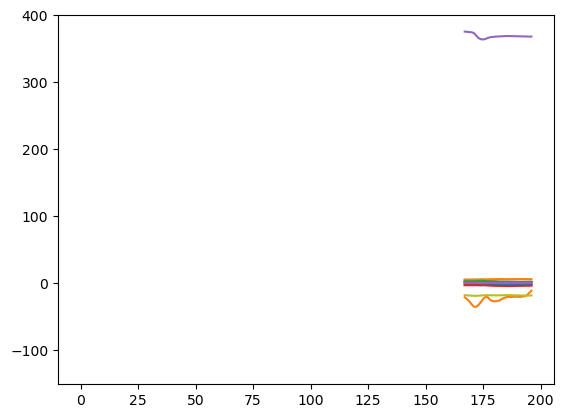

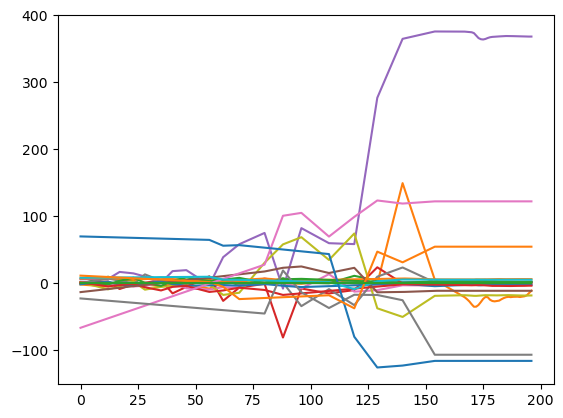

In [34]:
backup_df = pd.DataFrame(backup_motion[..., 0])


backup_df.plot(legend=False)
df_x.plot(legend=False)

ValueError: object too deep for desired array